# Data z reálné jízdy (RSX-UM7)
> Zkoumání pro korelaci s realitou

### 📙 Importy

In [1]:
import pandas as pd
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
import ruptures as rpt
import importlib
from csv2geojson import prep
import json
from fastdtw import fastdtw
from dbrail2geojson import get_rail
from scipy.signal import savgol_filter
import numpy as np
from ipyleaflet import Map, basemaps, Marker, Polyline, basemap_to_tiles

pd.options.mode.chained_assignment = None

### 🌐 Globální nastavení a proměnné

#### Nastavení

In [2]:
PREP_GEOJSONS=False
DATA_PATH="../../enet-sz-data/real_rides/"

#### Globální proměnné

In [3]:
processed_sections=[]

#### Laditelné parametry

In [66]:
diesel_params = {
    'Recuperation coefficient': 0.6998270177197322,
    'Curve A': 226.0739452231682,
    'Curve B': 55.026751900632405,
    'Running a': 0.706437197926143,
    'Running b': 0.01899266921470387,
    'Running c': 0.008283331094691721,
    'Comfortable acceleration': 0.41725031534778388,
    'Elevation smoothing': 100,
    'Curve smoothing': 10
}

diesel_params_no_comp = diesel_params.copy()
diesel_params_no_comp["Compensation polynomial"] = None

electro_params = {
    "Elevation smoothing": 100,
    "Curve smoothing": 10,
    "Curve A": 999,
    "Curve B": 100,
    "Running a": 2,
    "Running b": 0.054,
    "Running c": 0.00034,
    "Recuperation coefficient": 0.70,
    "Comfortable acceleration": 0.41,
    "Compensation polynomial": None
}

#### Parametry vlaků

In [46]:
# Source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860
diesel_train_params = {
    "power_limit": 480*1000,
    "mass_locomotive": 56000,
    "mass_wagon": 31490 + 33000
}

# Source: https://cs.wikipedia.org/wiki/Elektrick%C3%A1_jednotka_471
electro_train_params = {
    "power_limit": 2000*1000,
    "mass_locomotive": 155400,
    "mass_wagon": 62.7*1000*2
}

### 📈 Vizualizační funkce

In [5]:
def render_plot(title, x, ys, labels, linestyles=None, width=20, show_hline=False, legend_loc="upper left"):
    if linestyles is None:
        linestyles = ["solid"]*len(ys)
    plt.figure().set_figwidth(width)
    for i,y in enumerate(ys):
        plt.plot(x, y, linestyle=linestyles[i])
    plt.title(title)
    if len(labels) > 0:
        plt.legend(labels, loc=legend_loc)
    if show_hline:
        plt.axhline(y=0, xmin=0.0, xmax=1.0, color="red", linestyle="--", lw=1)
    plt.show()

### ⬇️ Načtení souborů se surovými daty

In [6]:
# Opava-Olomouc
df = um_csv_parser(DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_06-26-06.csv") # Korekce pro začátek jízdy
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

# Olomouc-Opava
df2 = um_csv_parser(DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_09-04-10.csv") # Korekce pro začátek jízdy
# df2["accel_proc_y"] *= -1 # Korekce pro jízdní směr

In [7]:
# Svinov-Štítina
df3 = pd.read_csv(DATA_PATH + "Svinov-Štítina/370/Location.csv", delimiter=",")

# Get distances
def calculate_distance(row):
    return tconsumption.calc_distance_two_points(
        (row["gps_longitude"], row["gps_latitude"]),
        (row["prev_gps_longitude"], row["prev_gps_latitude"]))

df3.rename(columns={"speed": "gps_speed", "latitude": "gps_latitude", "longitude": "gps_longitude"}, inplace=True)
df3["prev_gps_longitude"] = df3["gps_longitude"].shift(1)
df3["prev_gps_latitude"] = df3["gps_latitude"].shift(1)
df3["distance_m"] = df3.apply(calculate_distance, axis=1)
del df3["prev_gps_longitude"]
del df3["prev_gps_latitude"]
df3["cumulative_distance_m"] = df3["distance_m"].cumsum()

### 🔎 Náhled na akceleraci a rychlost v celém souboru

#### Mezi Opavou a Olomoucí

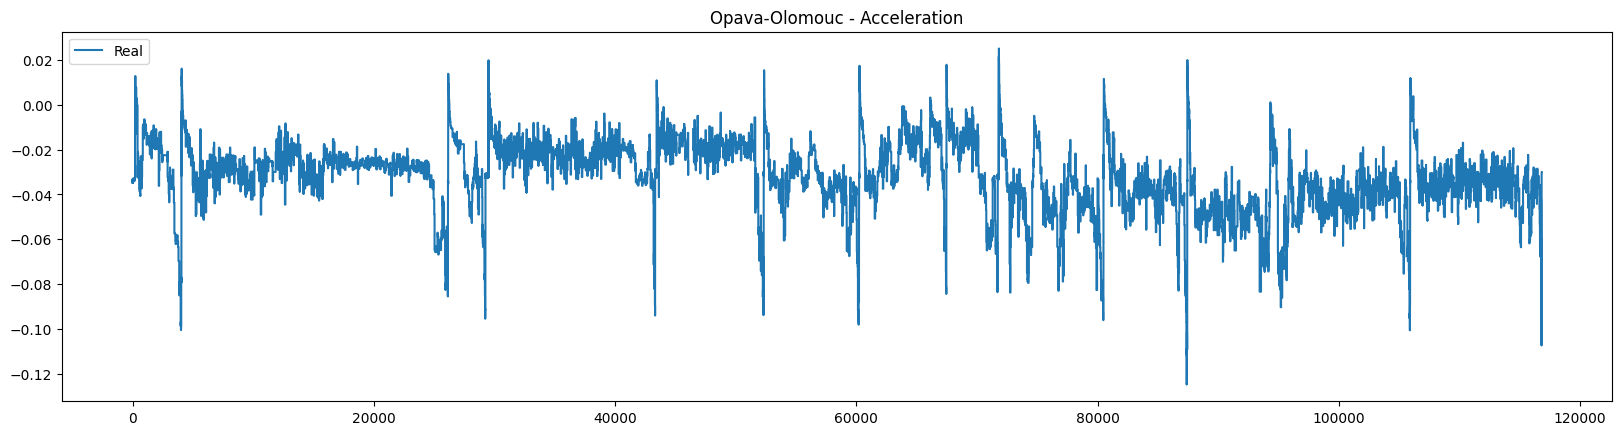

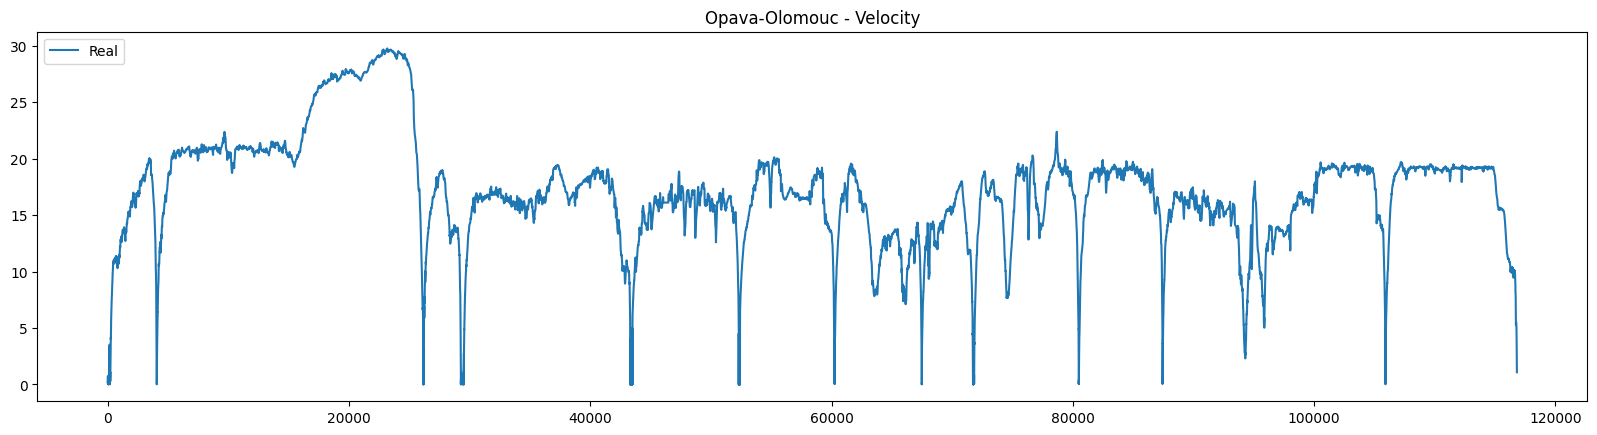

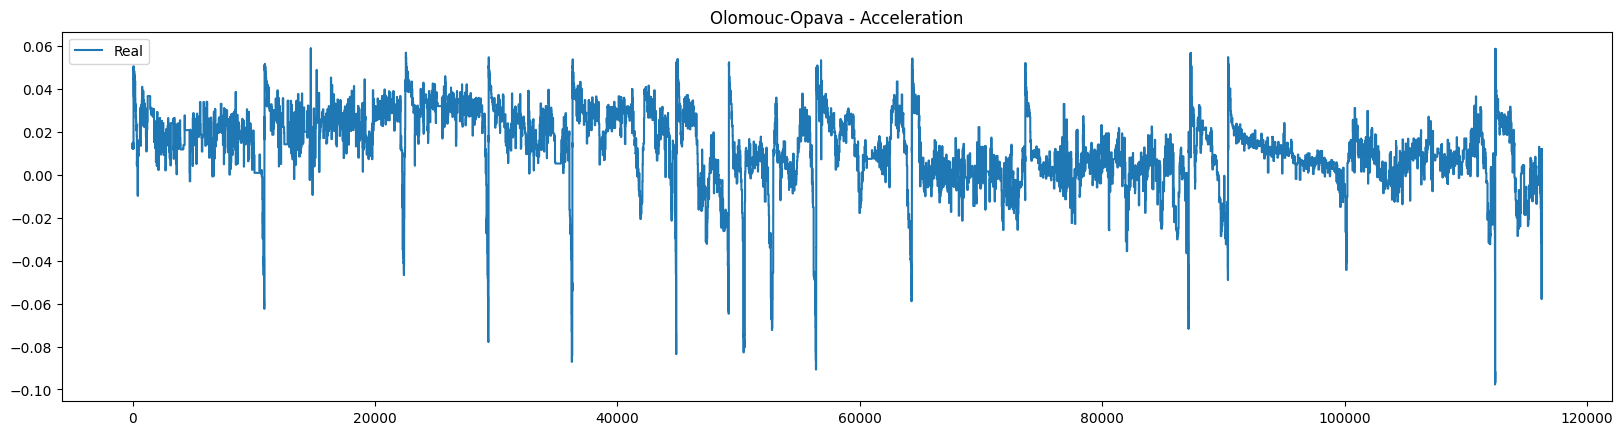

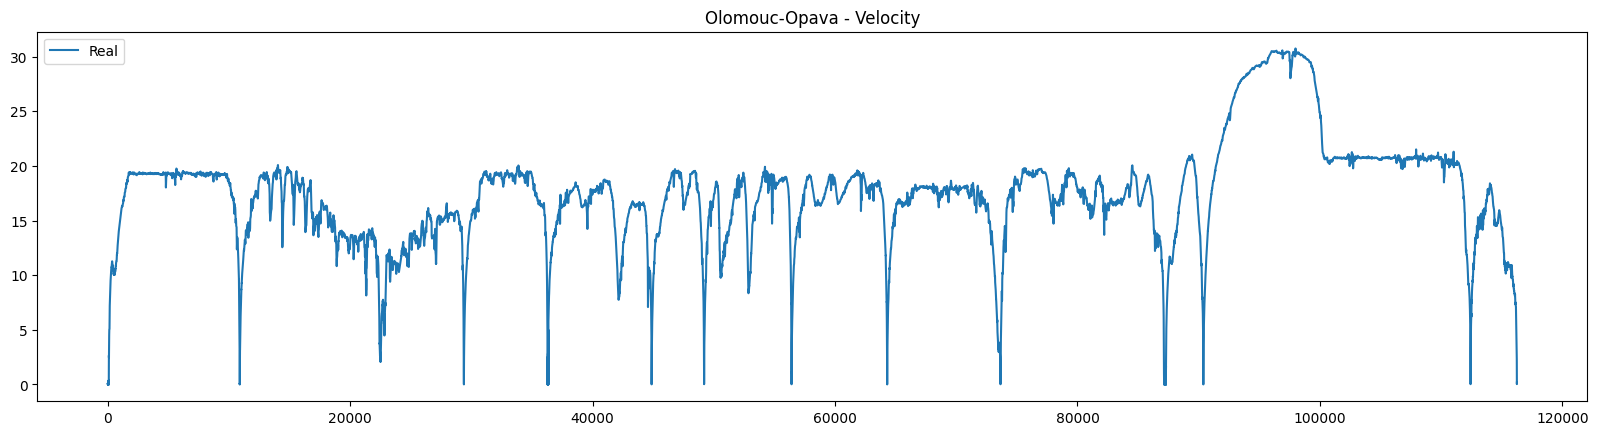

In [8]:
render_plot(
    "Opava-Olomouc - Acceleration",
    df["cumulative_distance_m"],
    [df["accel_proc_y"]],
    ["Real"],
    ["solid"]
)

render_plot(
    "Opava-Olomouc - Velocity",
    df["cumulative_distance_m"],
    [df["gps_speed"]],
    ["Real"],
    ["solid"]
)

render_plot(
    "Olomouc-Opava - Acceleration",
    df2["cumulative_distance_m"],
    [df2["accel_proc_y"]],
    ["Real"],
    ["solid"]
)

render_plot(
    "Olomouc-Opava - Velocity",
    df2["cumulative_distance_m"],
    [df2["gps_speed"]],
    ["Real"],
    ["solid"]
)

#### Mezi Svinovem a Štítinou

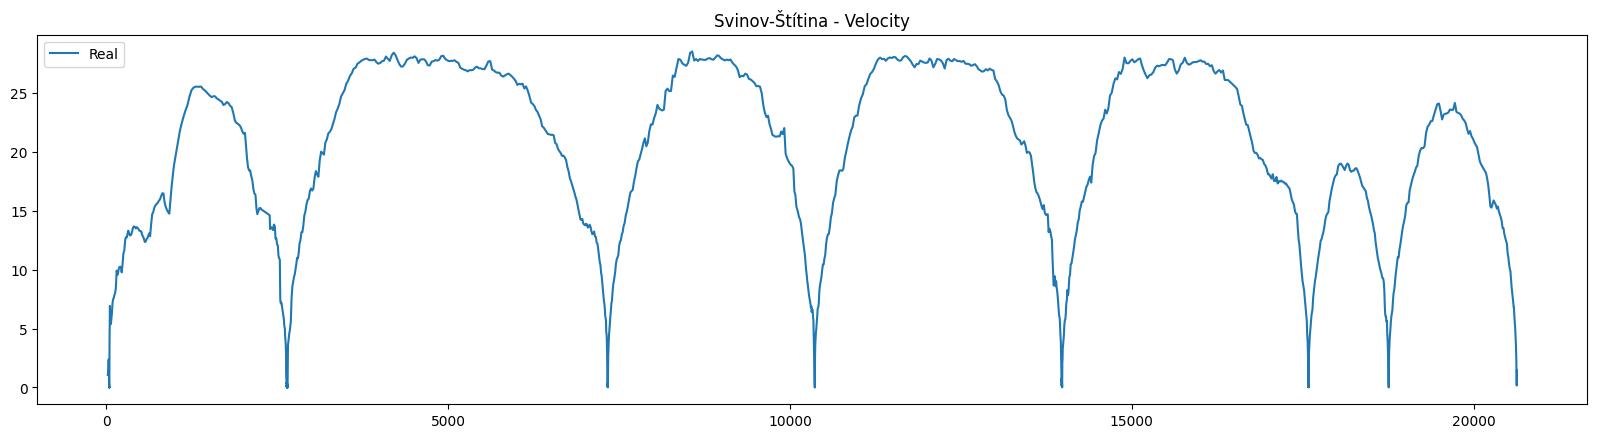

In [9]:
render_plot(
    "Svinov-Štítina - Velocity",
    df3["cumulative_distance_m"],
    [df3["gps_speed"]],
    ["Real"],
    ["solid"]
)

### 🛠️ Funkce pro zpracování

In [53]:
def map_velocity(df_measured, first_offset, velocity_fp, reverse=False):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    first_dist = df_measured["cumulative_distance_m"].iloc[0]
    if not reverse:
        for tv in track_velocity:
            start_in_m = tv["start"]*1000
            df_measured.loc[first_offset*1000 - (df_measured["cumulative_distance_m"]-first_dist) <= start_in_m, "track_velocity"] = tv["value"]
    else:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            df_measured.loc[first_offset*1000 + (df_measured["cumulative_distance_m"]-first_dist) >= start_in_m, "track_velocity"] = tv["value"]

    df_measured["track_velocity_m_s"] = df_measured["track_velocity"]/3.6

def infer_velocity(df_measured, penalty):
    # Getting velocity segments
    algo = rpt.Pelt(model="rbf").fit(df_measured["gps_speed"].values)
    result = algo.predict(pen=penalty)

    max_velocities = []
    prev_end = 0
    for i,r in enumerate(result):
        segment = df_measured["gps_speed"][prev_end:r]
        if len(df_measured["gps_speed"][result[i-1]:r]) < 100 and i != len(result)-1:
            continue
        prev_end = r
        max_velocities += [max(segment)] * len(segment)

    df_measured["track_velocity_m_s"] = max_velocities

In [56]:
def run_simulation(df_measured, geojson_path: str, variable_params, train_params):
    # Calculated data
    c = tconsumption.Consumption()
    c.variable_params.update(variable_params)
    c.load_from_file(geojson_path)
    if "track_velocity_m_s" in df_measured:
        c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"])
    # print("unique velocities in km/h", set([x*3.6 for x in df_measured["track_velocity_m_s"]]))

    c.params = train_params

    # Running the simulation
    c.run()

    return c

In [57]:
def compare_data(df_measured, geojson_path: str, variable, variable_no_comp, train_params):
    # Without compensation
    c = run_simulation(df_measured, geojson_path, variable_no_comp, train_params)
    # Compensated simulation
    cc = run_simulation(df_measured, geojson_path, variable, train_params)

    # Plotting
    # render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    limited_len = len(c.series["dist_values"])
    # limited_len = 1566
    render_plot(
        "Velocity",
        c.series["dist_values"][:limited_len],
        [c.series["velocity_values"][:limited_len], cc.series["velocity_values"], df_measured["gps_speed"][:limited_len], c.max_velocities_in_mps[:limited_len]],
        ["Simulation", "Simulation (compensated)", "Real", "Limit"],
        ["solid", "solid", "solid", "dashed"],
        legend_loc="lower center"
    )

    # Velocity deltas
    velocity_deltas = []
    # Get deltas
    for i in range(len(c.series["velocity_values"])):
        delta = c.series["velocity_values"][i] - df_measured["gps_speed"].iloc[i]
        velocity_deltas.append(delta)

    render_plot(
        "Velocity delta",
        c.series["dist_values"],
        [velocity_deltas],
        ["Delta"],
        ["solid"]
    )

    dtw = fastdtw(c.series["velocity_values"], df_measured["gps_speed"])[0]
    print("DTW:", dtw)

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"][:100],
    #     [c.series["acceleration_values"][:100]],
    #     ["Simulation (slice)"]
    # )

    # GPS info
    m = Map(
        basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
        center=((df_measured.iloc[0]['gps_latitude']+df_measured.iloc[-1]['gps_latitude'])/2, (df_measured.iloc[0]['gps_longitude']+df_measured.iloc[-1]['gps_longitude'])/2),
        zoom=12
    )
    line = Polyline(
        locations=df_measured[["gps_latitude", "gps_longitude"]].values.tolist(),
        color="green",
        fill=False
    )
    m.add_layer(line)
    return m

### 🛤️ Zpracované úseky (Opava-Olomouc)

#### 🤖 Automatické rozdělení na úseky

In [13]:
def get_station_ranges(df, station_names, min_running_len=200):
    df_auto = df.copy()
    df_auto.loc[df_auto["gps_speed"] < 1, "train_stopped"] = True
    df_auto.loc[df_auto["gps_speed"] >= 1, "train_stopped"] = False

    # Extract raw ranges
    df_auto["consec_group"] = (df_auto["train_stopped"] != df_auto["train_stopped"].shift(1)).cumsum()
    count = df_auto[["train_stopped", "consec_group"]].value_counts()
    count.sort_index(level=1, inplace=True)
    consec_values = [(x[0], y) for x, y in count.items()]

    # Process start-stop ranges
    new_consec = []
    to_next = None
    for g in consec_values:
        if g[0] or not g[0] and g[1] >= min_running_len:
            if len(new_consec) > 0 and new_consec[-1][0] == g[0]:
                new_consec[-1] = (new_consec[-1][0], new_consec[-1][1]+g[1])
            else:
                new_consec.append(g)
            if to_next is not None:
                new_consec[-1] = (new_consec[-1][0], new_consec[-1][1]+to_next)
                to_next = None
        else:
            if len(new_consec) > 0:
                new_consec[-1] = (new_consec[-1][0], new_consec[-1][1]+g[1])
            else:
                to_next = g[1]

    # Find station_ranges
    station_ranges = []
    running_count = 0
    current_start = None
    current_end = None
    station_idx = 0
    for g in new_consec:
        running_count += g[1]
        if g[0] and current_start is None:
            current_start = running_count-1
        if not g[0] and current_end is None:
            current_end = running_count-1
            station_ranges.append({
                "station_start": station_names[station_idx],
                "start": current_start,
                "station_end": station_names[station_idx+1],
                "end": current_end
            })
            station_idx += 1
            current_start, current_end = None, None

    # plot_range = (0, len(df_auto["gps_speed"]))
    # # plot_range = (1000, 4000)
    # render_plot(
    #     "Velocity",
    #     df_auto["cumulative_distance_m"][plot_range[0]:plot_range[1]],
    #     [df_auto["gps_speed"][plot_range[0]:plot_range[1]], df_auto["train_stopped"][plot_range[0]:plot_range[1]]],
    #     ["Velocity"],
    #     ["solid", "solid"],
    #     legend_loc="upper left"
    # )

    return station_ranges

In [54]:
def compare_station_ranges(df, station_ranges, path_start, variable, variable_no_comp, train_params, auto_velocity=True):
    m = Map(
        basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
        center=((df.iloc[0]['gps_latitude']+df.iloc[-1]['gps_latitude'])/2, (df.iloc[0]['gps_longitude']+df.iloc[-1]['gps_longitude'])/2),
        zoom=12
    )

    importlib.reload(tconsumption)

    for sr in station_ranges:
        loc = (df.iloc[sr["start"]]["gps_latitude"], df.iloc[sr["start"]]["gps_longitude"])

        # GPS info
        marker = Marker(location=loc, draggable=False)
        m.add_layer(marker)

        print(sr)

        df_slice = df.loc[sr["start"]:sr["end"]] # Rozsah bodů mezi stanicemi
        if auto_velocity:
            infer_velocity(df_slice, 10)

        output_geojson = f"{DATA_PATH}{path_start}_auto_{sr['station_start'].replace(' ', '_')}-{sr['station_end'].replace(' ', '_')}.geojson"
        if PREP_GEOJSONS:
            prep({
                # "input": "NOT NEEDED",
                "output": output_geojson,
                "host": "localhost",
                "dbname": "railway_mapdb",
                "dbuser": "postgres",
                "dbpass": "mysecretpassword",
                "dbtable": "train_testing_data"
            }, df=df_slice)


        processed_sections.append({"df": df_slice, "geojson": output_geojson})
        compare_data(
            df_slice,
            output_geojson,
            variable,
            variable_no_comp,
            train_params
        )

    return m

#### 🚂 Cesta tam (komplet)

12
{'station_start': 'Opava východ', 'start': 348, 'station_end': 'Opava západ', 'end': 989}


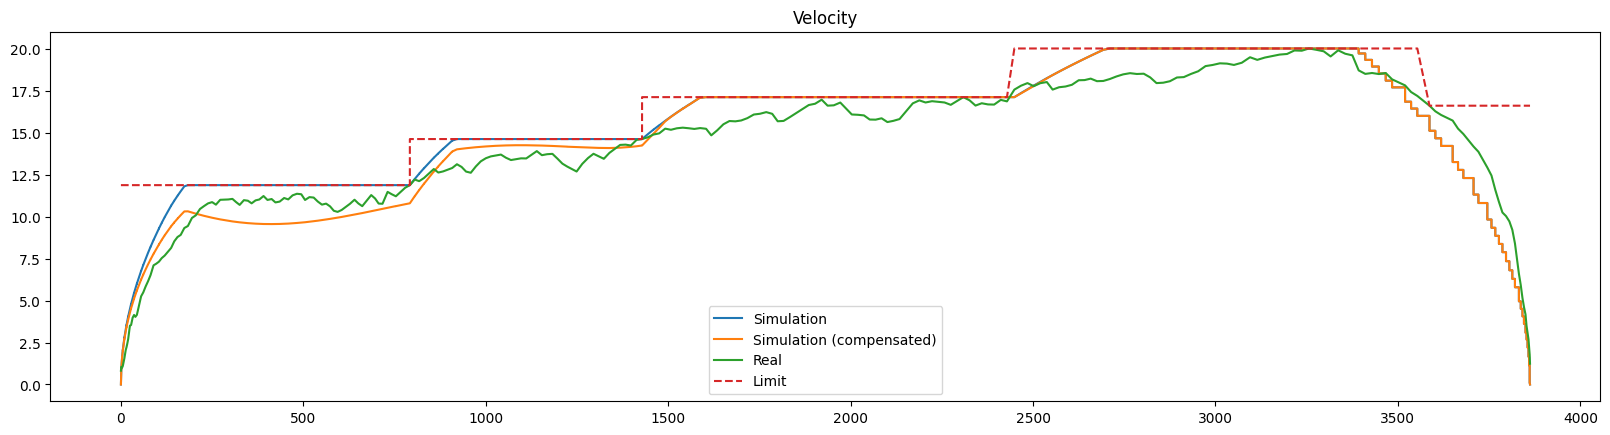

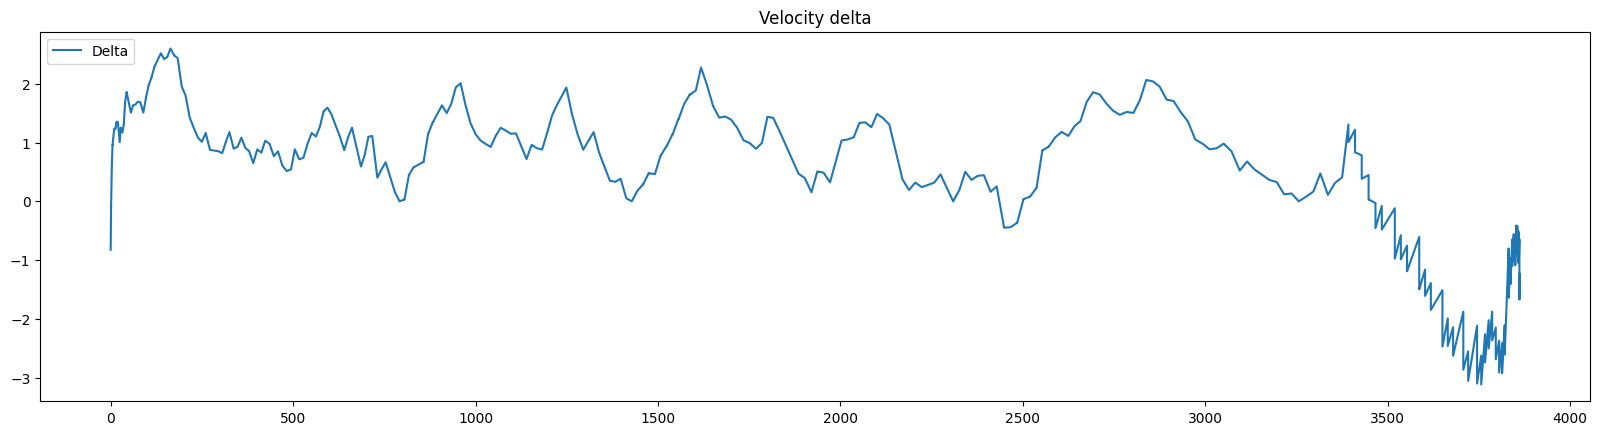

DTW: 152.6135751297963
{'station_start': 'Opava západ', 'start': 1092, 'station_end': 'Krnov-Cvilín', 'end': 3521}


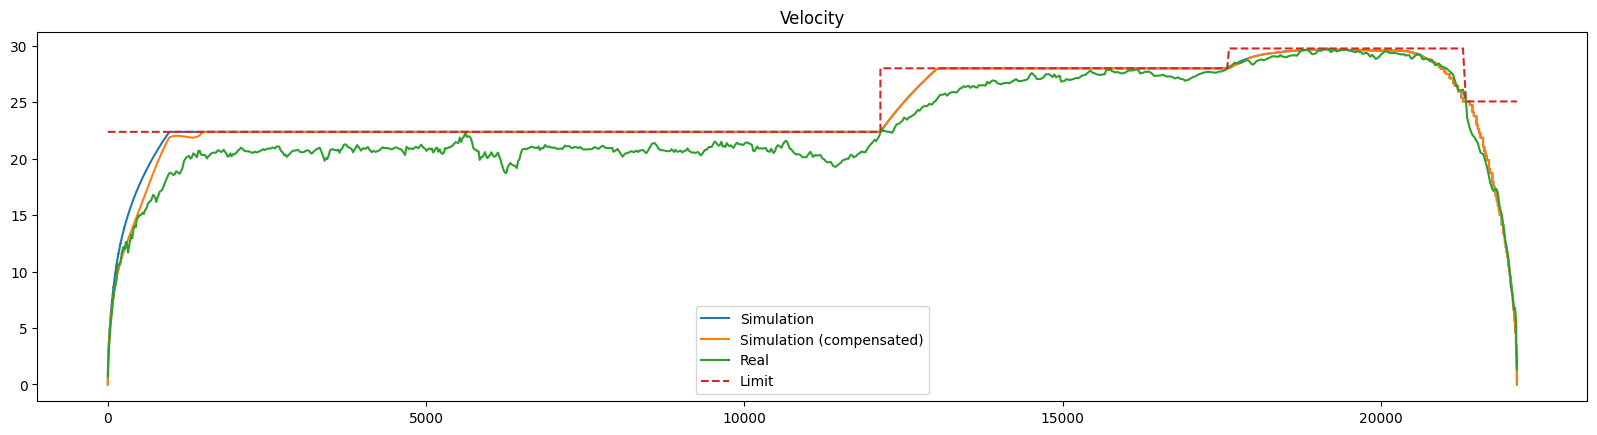

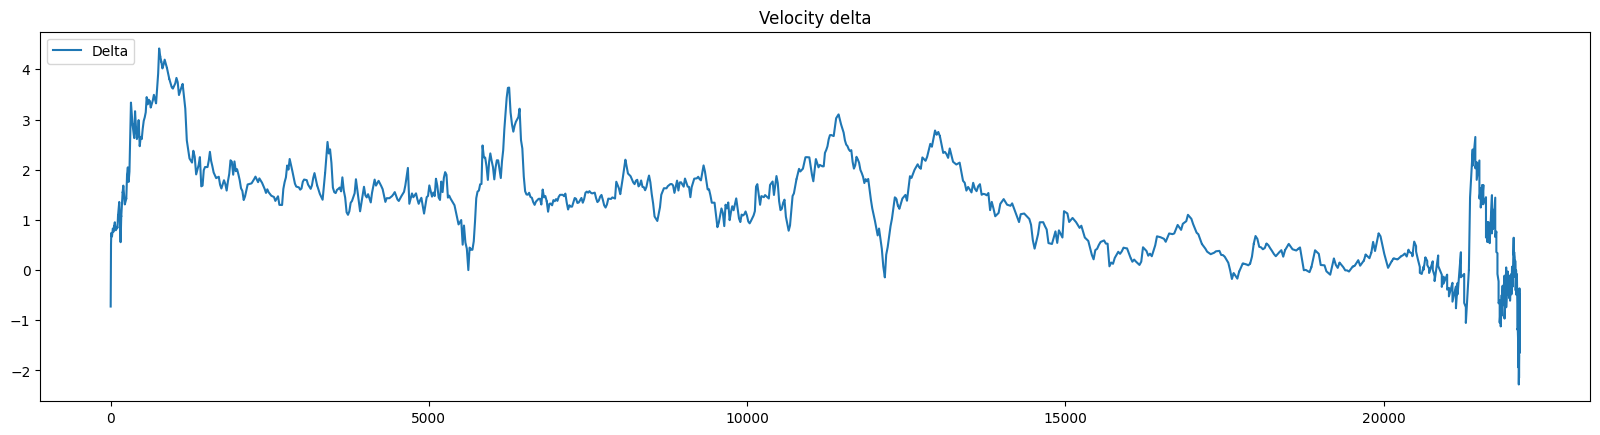

DTW: 1073.6014844901235
{'station_start': 'Krnov-Cvilín', 'start': 3704, 'station_end': 'Krnov', 'end': 4248}


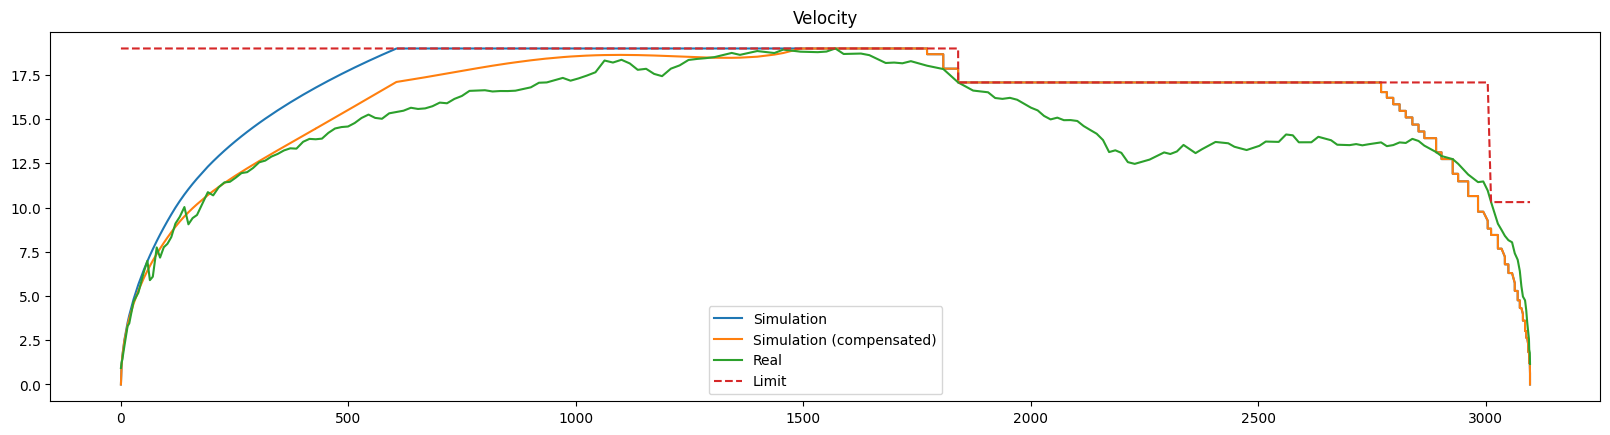

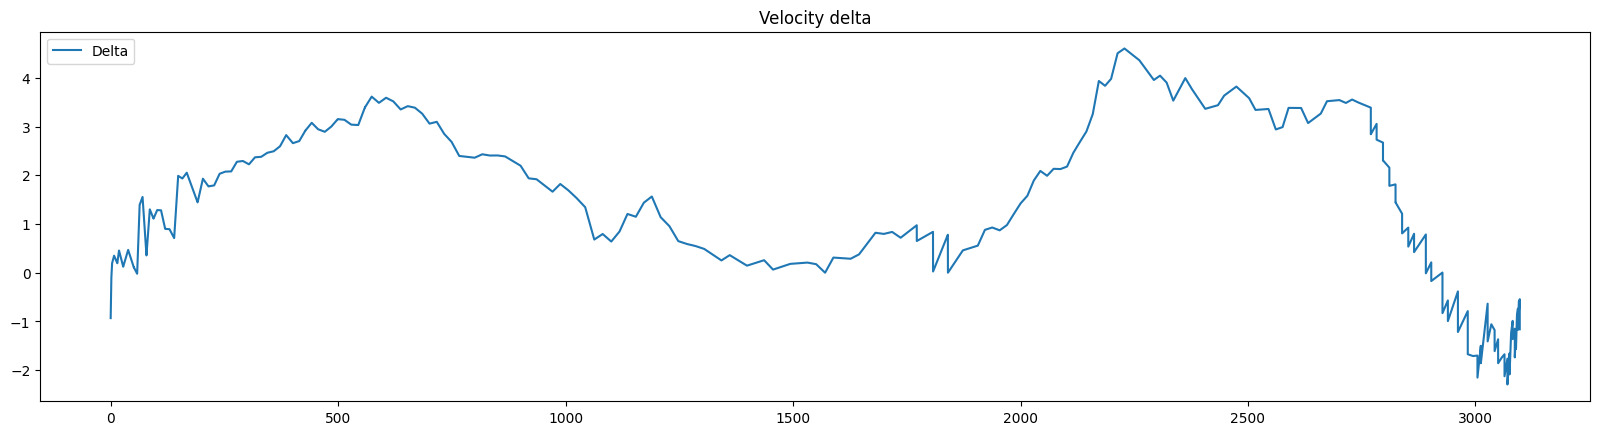

DTW: 129.0503846316328
{'station_start': 'Krnov', 'start': 5595, 'station_end': 'Milotice n.Opavou', 'end': 7766}


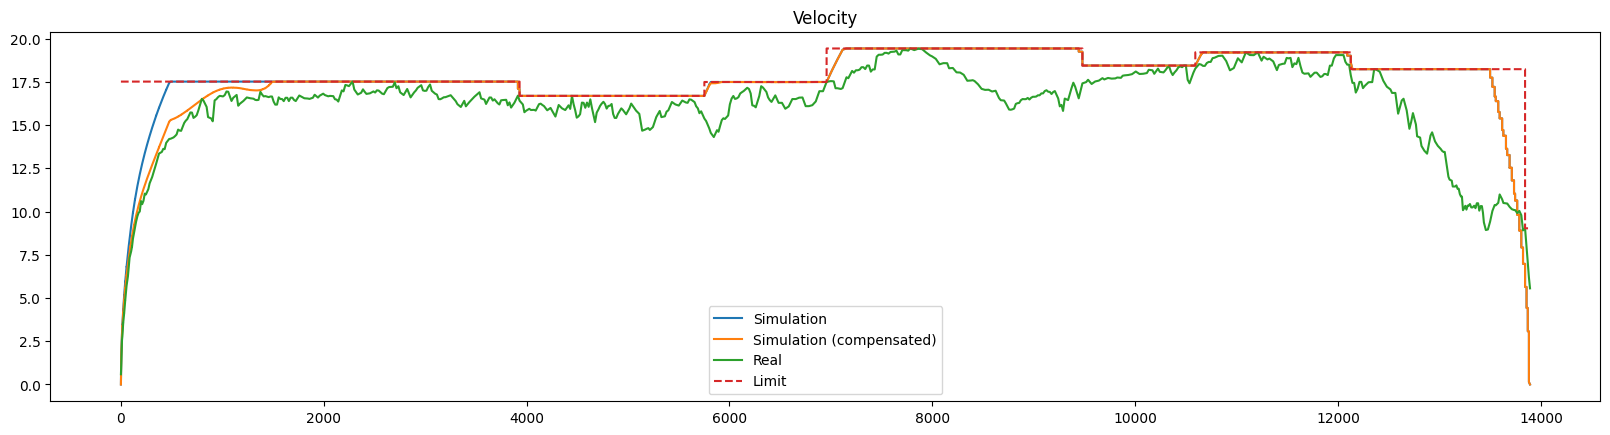

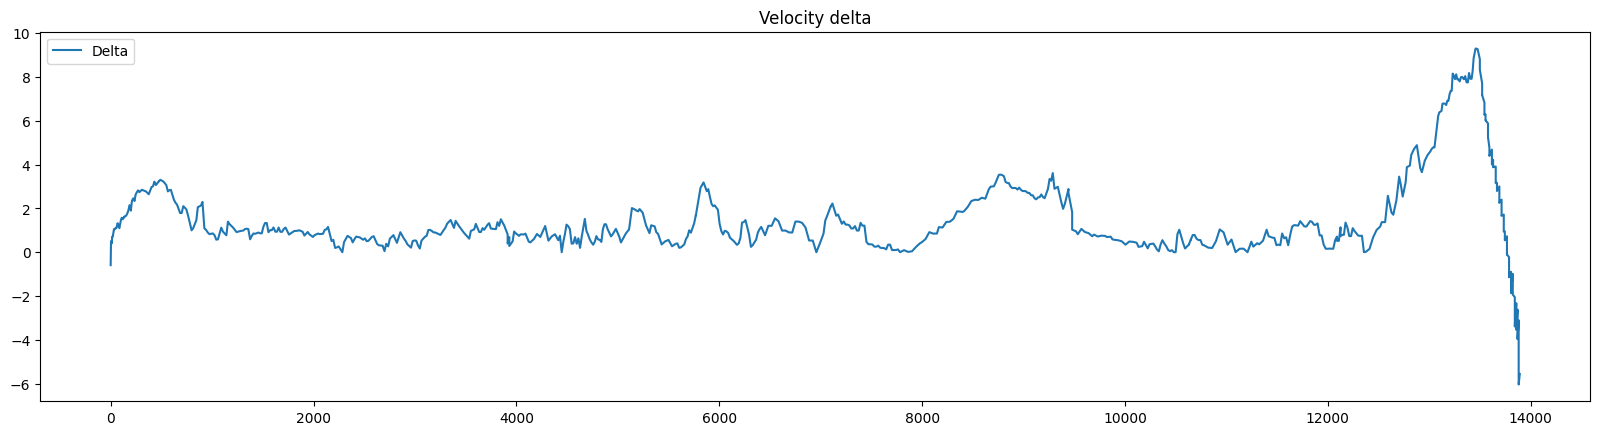

DTW: 1248.21580965737
{'station_start': 'Milotice n.Opavou', 'start': 8336, 'station_end': 'Bruntál', 'end': 9786}


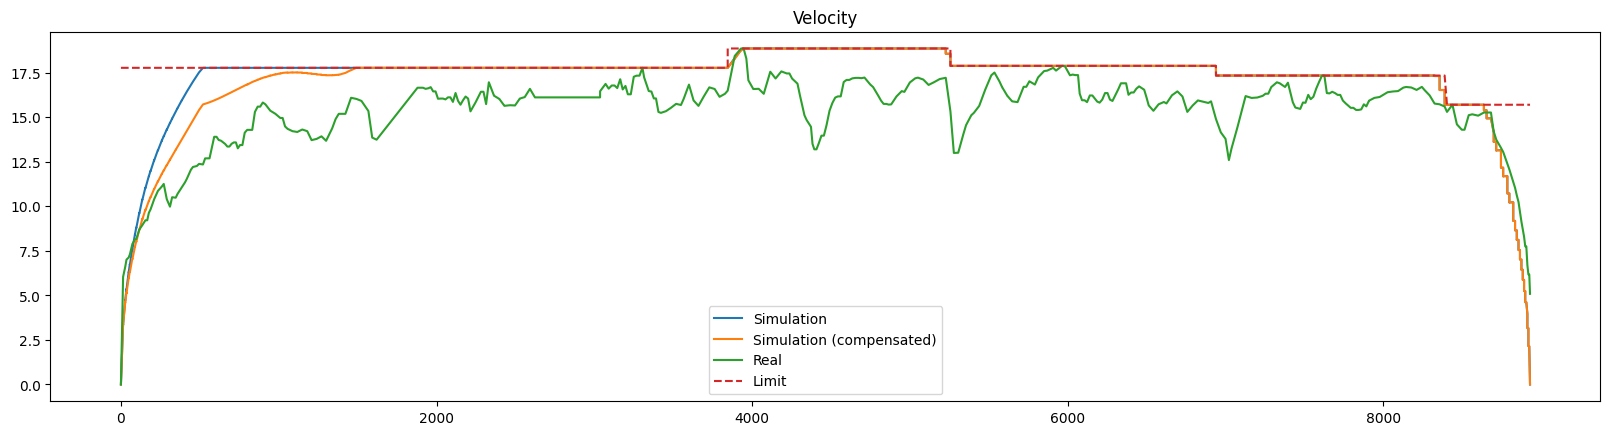

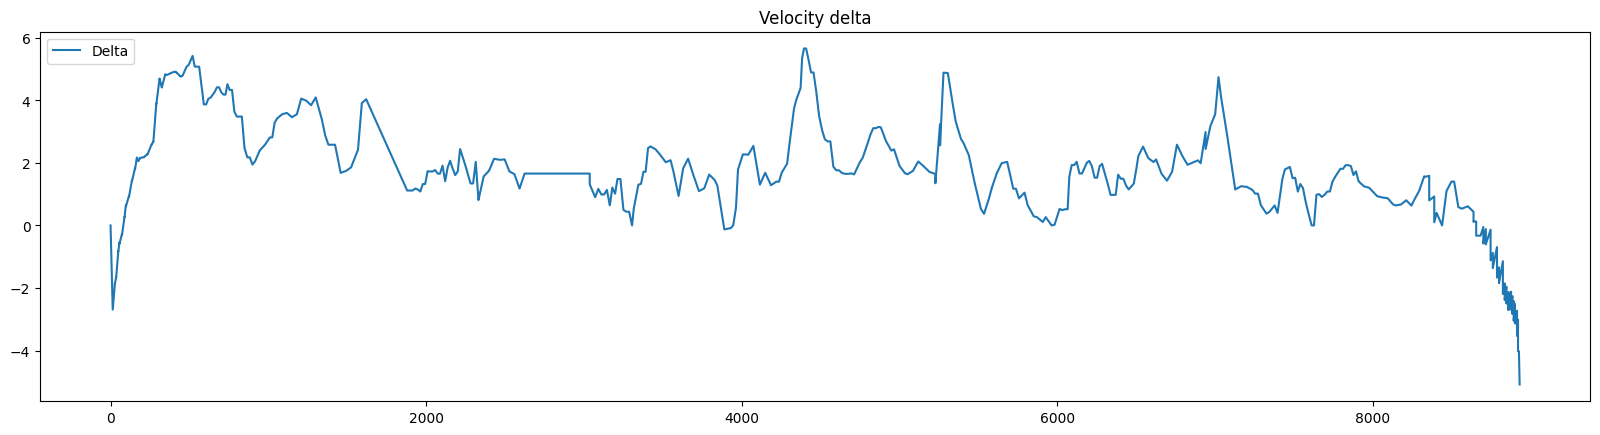

DTW: 1365.1123337707381
{'station_start': 'Bruntál', 'start': 10142, 'station_end': 'Valšov', 'end': 11371}


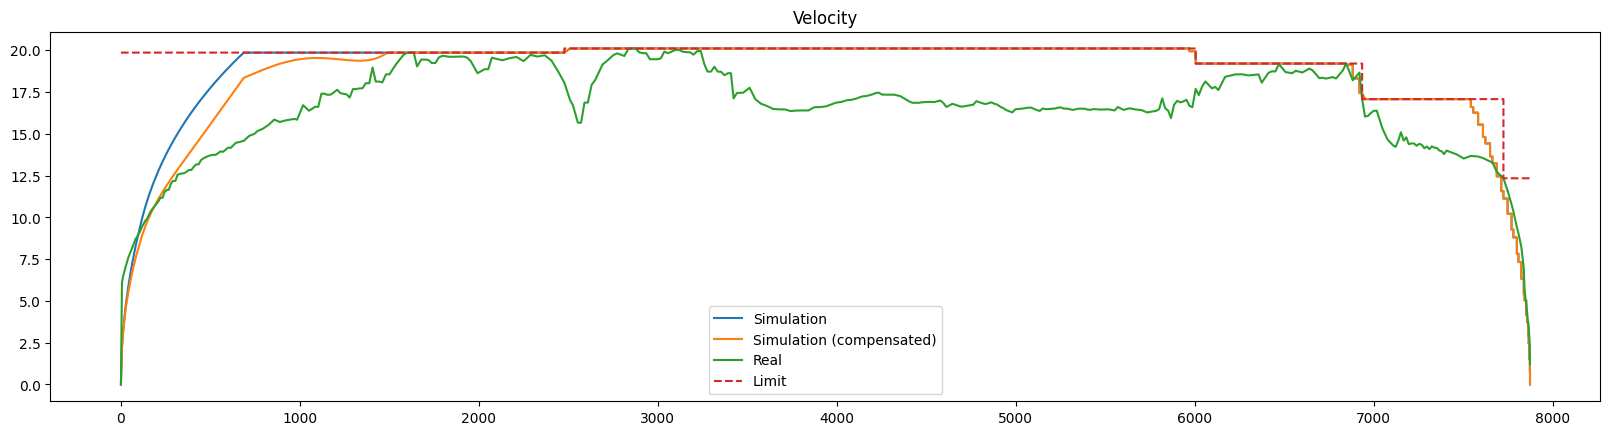

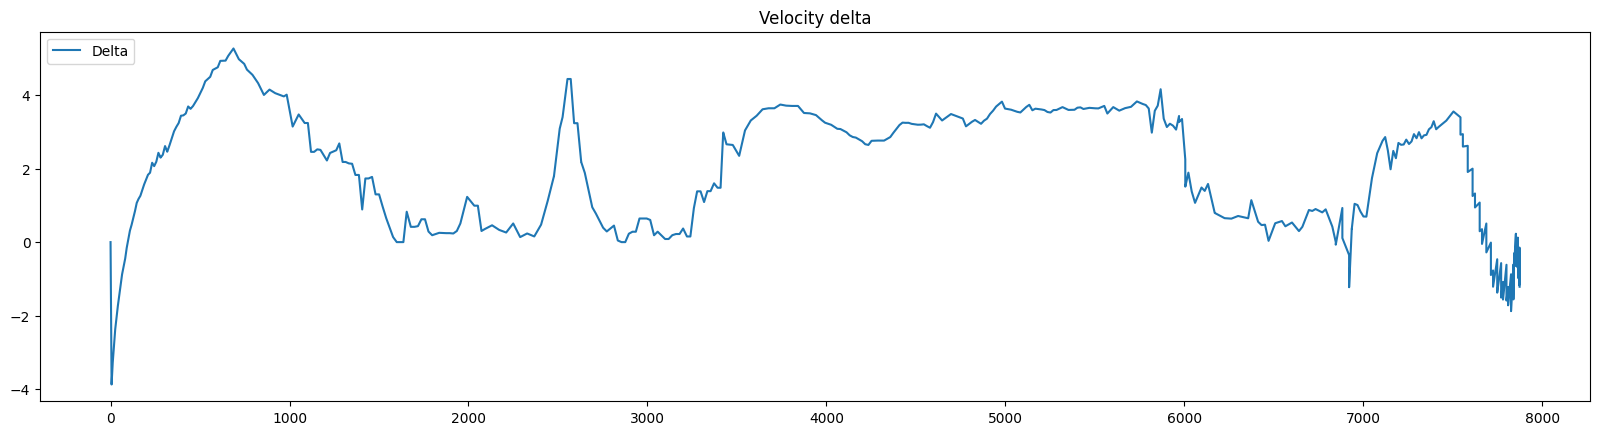

DTW: 595.2703754769082
{'station_start': 'Valšov', 'start': 11481, 'station_end': 'Lomnice u Rýmařova', 'end': 12849}


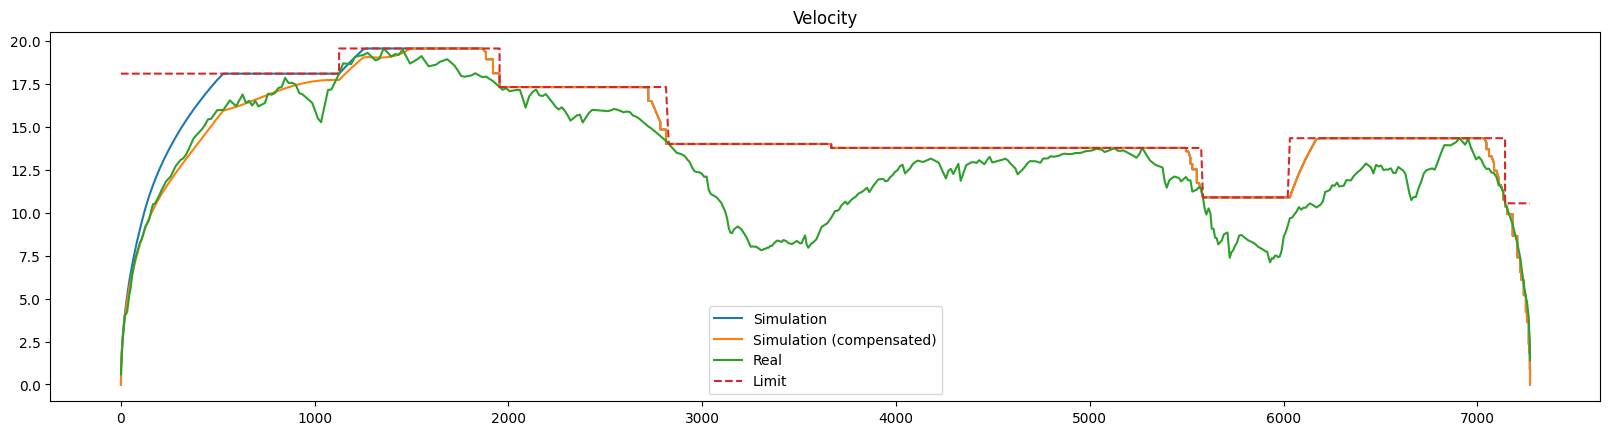

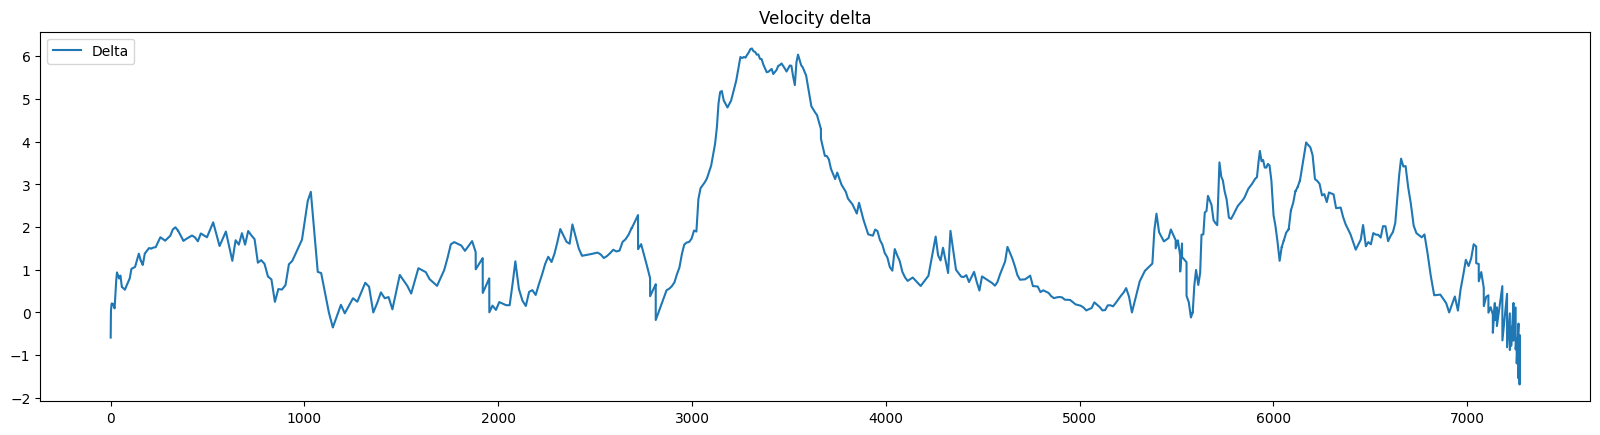

DTW: 1717.2501731482764
{'station_start': 'Lomnice u Rýmařova', 'start': 12922, 'station_end': 'Dětřichov n.Bystřicí', 'end': 13695}


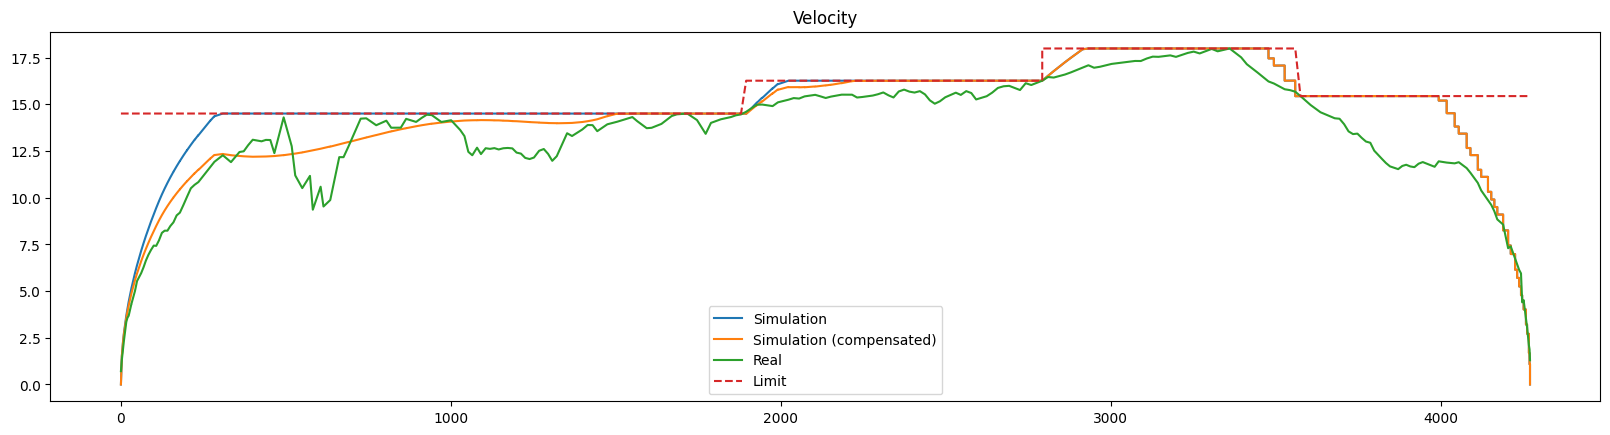

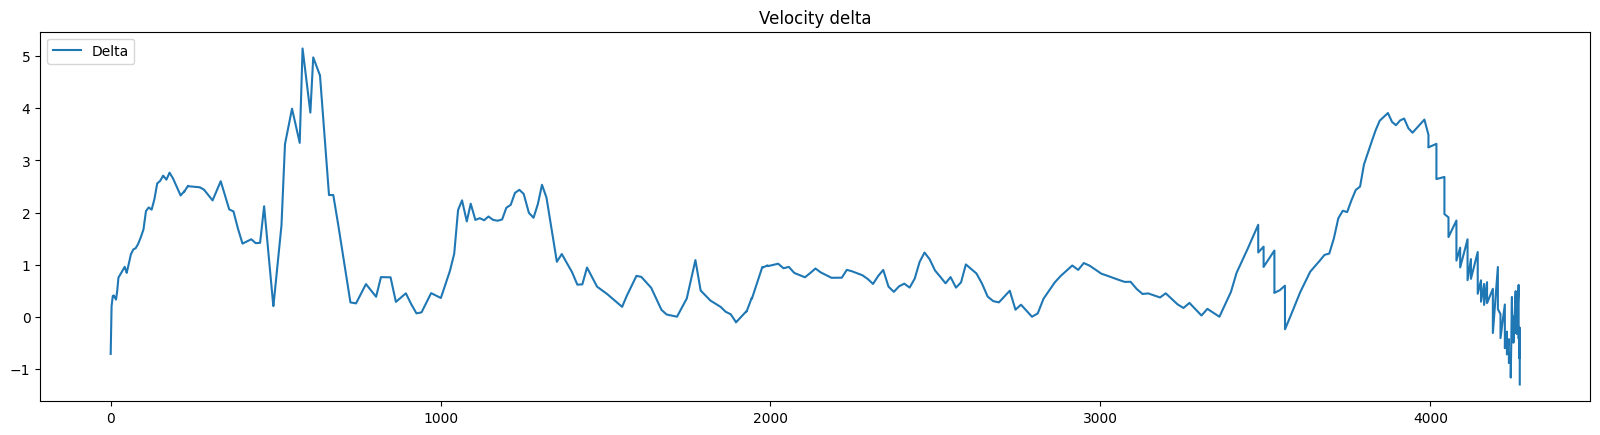

DTW: 277.7595624774815
{'station_start': 'Dětřichov n.Bystřicí', 'start': 14381, 'station_end': 'Moravský Beroun', 'end': 15716}


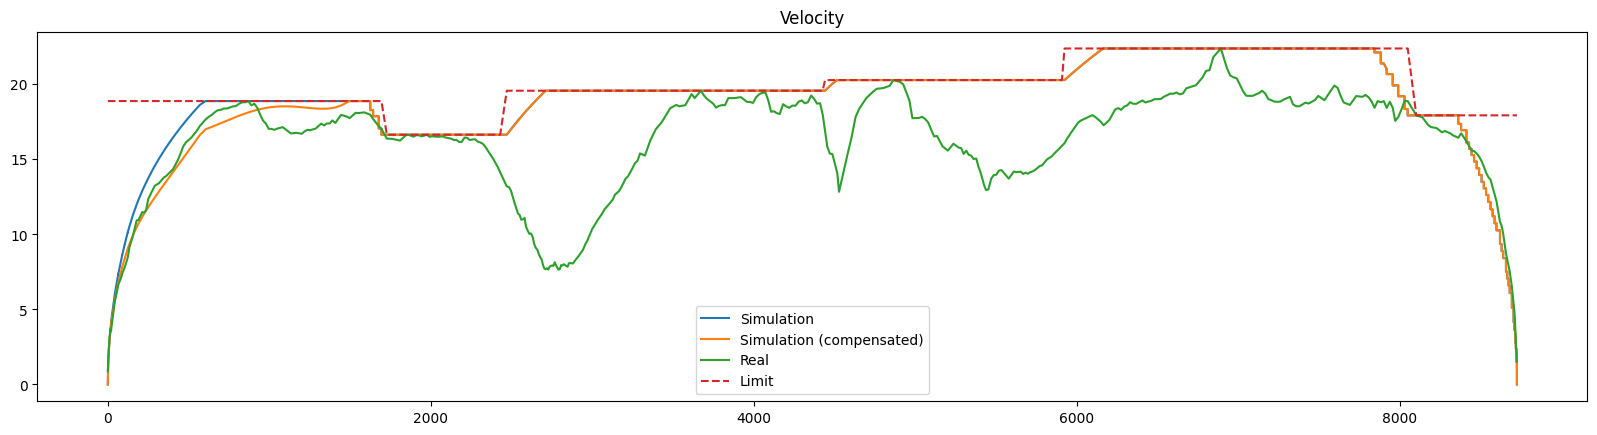

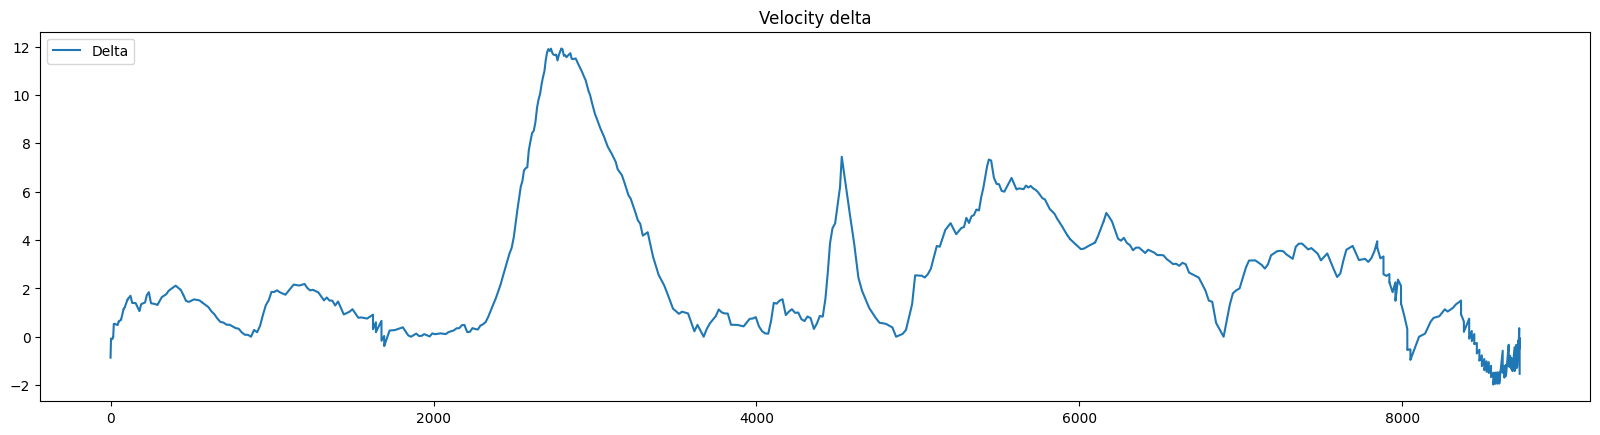

DTW: 2193.777801703456
{'station_start': 'Moravský Beroun', 'start': 15812, 'station_end': 'Domašov n.Bystřicí', 'end': 16800}


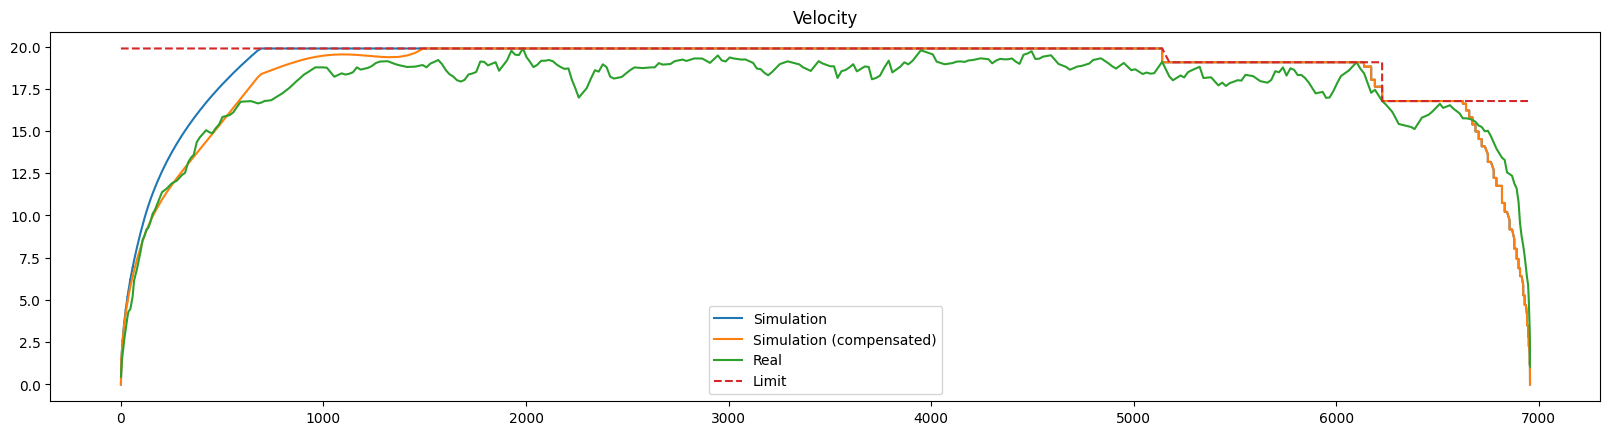

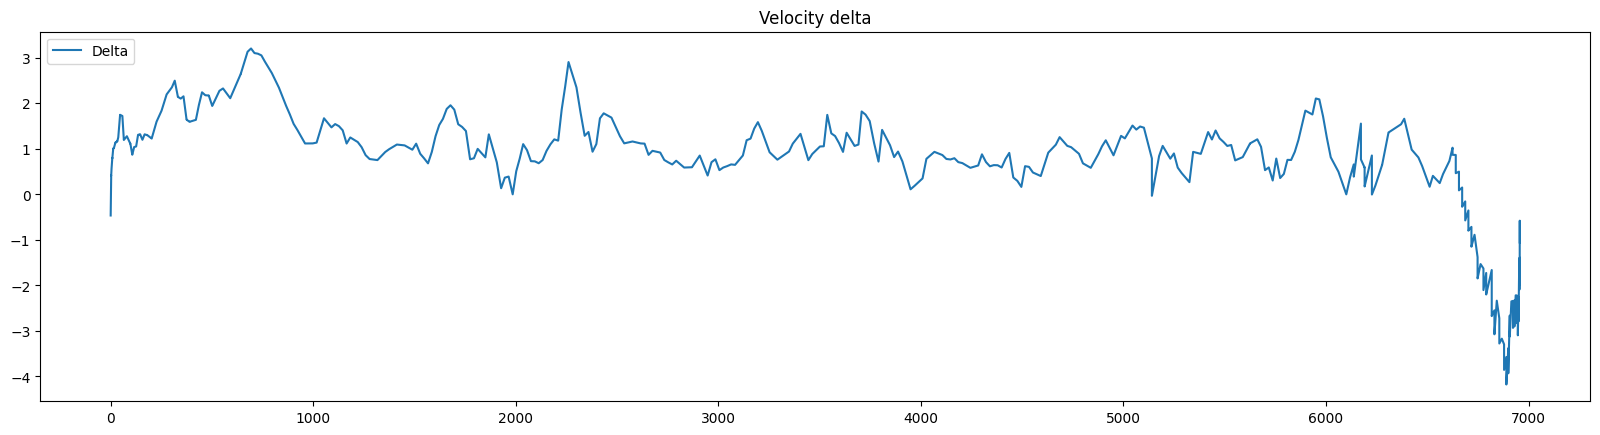

DTW: 489.8926682530835
{'station_start': 'Domašov n.Bystřicí', 'start': 16895, 'station_end': 'Hlubočky-Mar.Údolí', 'end': 19915}


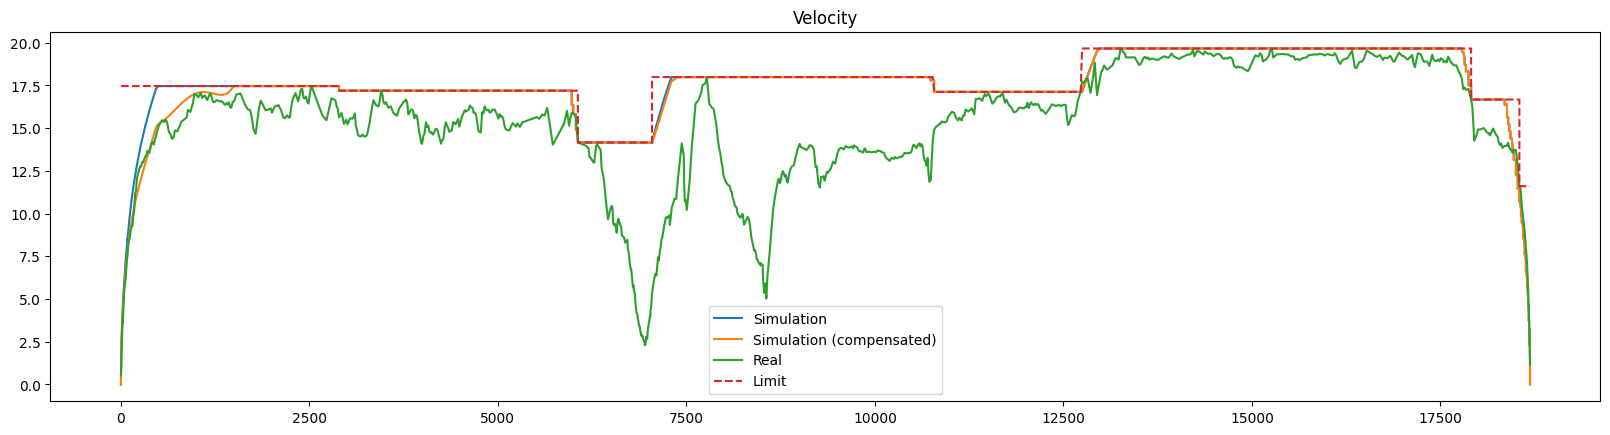

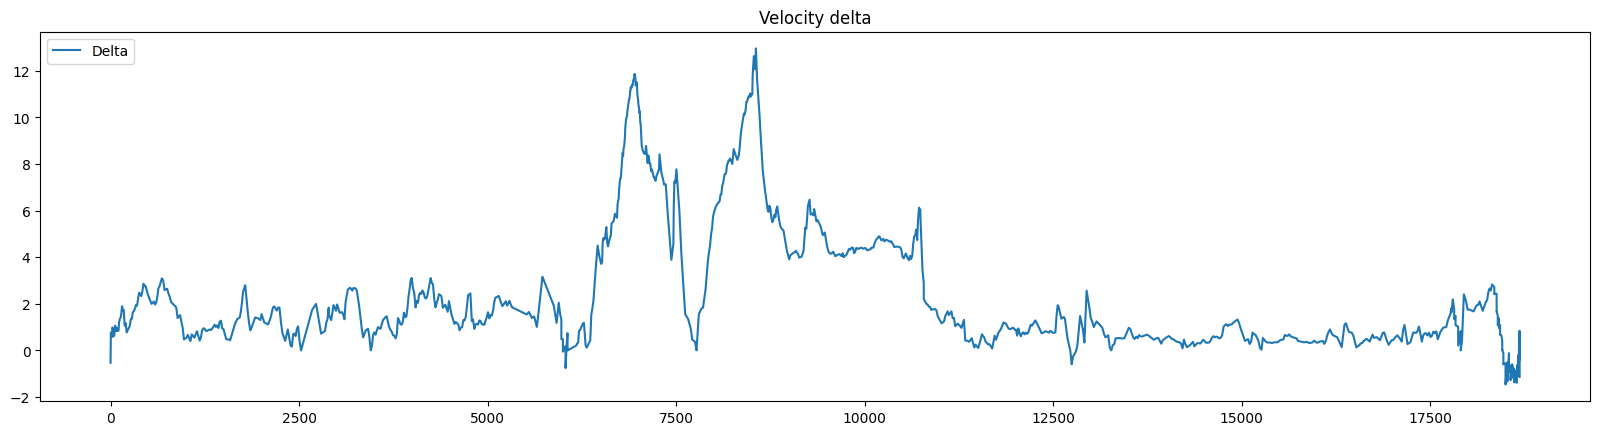

DTW: 5364.875072738296
{'station_start': 'Hlubočky-Mar.Údolí', 'start': 20018, 'station_end': 'Olomouc hl.n.', 'end': 21587}


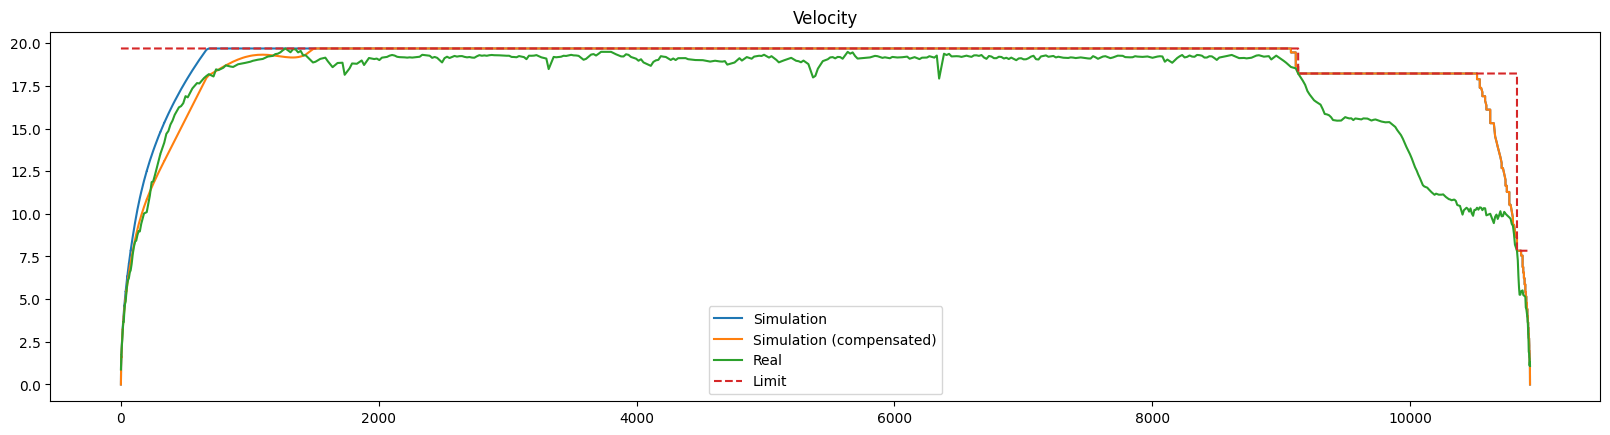

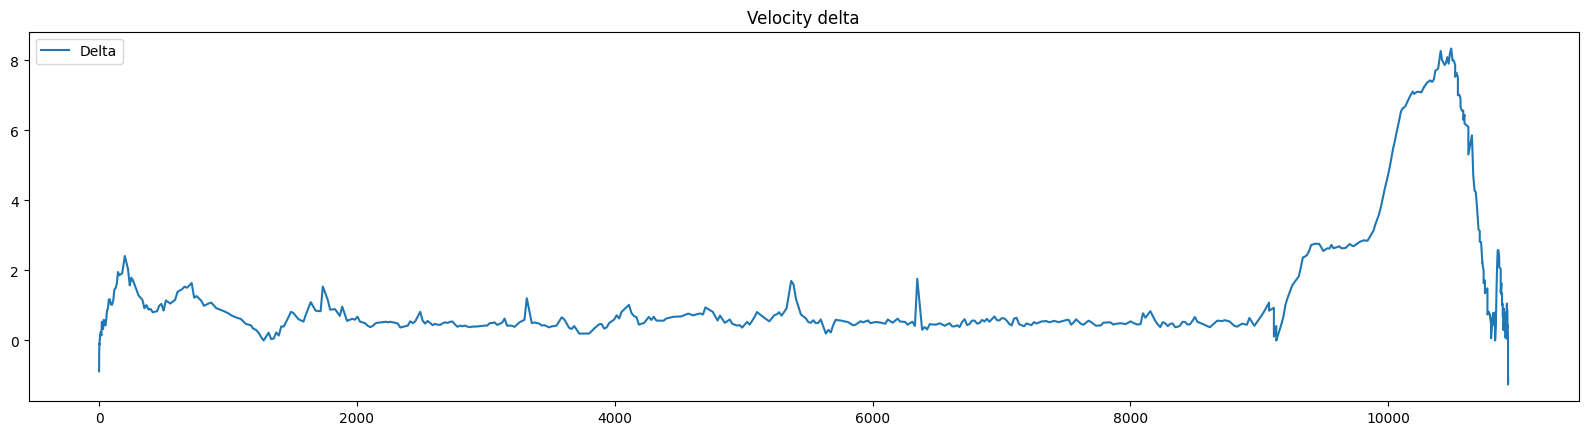

DTW: 589.5522989264388


Map(center=[49.76276779174805, 17.59460163116455], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [15]:
station_ranges = get_station_ranges(df, [
    "Opava východ",
    "Opava západ",
    "Krnov-Cvilín",
    "Krnov",
    "Milotice n.Opavou",
    "Bruntál",
    "Valšov",
    "Lomnice u Rýmařova",
    "Dětřichov n.Bystřicí",
    "Moravský Beroun",
    "Domašov n.Bystřicí",
    "Hlubočky-Mar.Údolí",
    "Olomouc hl.n."
])
print(len(station_ranges))

compare_station_ranges(
    df, station_ranges, "Opava-Olomouc/um7/um7capture",
    diesel_params, diesel_params_no_comp, diesel_train_params)

#### 🚂 Cesta zpět (komplet)

12
{'station_start': 'Olomouc hl.n.', 'start': 1129, 'station_end': 'Hlubočky-Mar.Údolí', 'end': 2578}


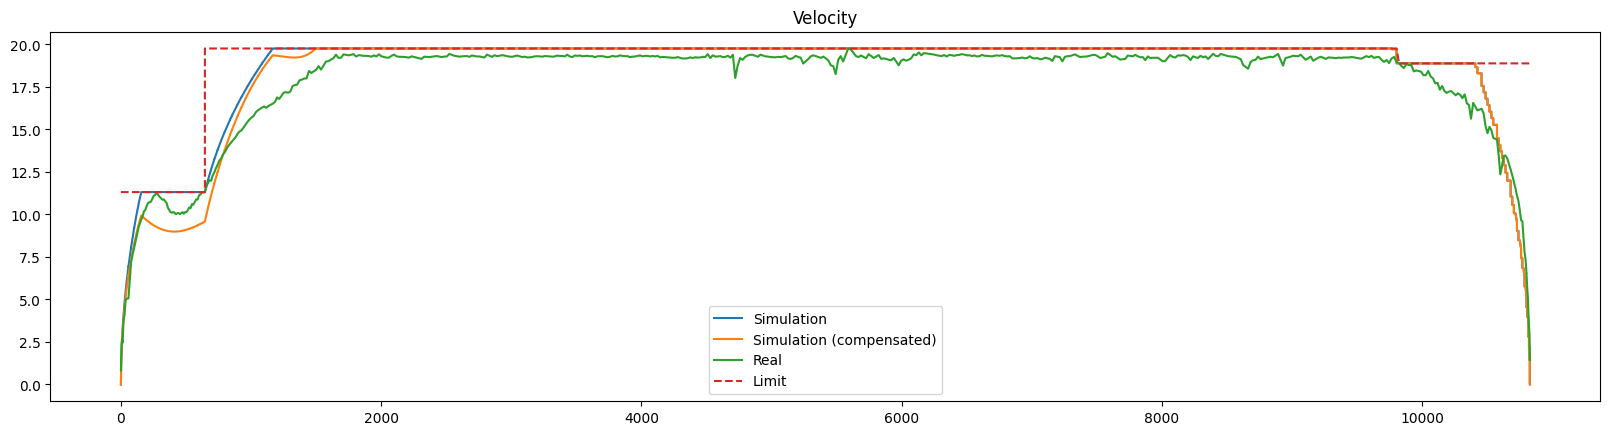

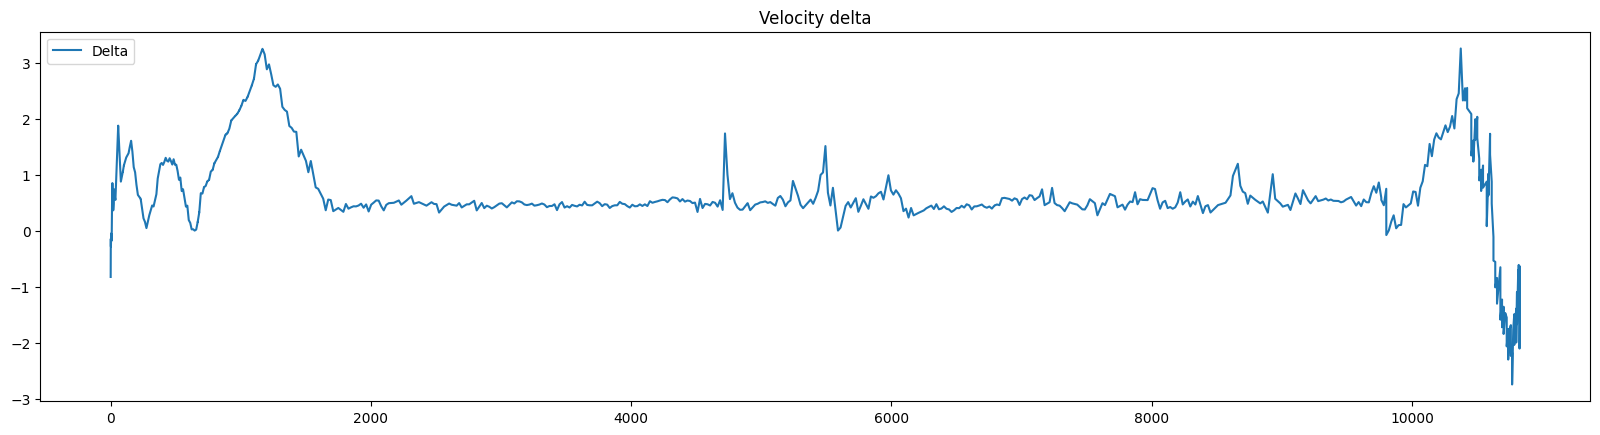

DTW: 578.9864145596517
{'station_start': 'Hlubočky-Mar.Údolí', 'start': 2685, 'station_end': 'Domašov n.Bystřicí', 'end': 5716}


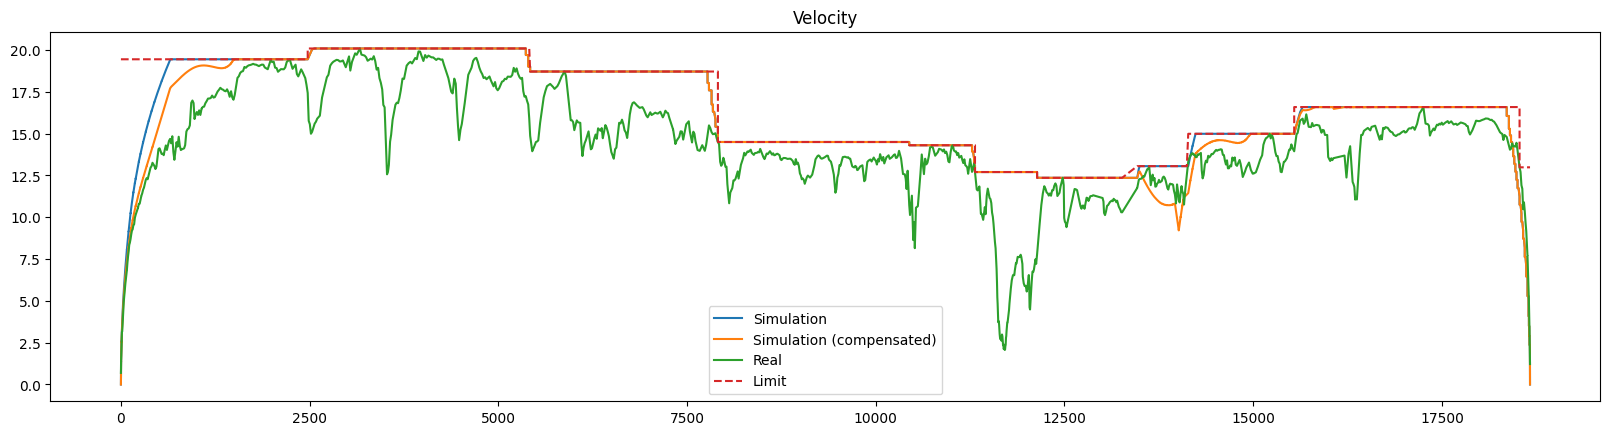

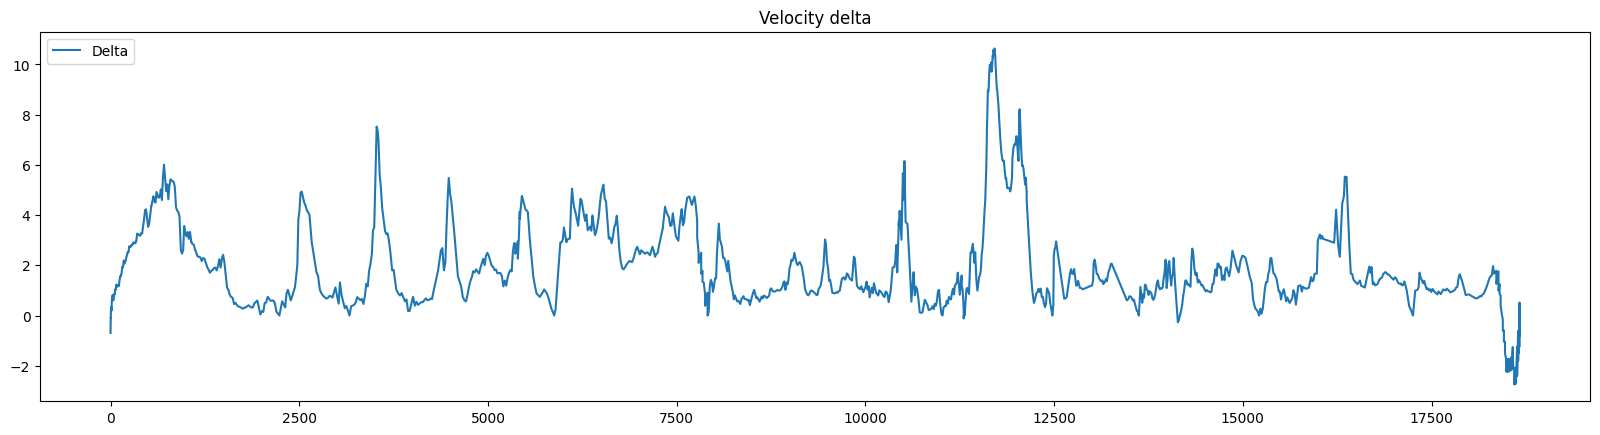

DTW: 3689.569291135102
{'station_start': 'Domašov n.Bystřicí', 'start': 5830, 'station_end': 'Moravský Beroun', 'end': 6795}


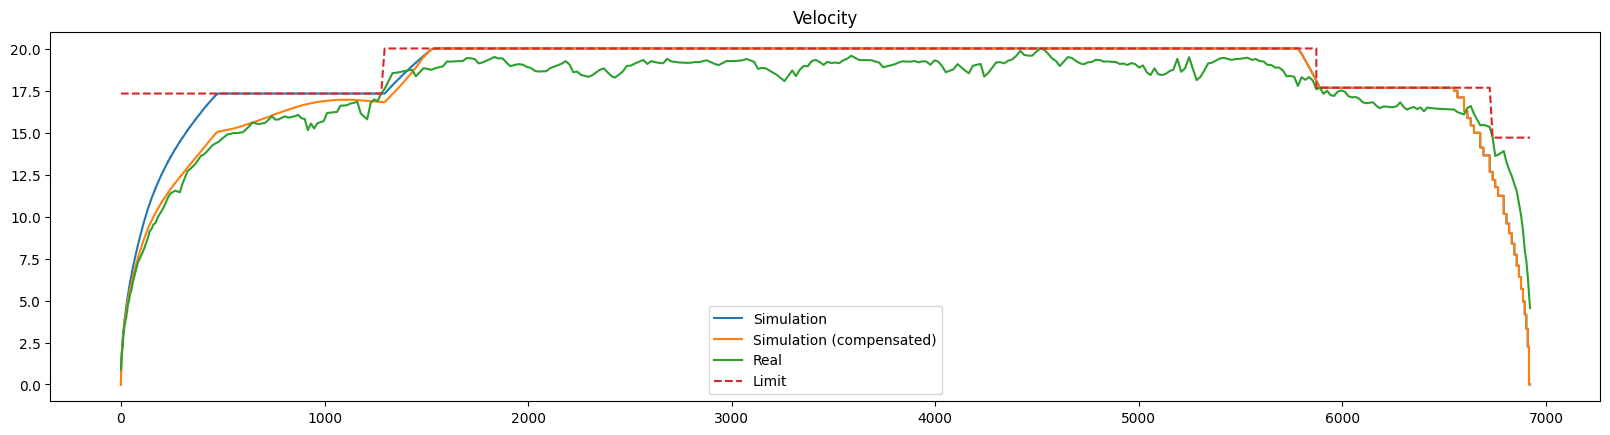

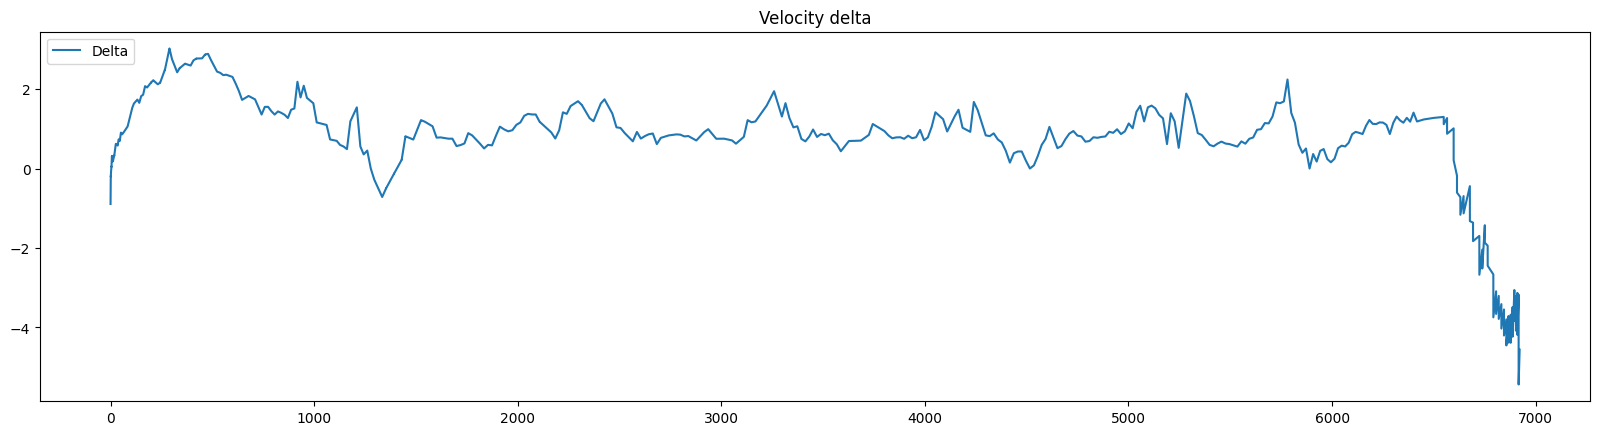

DTW: 342.3214779018422
{'station_start': 'Moravský Beroun', 'start': 6956, 'station_end': 'Dětřichov n.Bystřicí', 'end': 8429}


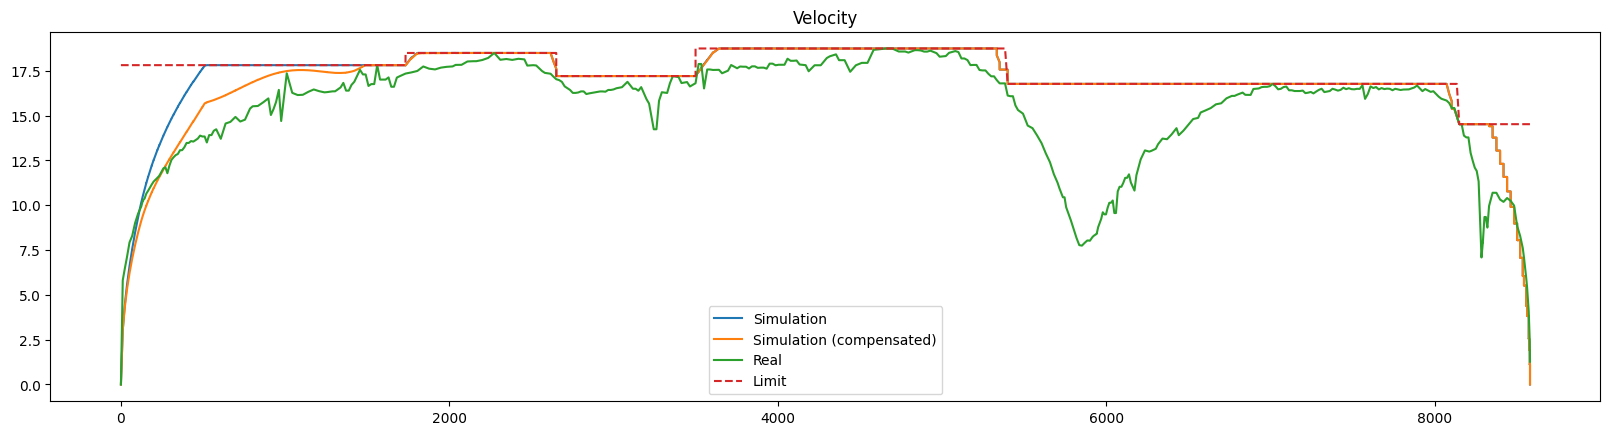

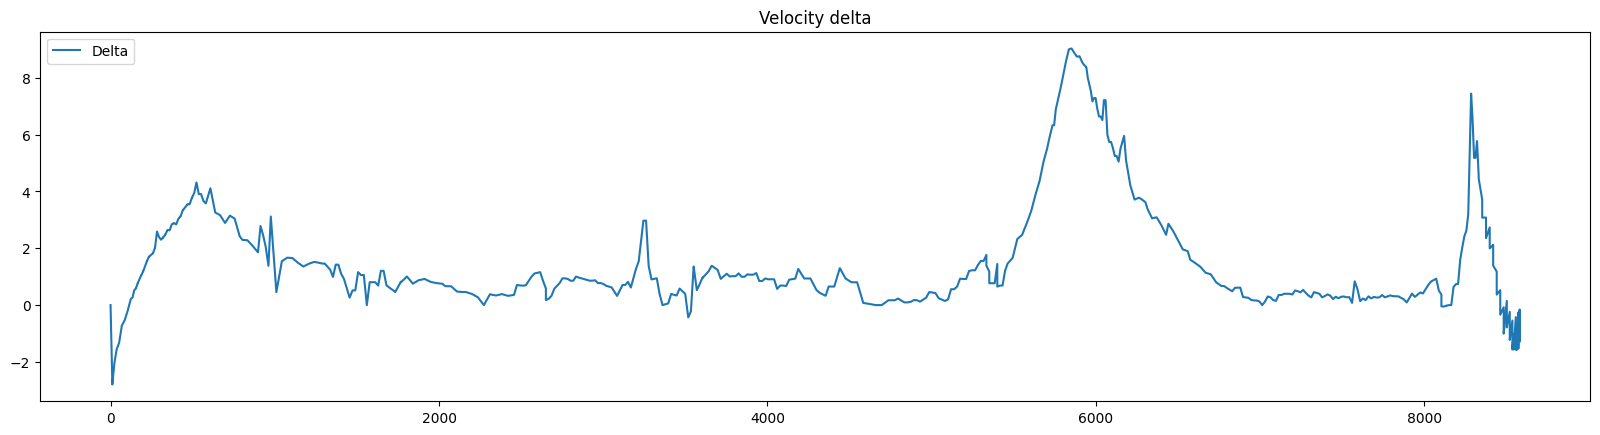

DTW: 1716.8984814223772
{'station_start': 'Dětřichov n.Bystřicí', 'start': 8506, 'station_end': 'Lomnice u Rýmařova', 'end': 9192}


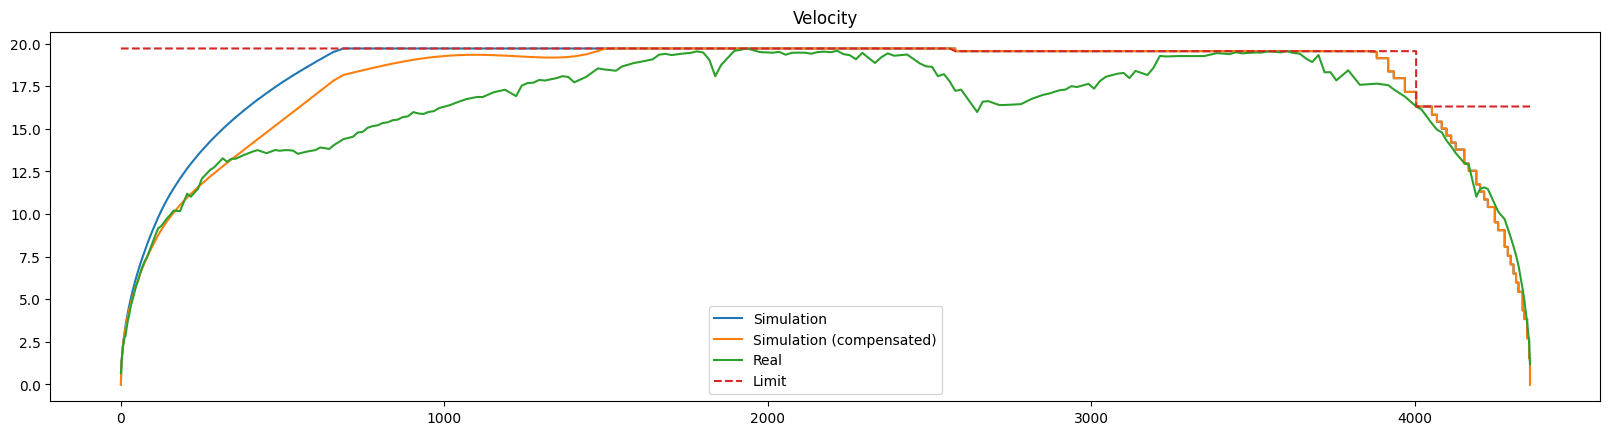

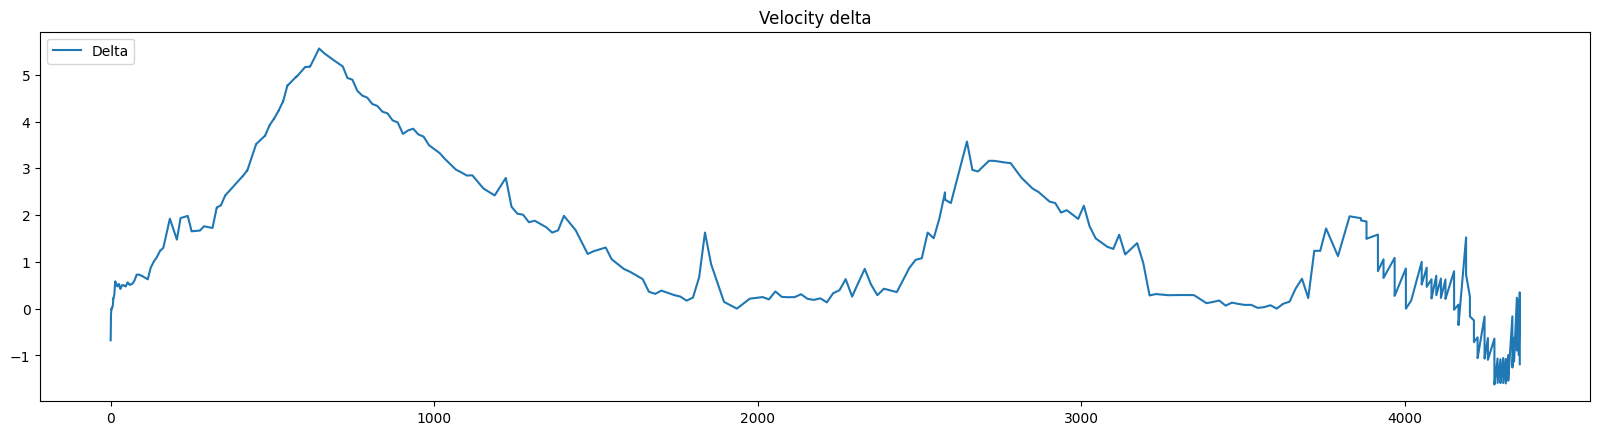

DTW: 338.7781052097331
{'station_start': 'Lomnice u Rýmařova', 'start': 9258, 'station_end': 'Valšov', 'end': 10392}


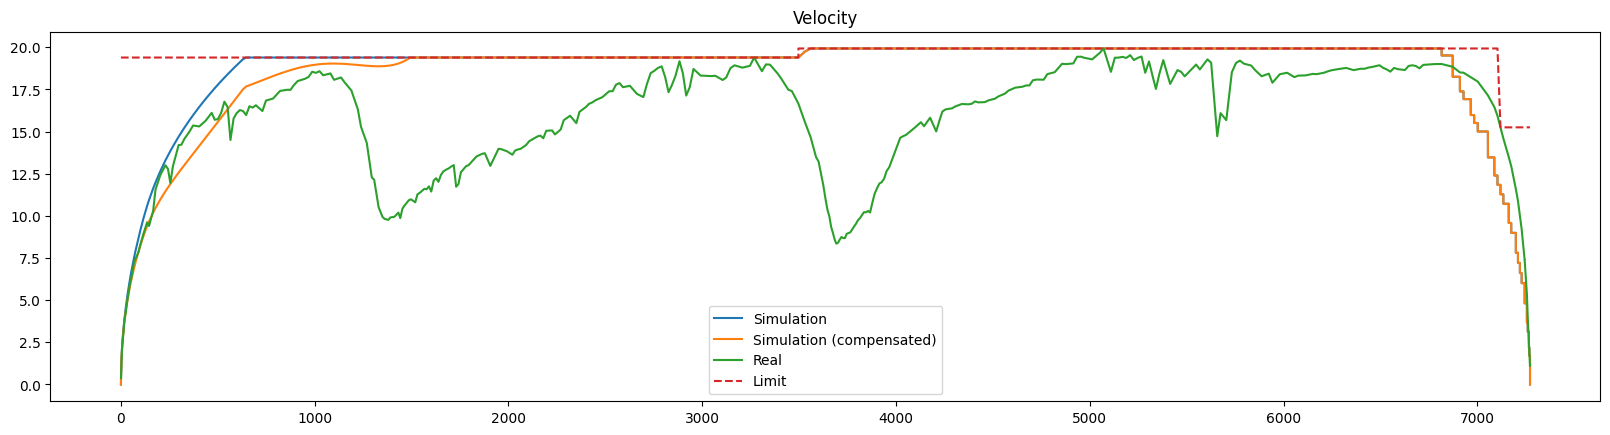

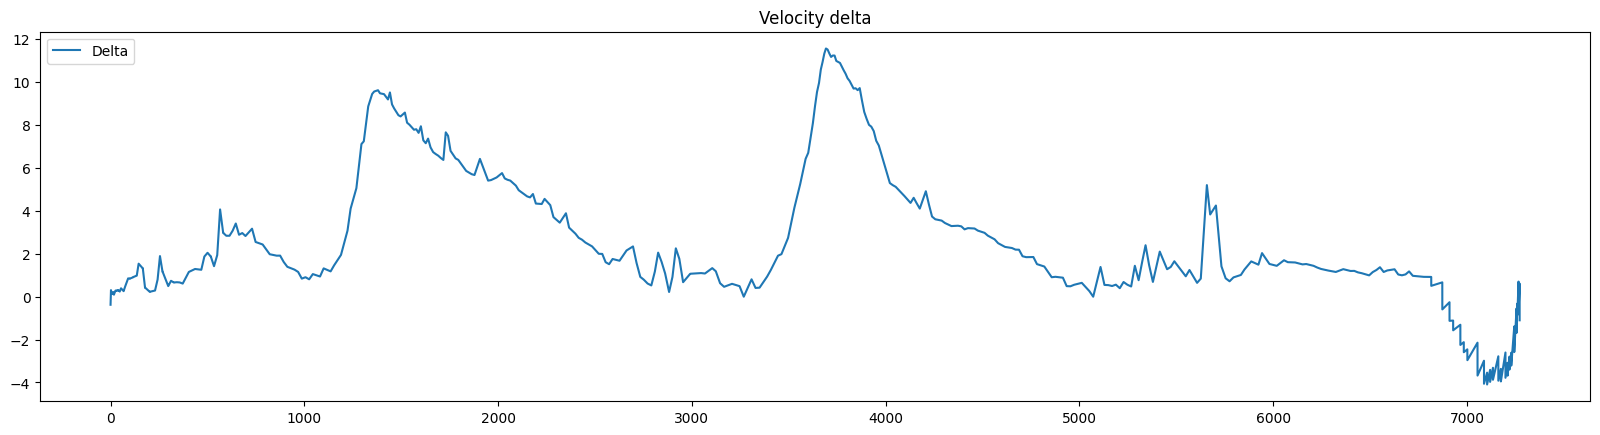

DTW: 1973.0872712631387
{'station_start': 'Valšov', 'start': 10474, 'station_end': 'Bruntál', 'end': 11614}


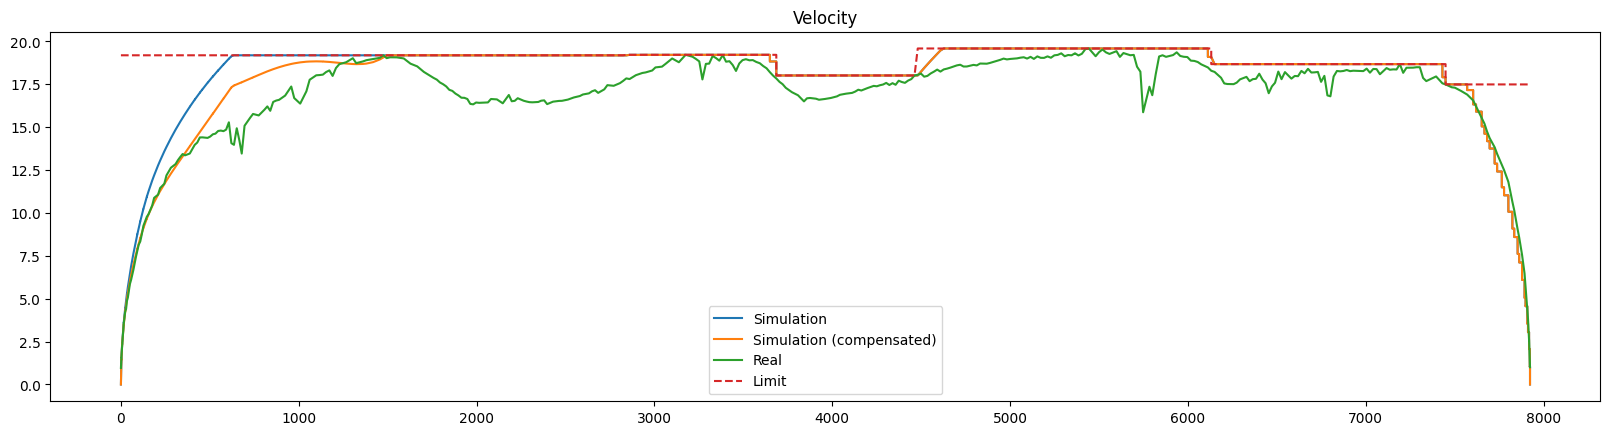

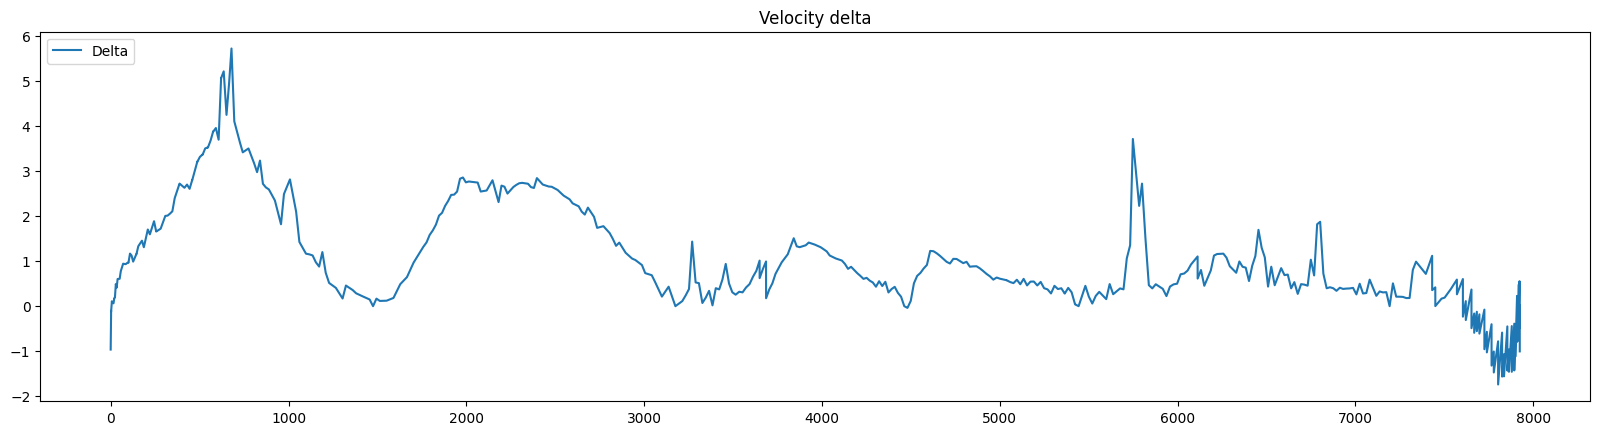

DTW: 697.7796182747228
{'station_start': 'Bruntál', 'start': 11788, 'station_end': 'Milotice n.Opavou', 'end': 13312}


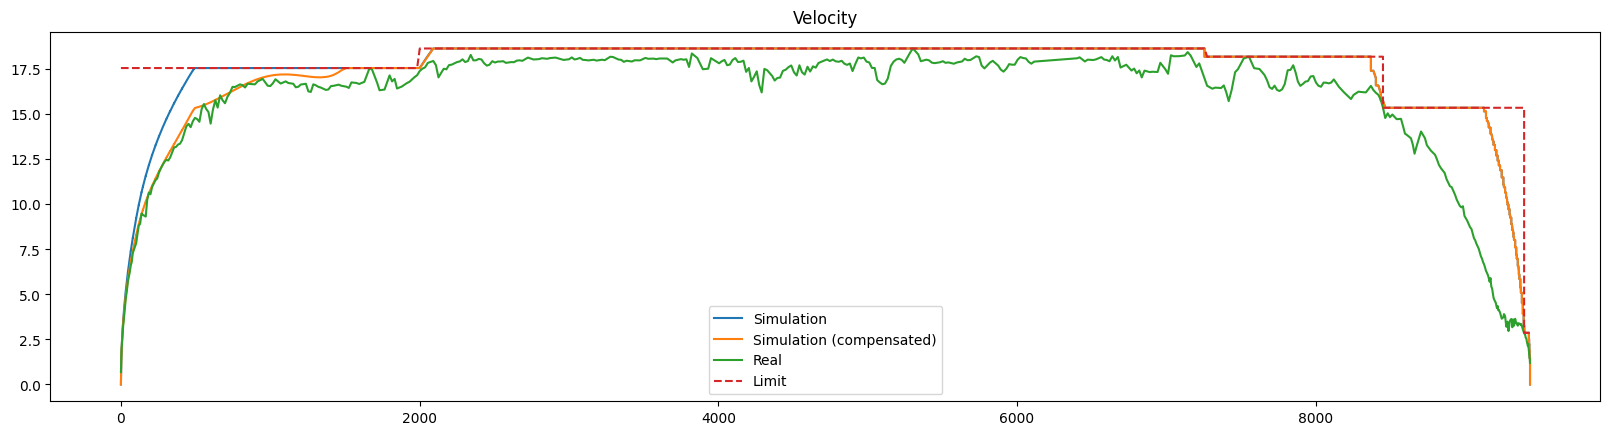

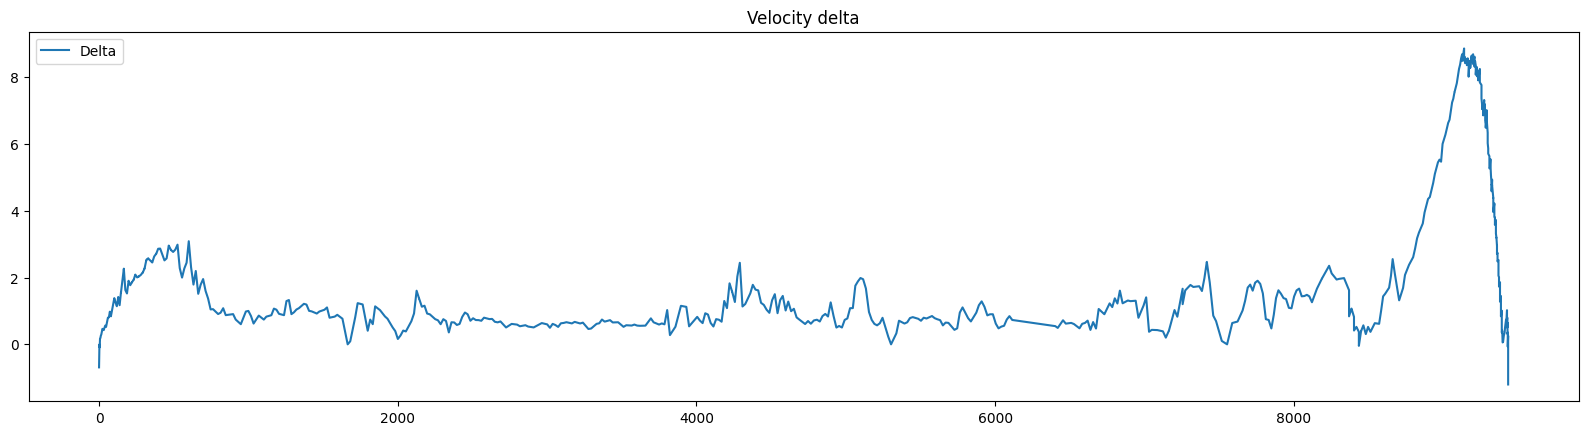

DTW: 650.0640751577174
{'station_start': 'Milotice n.Opavou', 'start': 13403, 'station_end': 'Krnov', 'end': 15313}


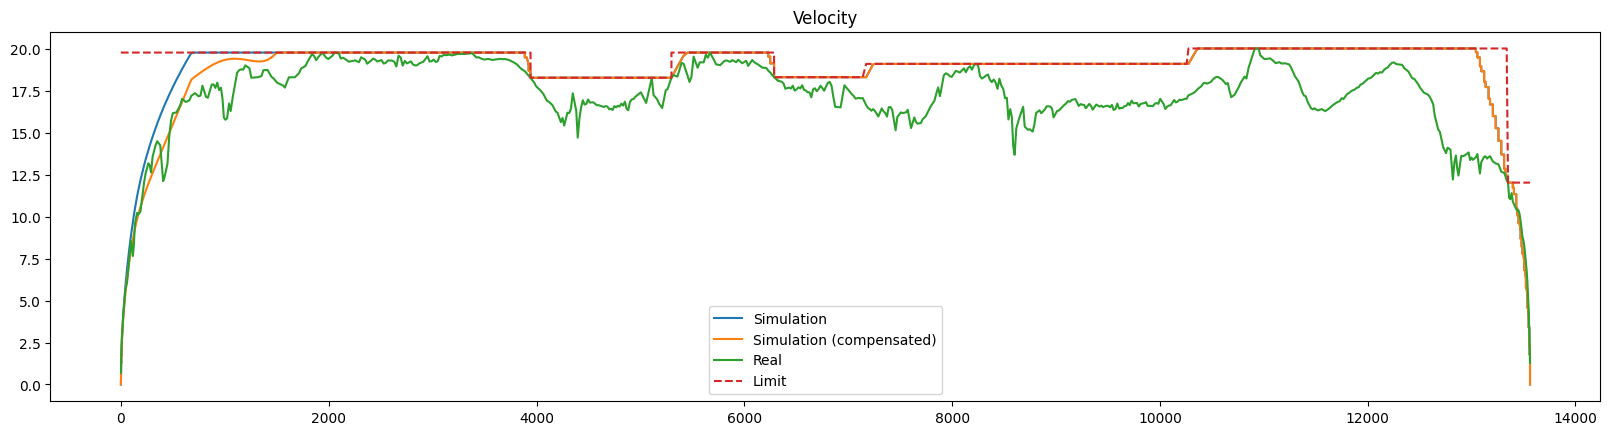

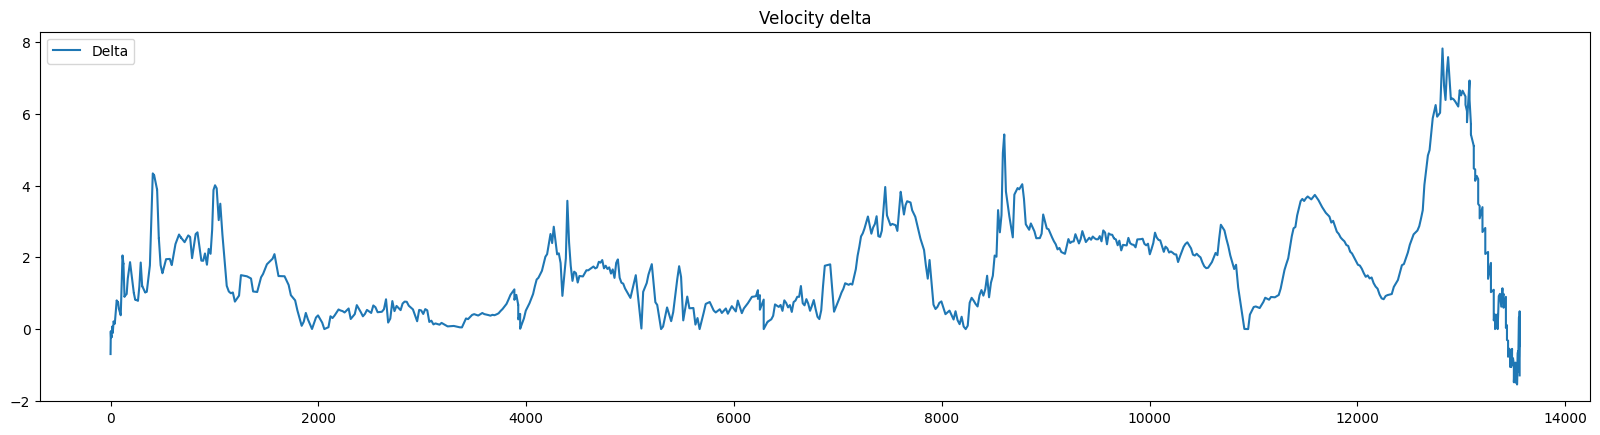

DTW: 1552.358250524192
{'station_start': 'Krnov', 'start': 17439, 'station_end': 'Krnov-Cvilín', 'end': 17962}


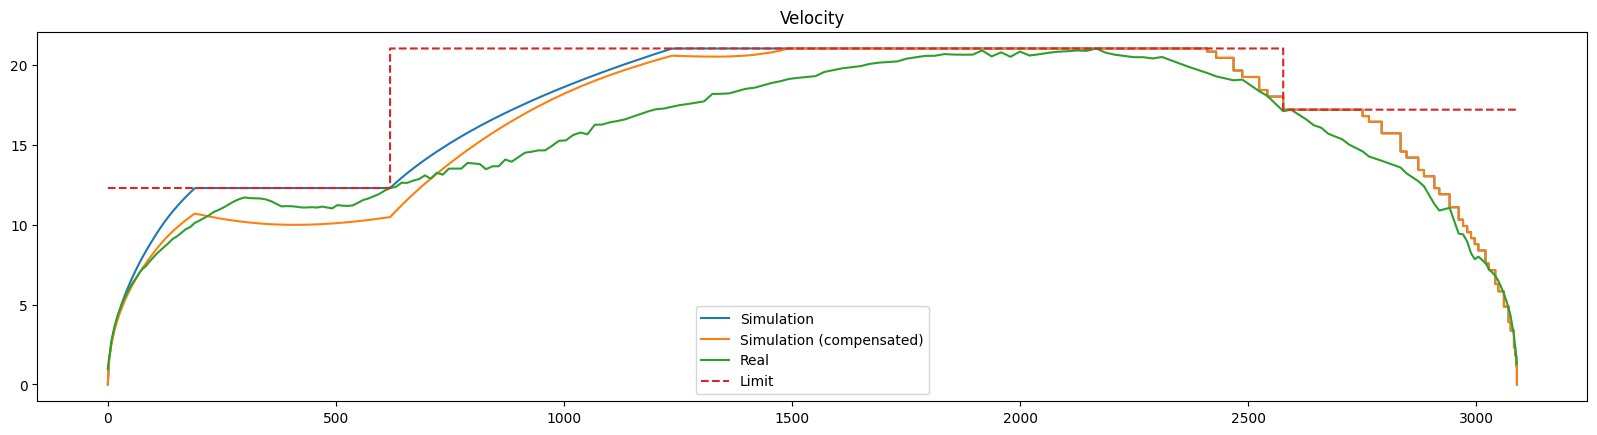

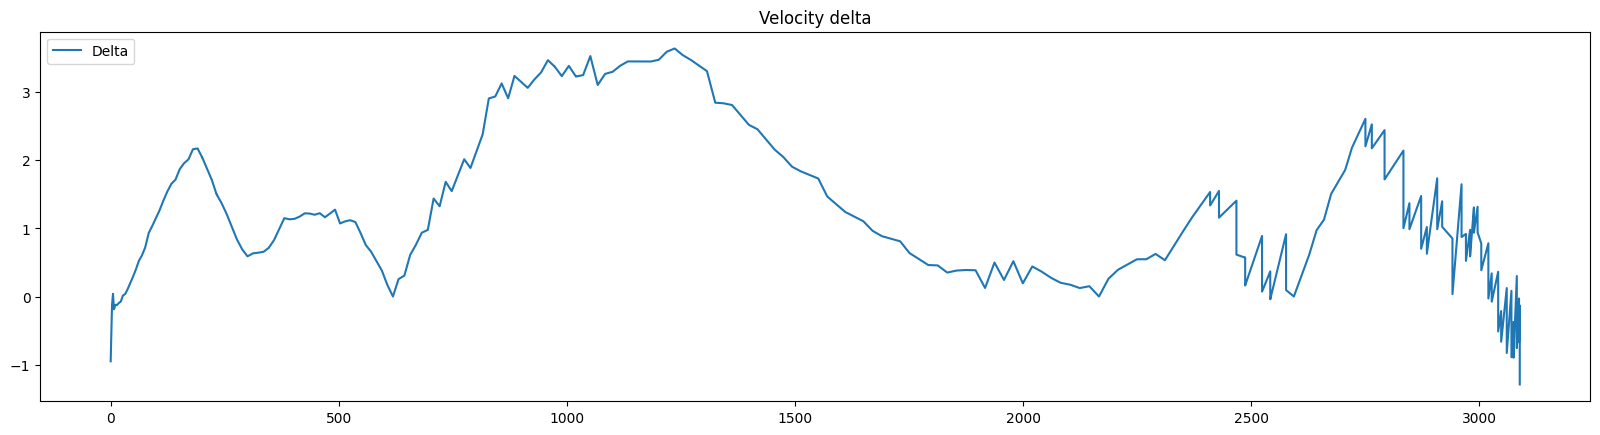

DTW: 73.20647979106558
{'station_start': 'Krnov-Cvilín', 'start': 18070, 'station_end': 'Opava západ', 'end': 20510}


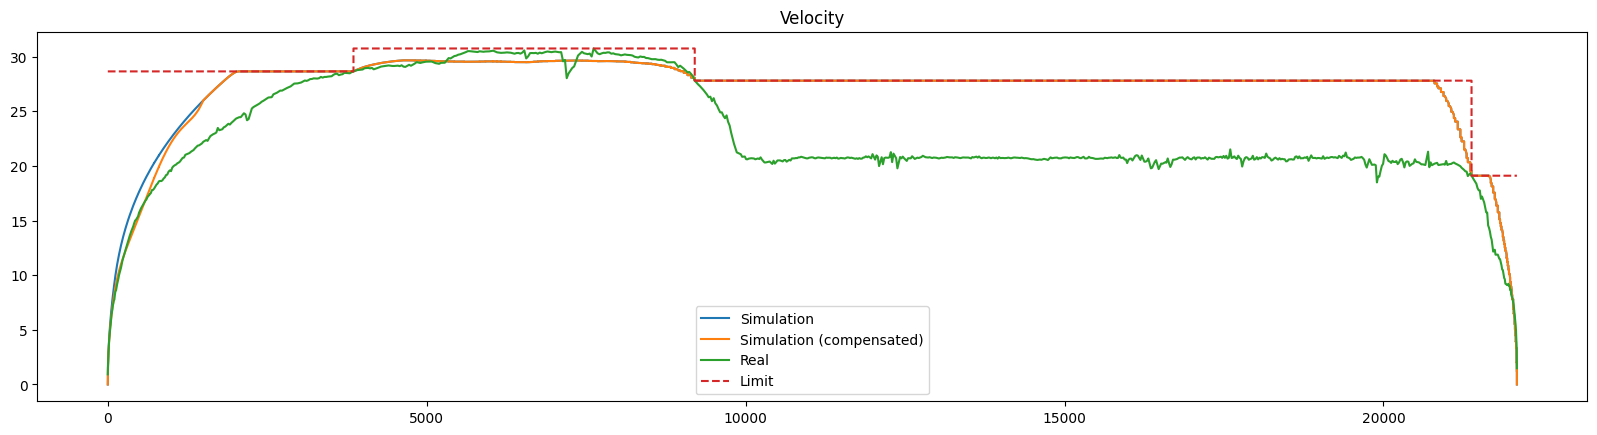

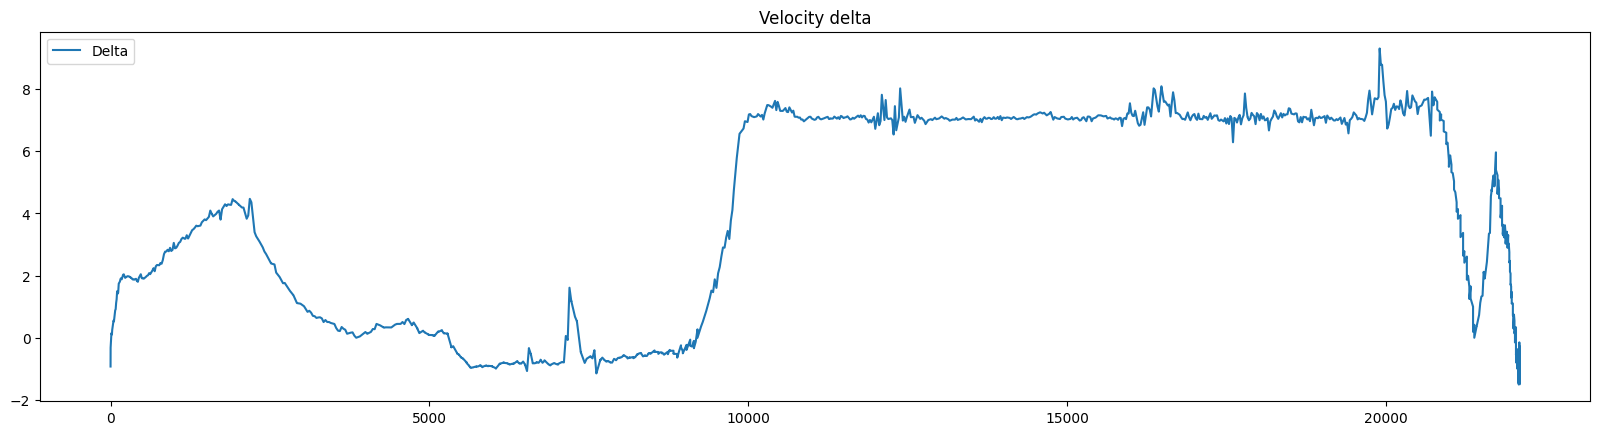

DTW: 1982.7582749570638
{'station_start': 'Opava západ', 'start': 20607, 'station_end': 'Opava východ', 'end': 21325}


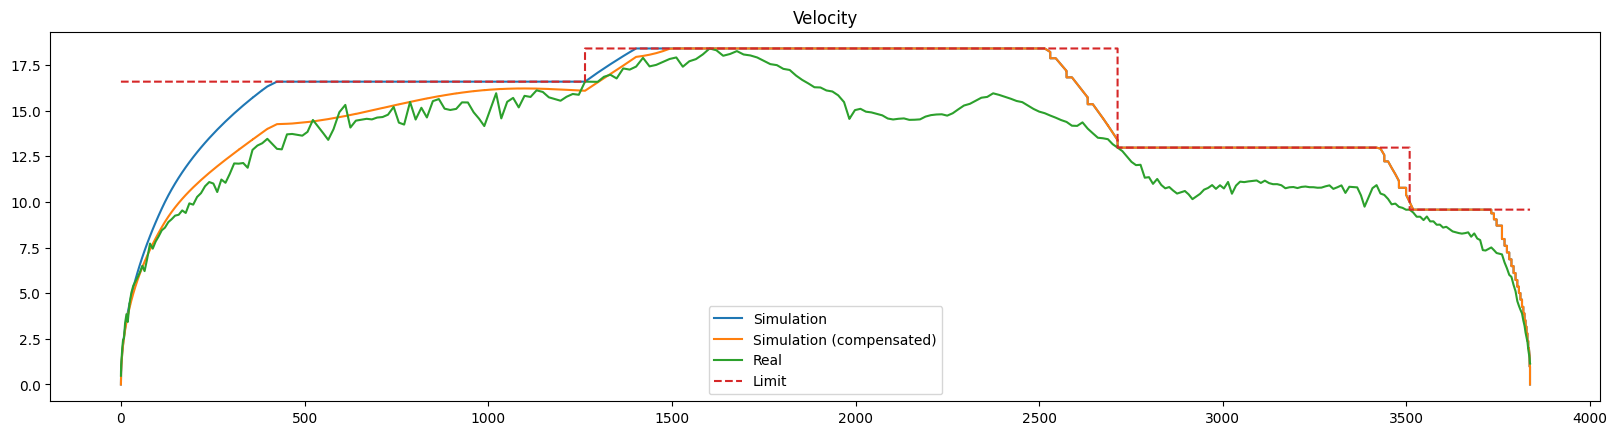

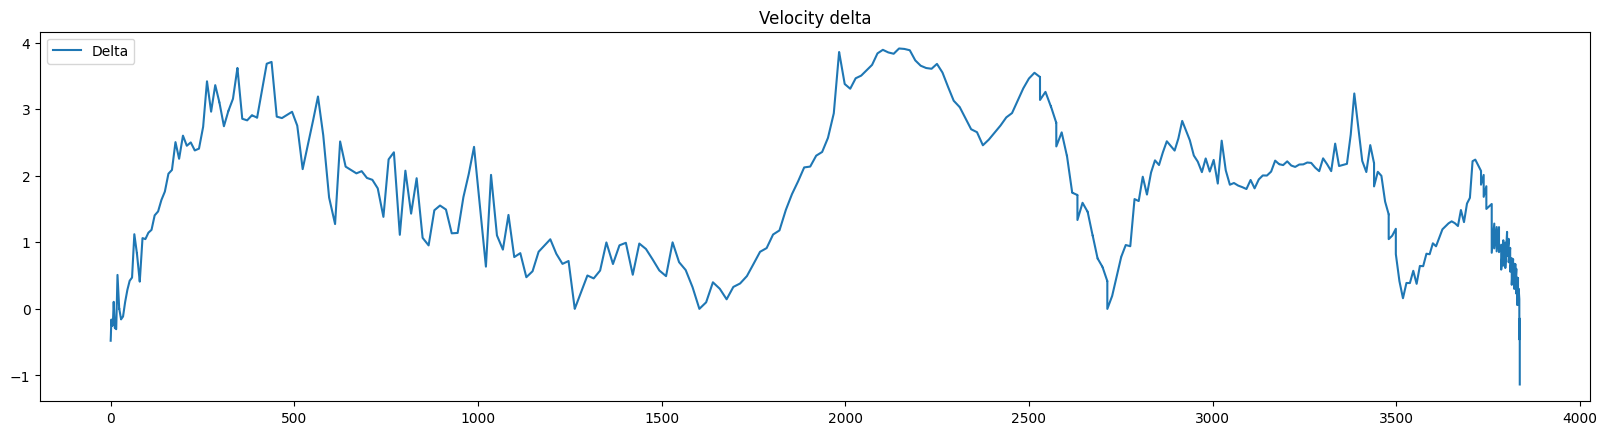

DTW: 142.98696329982823


Map(center=[49.763023376464844, 17.59451961517334], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [16]:
station_ranges = get_station_ranges(df2, [
    "Opava východ",
    "Opava západ",
    "Krnov-Cvilín",
    "Krnov",
    "Milotice n.Opavou",
    "Bruntál",
    "Valšov",
    "Lomnice u Rýmařova",
    "Dětřichov n.Bystřicí",
    "Moravský Beroun",
    "Domašov n.Bystřicí",
    "Hlubočky-Mar.Údolí",
    "Olomouc hl.n."
][::-1])
print(len(station_ranges))

compare_station_ranges(
    df2, station_ranges, "Opava-Olomouc/um7/um7capture",
    diesel_params, diesel_params_no_comp, diesel_train_params)

#### Opava západ ➡️ Krnov-Cvilín

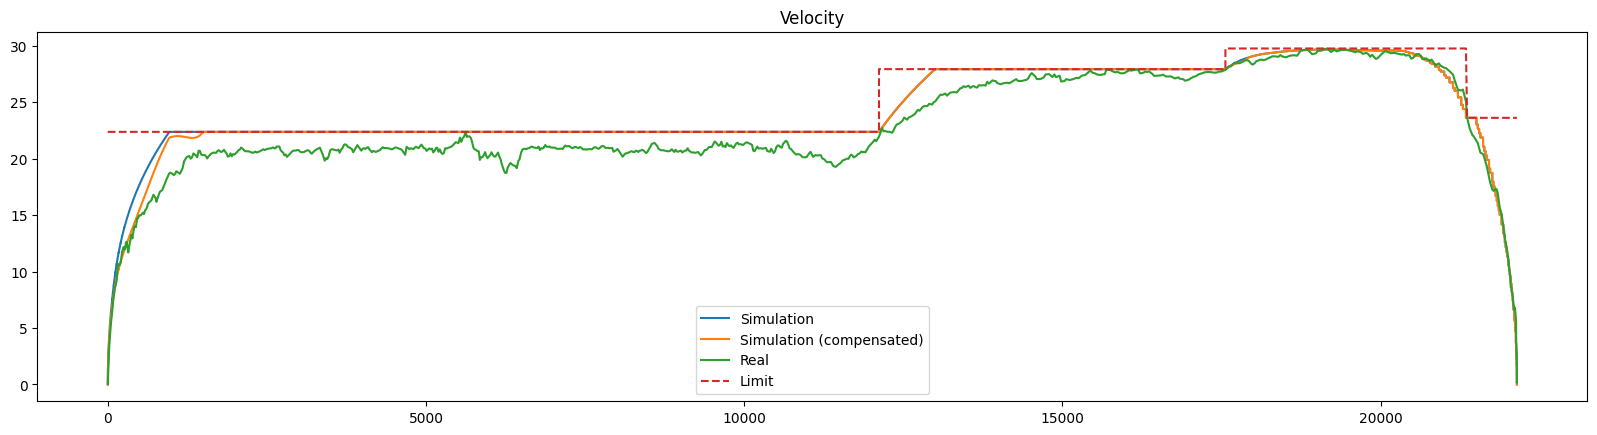

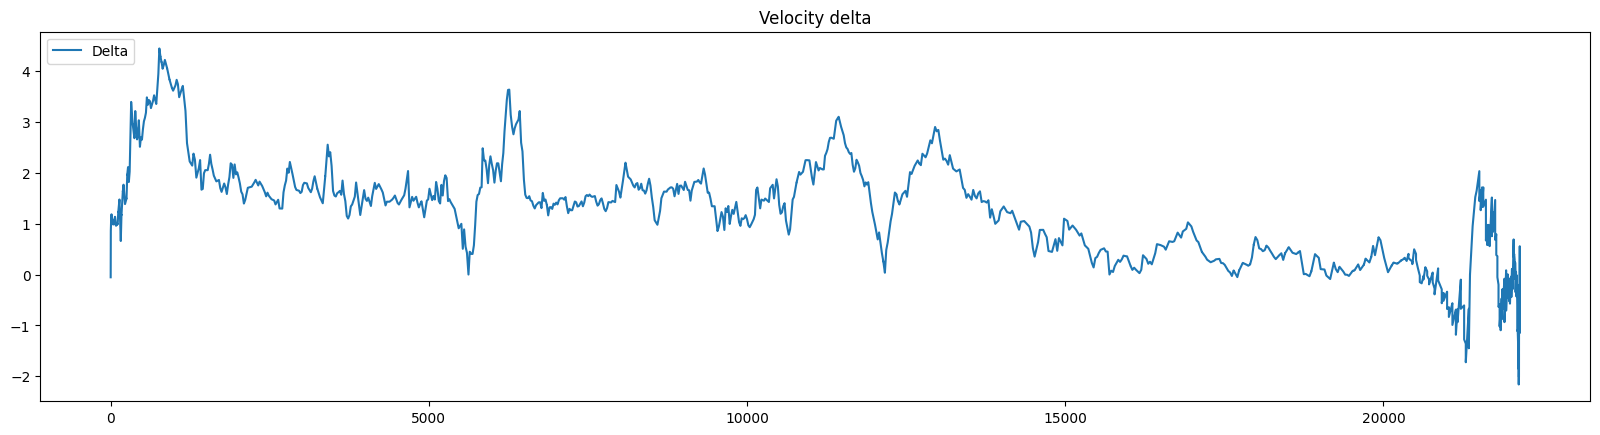

DTW: 1541.676396396965


Map(center=[50.016578674316406, 17.80017852783203], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [17]:
df_slice = df.loc[1080:3530] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 112.329, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson,
    diesel_params,
    diesel_params_no_comp,
    diesel_train_params
)

#### Krnov-Cvilín ➡️ Krnov

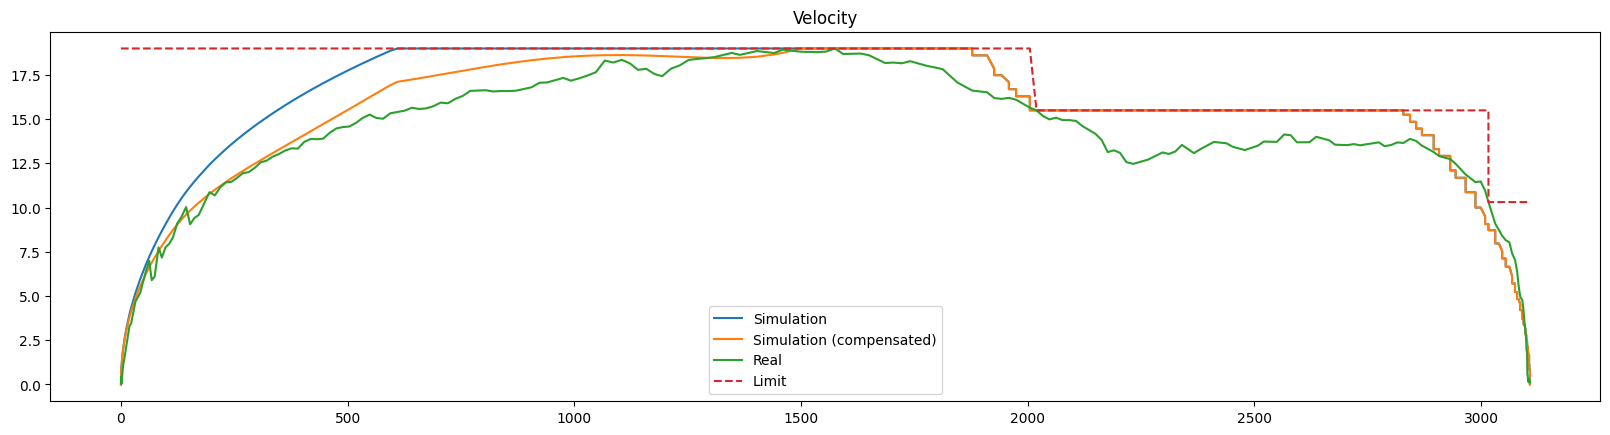

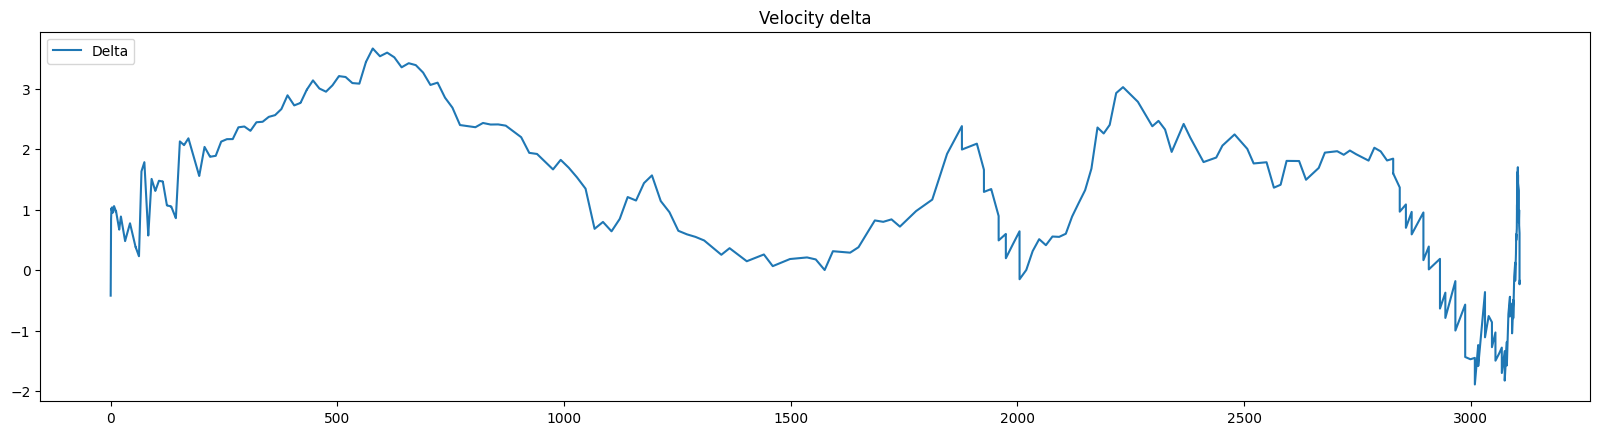

DTW: 129.3296658546941


Map(center=[50.09158134460449, 17.697911262512207], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [18]:
df_slice = df.loc[3680:4280] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 90.213, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson,
    diesel_params,
    diesel_params_no_comp,
    diesel_train_params
)

#### Krnov ➡️ Milotice n.Opavou

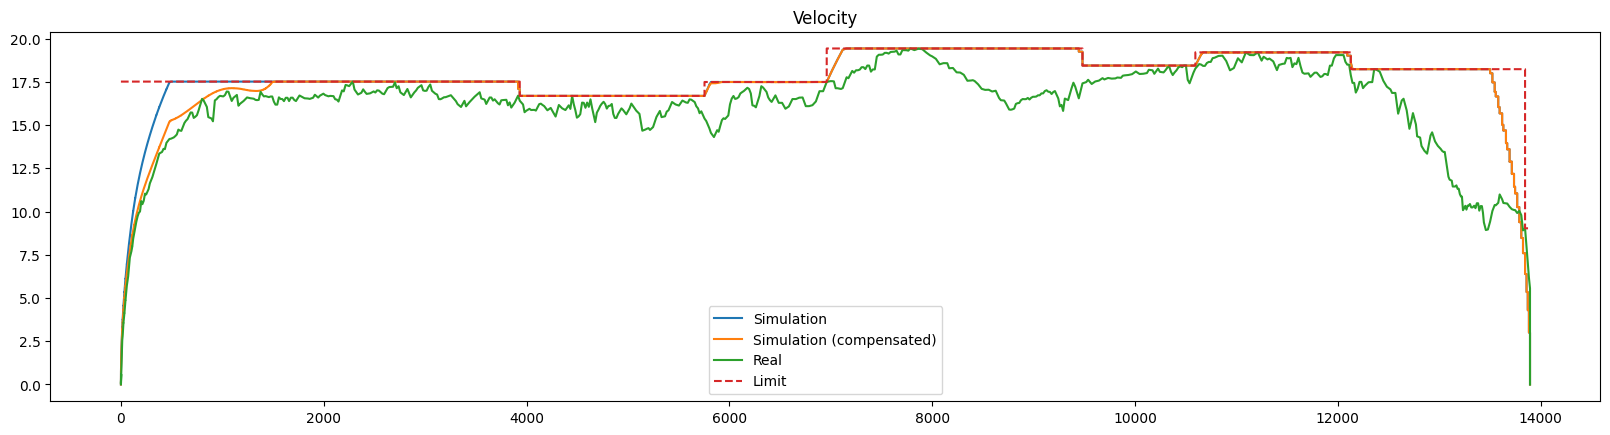

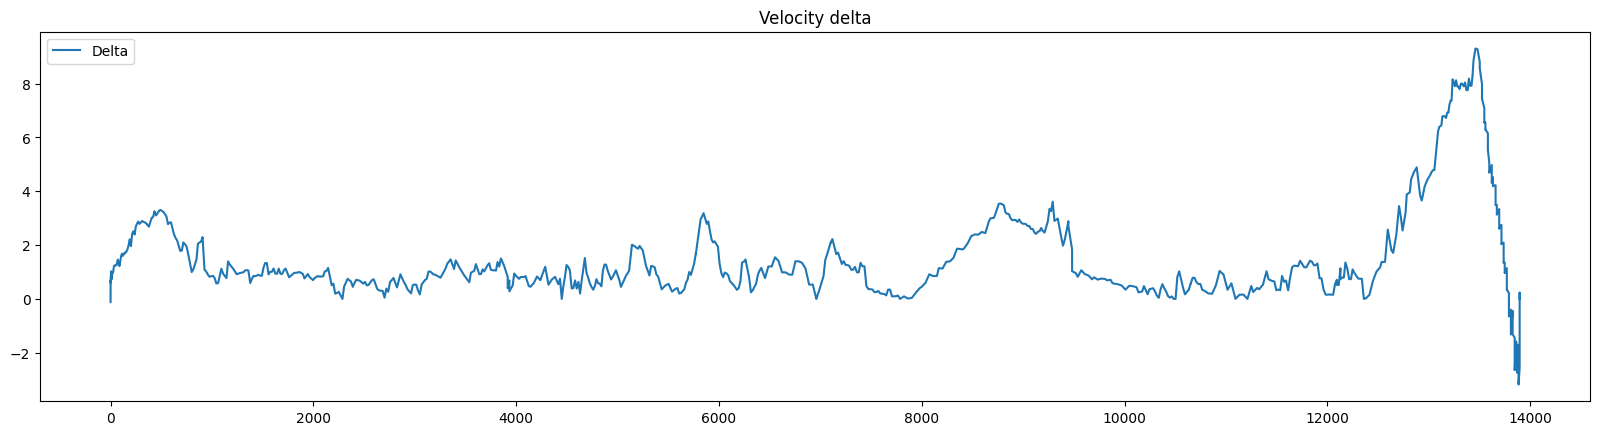

DTW: 1323.854743333105


Map(center=[50.0518741607666, 17.620561599731445], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [19]:
df_slice = df.loc[5570:7770] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 87.056, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_06-26-06_krnov-milotice.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson,
    diesel_params,
    diesel_params_no_comp,
    diesel_train_params
)

#### Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí

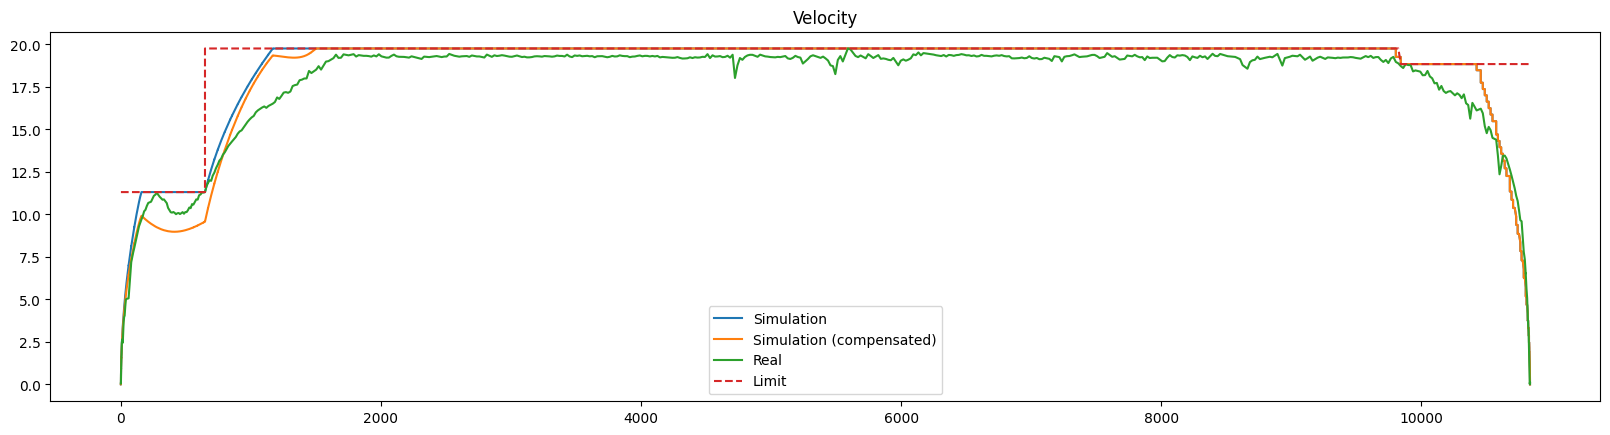

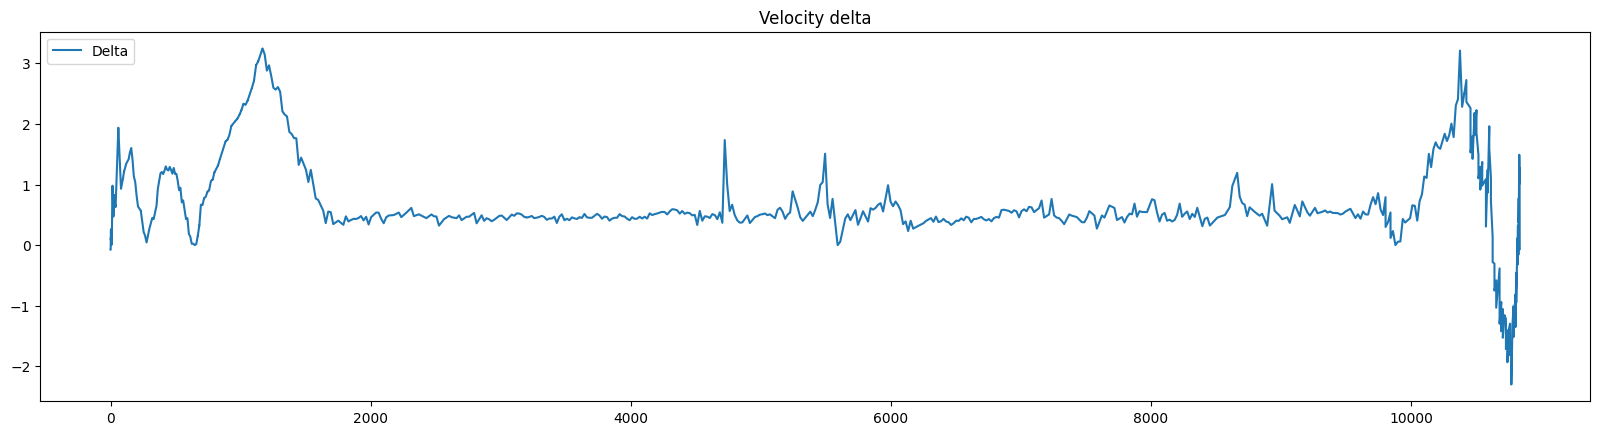

DTW: 557.15314552406


Map(center=[49.602705001831055, 17.336840629577637], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [20]:
df_slice = df2.loc[1120:2600] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 0.440, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json", True)
infer_velocity(df_slice, 10)

output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_09-04-10_olomouc-hlubocky.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson,
    diesel_params,
    diesel_params_no_comp,
    diesel_train_params
)

#### Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí

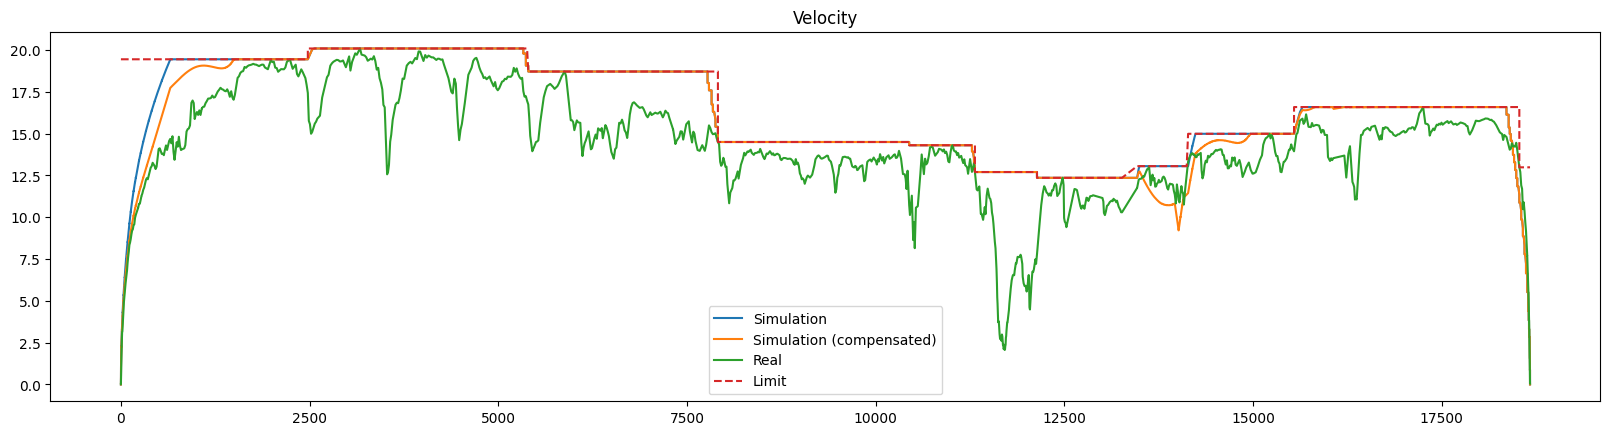

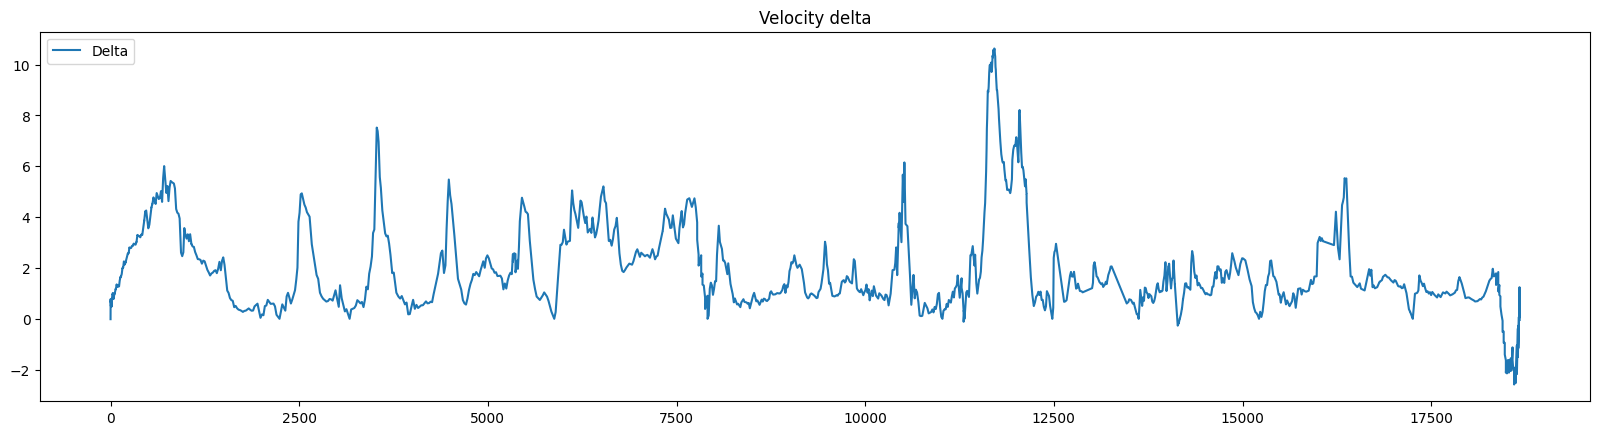

DTW: 3901.0394613057715


Map(center=[49.67659950256348, 17.419564247131348], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [21]:
df_slice = df2.loc[2670:5730] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 10.846, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json", True)
infer_velocity(df_slice, 10)

output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_09-04-10_hlubocky-domasov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson,
    diesel_params,
    diesel_params_no_comp,
    diesel_train_params
)

#### Milotice n.Opavou ➡️ Bruntál (☠️ noisy data)

In [22]:
# df_slice = df.loc[8335:9787] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 73.260, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json")

In [23]:
# output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_06-26-06_milotice-bruntal.geojson"
# if PREP_GEOJSONS:
#     prep({
#         # "input": "NOT NEEDED",
#         "output": output_geojson,
#         "host": "localhost",
#         "dbname": "railway_mapdb",
#         "dbuser": "postgres",
#         "dbpass": "mysecretpassword",
#         "dbtable": "train_testing_data"
#     }, df=df_slice)

In [24]:
# importlib.reload(tconsumption)

# processed_sections.append({"df": df_slice, "geojson": output_geojson})
# compare_data(
#     df_slice,
#     output_geojson,
#     diesel_params,
#     diesel_params_no_comp,
#     diesel_train_params
# )

#### Bruntál ➡️ Valšov (☠️ noisy data)

In [25]:
# df_slice = df.loc[10100:10300] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 56.370, DATA_PATH + "Opava-Olomouc/velocity-data/310-pj.json")

In [26]:
# output_geojson = DATA_PATH + "Opava-Olomouc/um7/um7capture_2023-09-29_06-26-06_bruntal-valsov.geojson"
# if PREP_GEOJSONS:
#     prep({
#         # "input": "NOT NEEDED",
#         "output": output_geojson,
#         "host": "localhost",
#         "dbname": "railway_mapdb",
#         "dbuser": "postgres",
#         "dbpass": "mysecretpassword",
#         "dbtable": "train_testing_data"
#     }, df=df_slice)

In [27]:
# importlib.reload(tconsumption)

# processed_sections.append({"df": df_slice, "geojson": output_geojson})
# compare_data(
#     df_slice,
#     output_geojson,
#     diesel_params,
#     diesel_params_no_comp,
#     diesel_train_params
# )

### 📱 Data z telefonu

In [28]:
# Find two stations (ramp up and ramp down)
df_phone_loc = pd.read_csv(DATA_PATH + "Opava-Olomouc/seidl-telefon/Location.csv", delimiter=",")[220:860]
df_phone_loc.reset_index(inplace=True, drop=True)
start_time = df_phone_loc["time"].iloc[0]
stop_time = df_phone_loc["time"].iloc[-1]

# Find acceleration in the same timeframe
# (sampling rate different - that's is why like this)
df_phone_acc = pd.read_csv(DATA_PATH + "Opava-Olomouc/seidl-telefon/Accelerometer.csv", delimiter=",")
df_phone_acc = df_phone_acc[(df_phone_acc["time"] >= start_time) & (df_phone_acc["time"] <= stop_time)]
df_phone_acc.reset_index(inplace=True, drop=True)
df_phone_acc

time  seconds_elapsed         z         y         x
0      1695978715934436000       202.310436 -0.022504  0.057136  0.004057
1      1695978715953393400       202.329393  0.001695  0.057180  0.008538
2      1695978715972351000       202.348351  0.003605  0.048180 -0.007852
3      1695978715991308300       202.367308  0.022114  0.032709  0.027355
4      1695978716010265900       202.386266 -0.015833  0.031453 -0.031993
...                    ...              ...       ...       ...       ...
33626  1695979352841621000       839.217621  0.028306  0.154919  0.006014
33627  1695979352860578300       839.236578  0.001878  0.145120  0.012852
33628  1695979352879535600       839.255536  0.018169  0.189503 -0.011000
33629  1695979352898493000       839.274493  0.015572  0.218727 -0.005773
33630  1695979352917450000       839.293450  0.008195  0.225367  0.018014

[33631 rows x 5 columns]

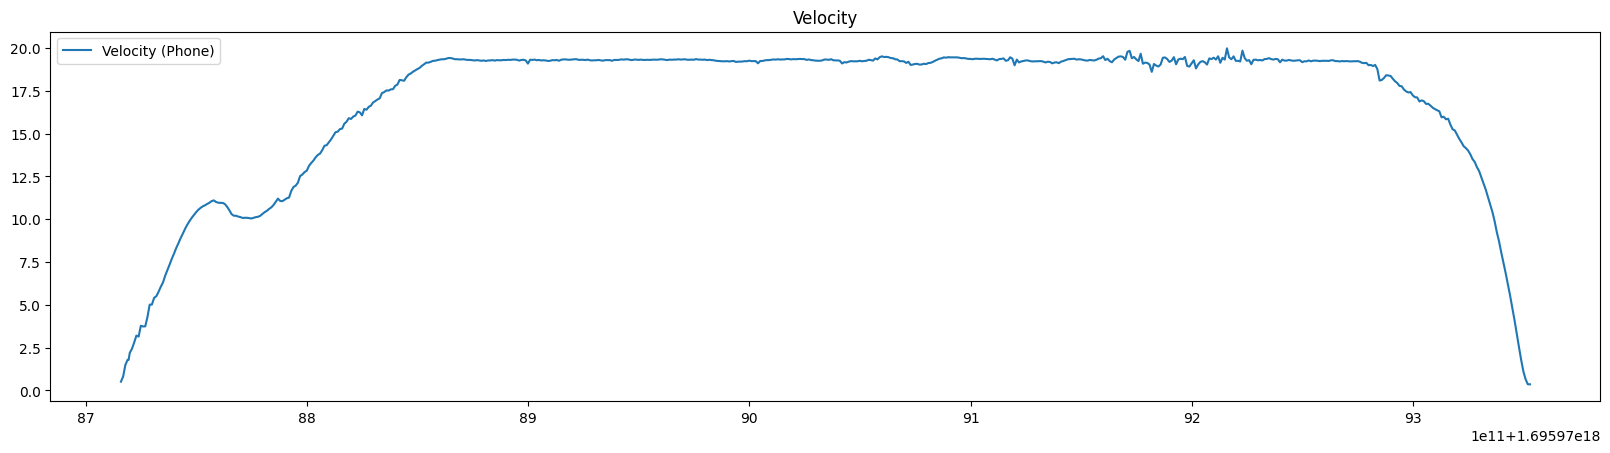

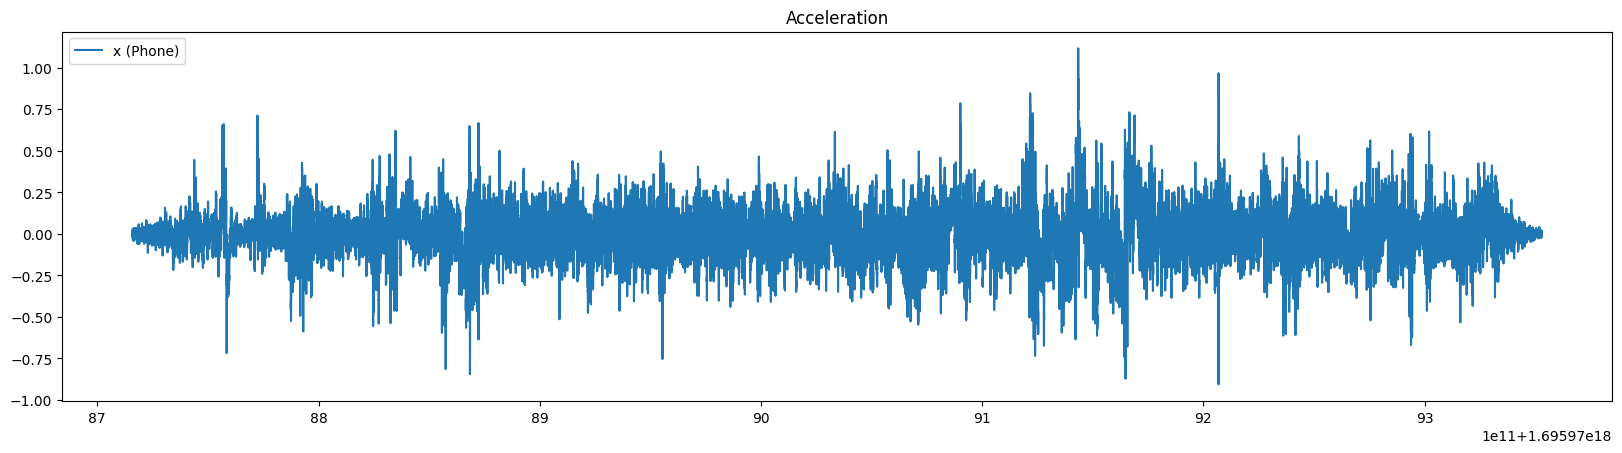

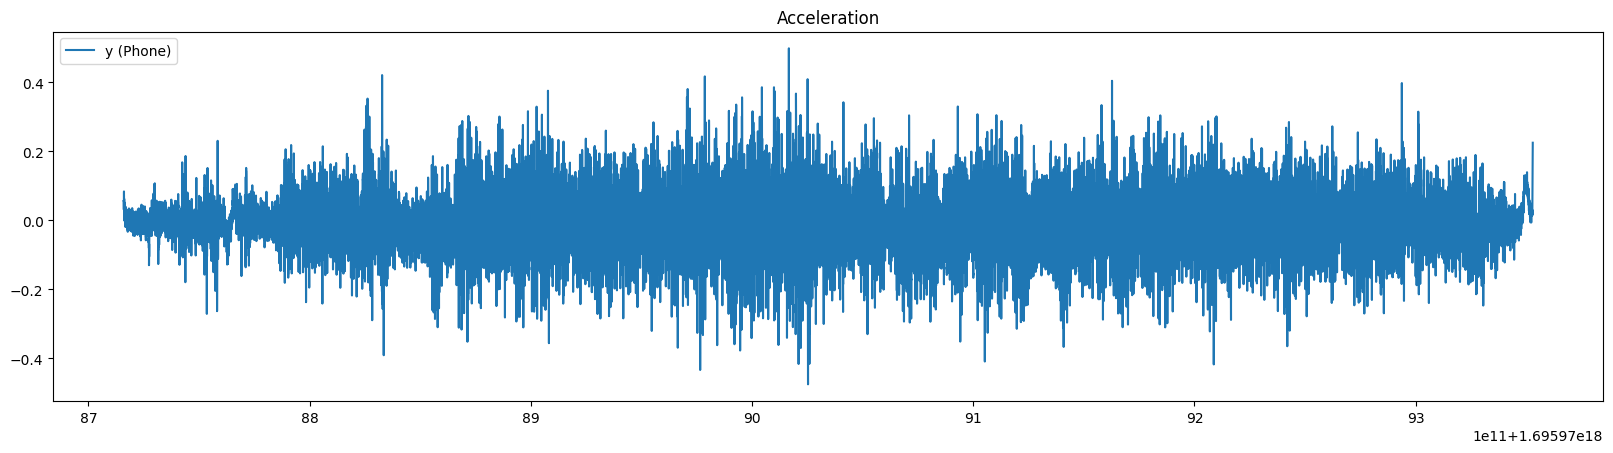

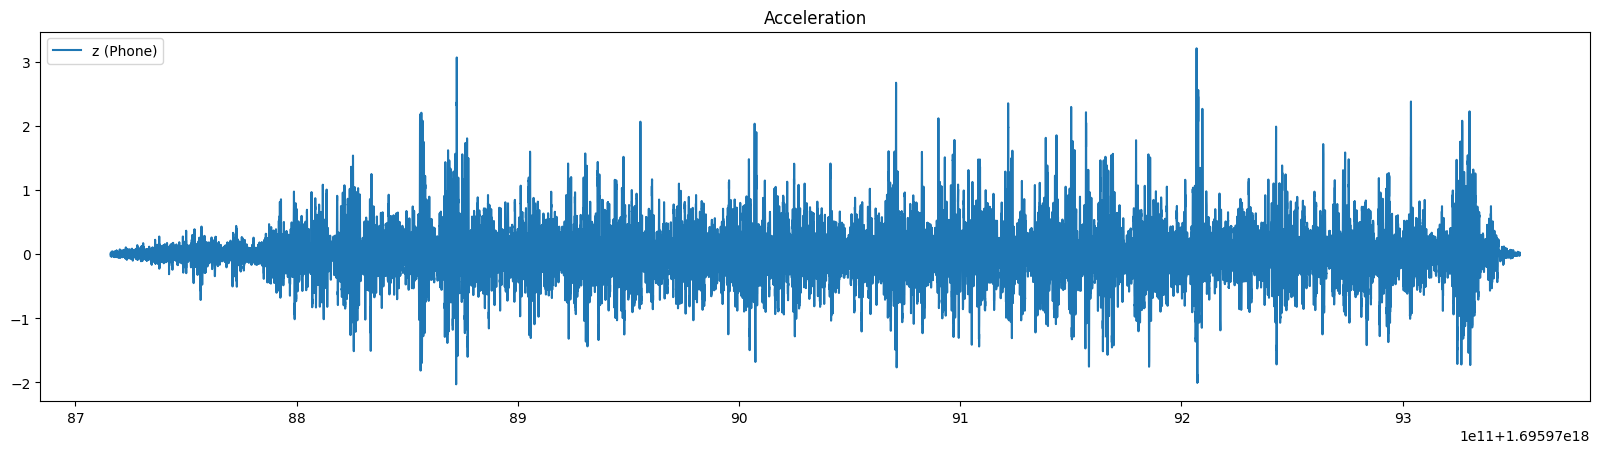

In [29]:
render_plot(
    "Velocity",
    df_phone_loc["time"],
    [df_phone_loc["speed"]],
    ["Velocity (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["x"]],
    ["x (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["y"]],
    ["y (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["z"]],
    ["z (Phone)"]
)

### 🇳🇴 Porovnání s norskou simulací

In [30]:
def map_velocity_2sim(points, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    dist_values = [0]
    for i,p in enumerate(points):
        if i+1 >= len(points):
            continue
        dist = tconsumption.calc_distance_two_points(p, points[i+1])
        dist_values.append(dist+dist_values[-1])

    max_velocities = []

    for d in dist_values:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            if first_offset*1000 - d < start_in_m:
                max_velocities.append(tv["value"])
                break

    return [x/3.6 for x in max_velocities]

def compare_data_2sim(df_sim, geojson_path: str, first_dist_offset, velocity_fp):
    # Calculated data
    c = tconsumption.Consumption()
    c.load_from_file(geojson_path)
    c.variable_params.update({
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98,
        "Compensation polynomial": None
    })
    c.max_velocities_in_mps = map_velocity_2sim(c.points, first_dist_offset, velocity_fp)

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 0

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    render_plot(
        "Energy",
        c.series["dist_values"],
        [energy_calculated],
        ["JN simulation", "Norwegian simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Norwegian energy",
        df_sim["distance"],
        [df_sim["Battery"]],
        ["Battery"],
        ["solid"]
    )

    # render_plot(
    #     "Norwegian energy",
    #     df_sim["distance"],
    #     [df_sim["Battery"], df_sim["Hydrogen"], df_sim["Diesel"], df_sim["OLE"]],
    #     ["Battery", "Hydrogen", "Diesel", "OLE"],
    #     ["solid"]*4
    # )

    render_plot(
        "Exerted force",
        c.series["dist_values"],
        [c.series["exerted_force_values"]],
        ["JN simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], c.max_velocities_in_mps+[c.max_velocities_in_mps[-1]]],
        ["JN simulation", "Max velocity"],
        ["solid", "dashed"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["JN simulation"],
        ["solid"]
    )

    print(f"JN simulation final energy: {energy_calculated[-1]}")
    print(f"Norwegian simulation final energy: {df_sim['Battery'].iloc[-1]}")

    dtw = fastdtw(energy_calculated, df_sim["Battery"])[0]
    print("DTW:", dtw)

In [31]:
if PREP_GEOJSONS:
    get_rail({
        "output": DATA_PATH + "Opava-Olomouc/norway-sim/opava-olomouc.geojson",
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
    }, 49002, True)

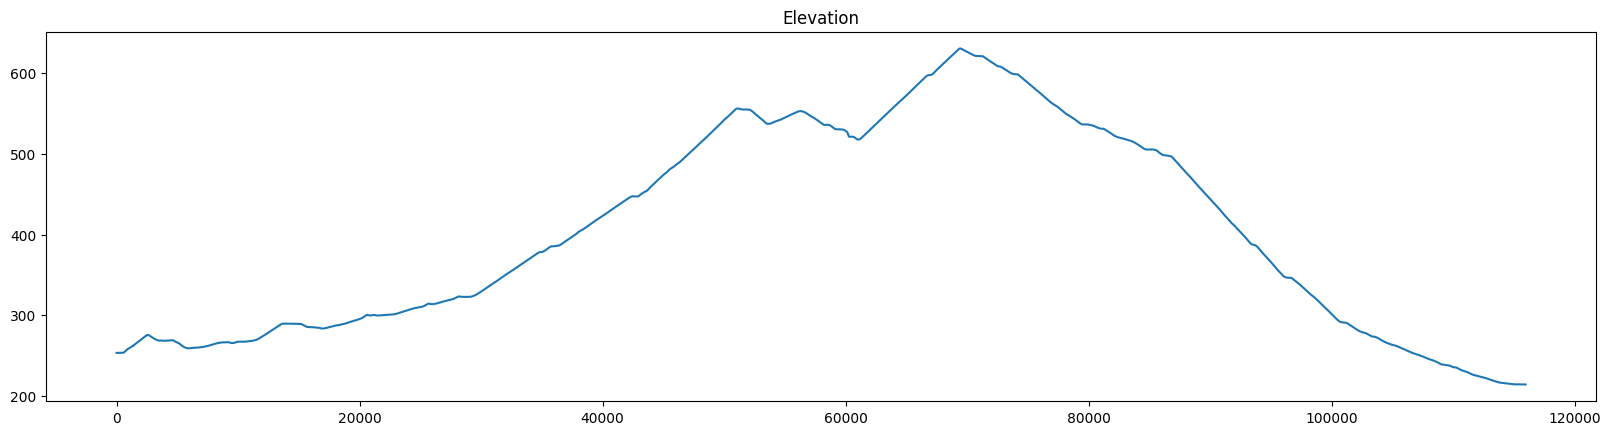

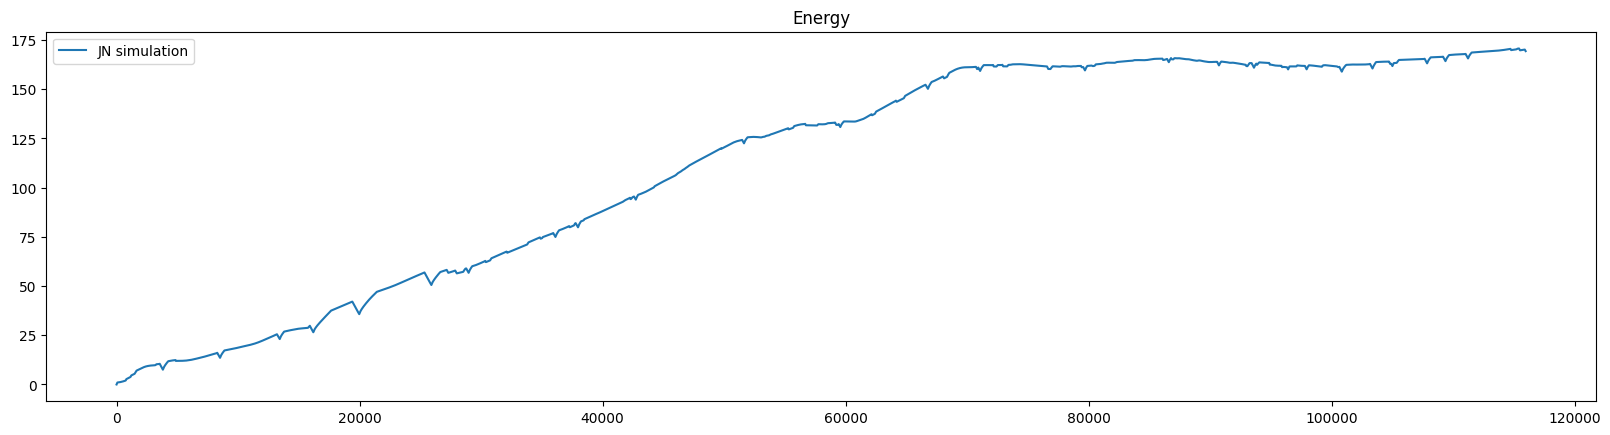

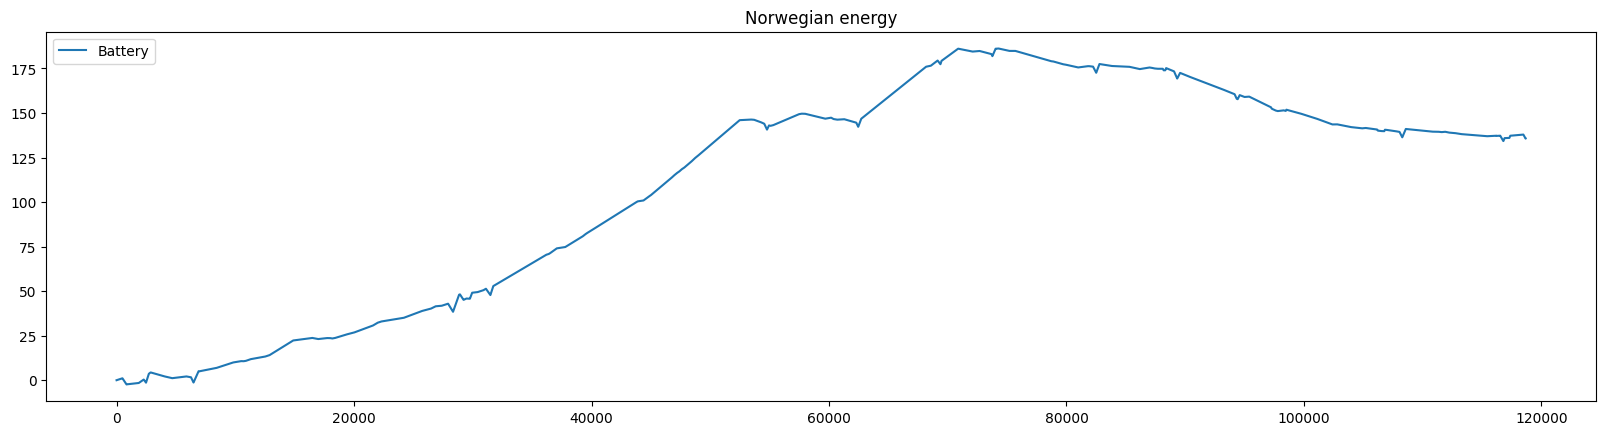

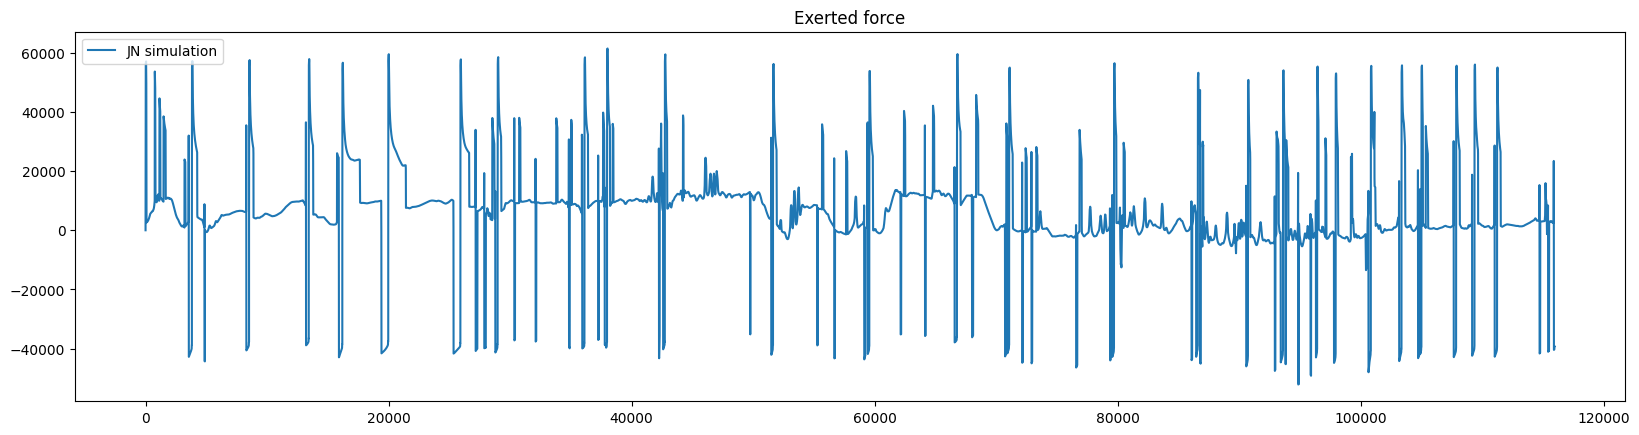

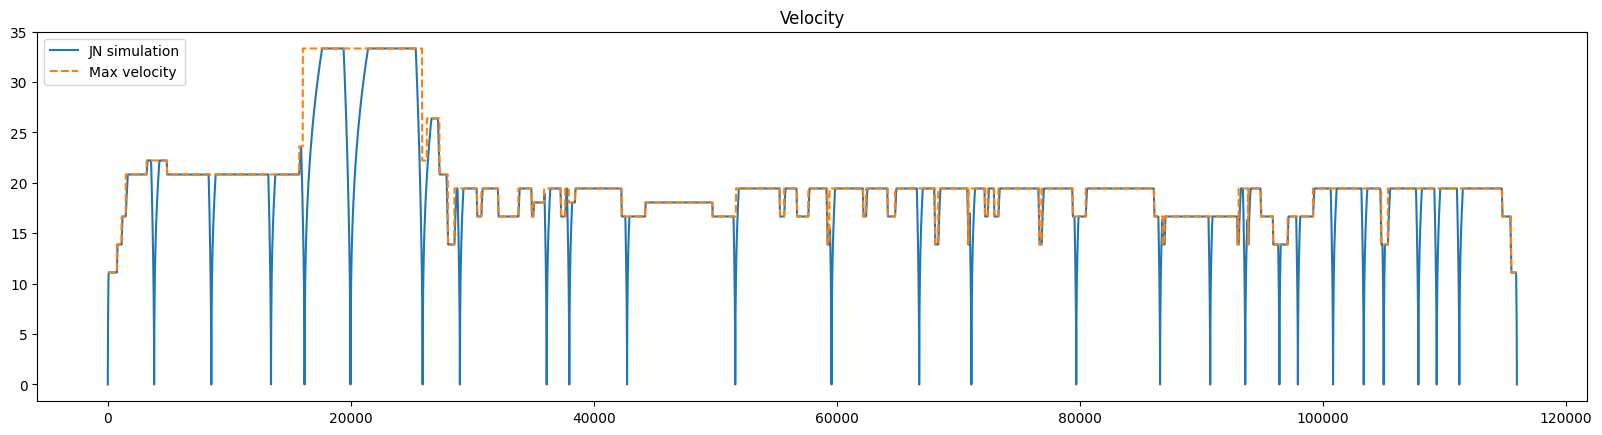

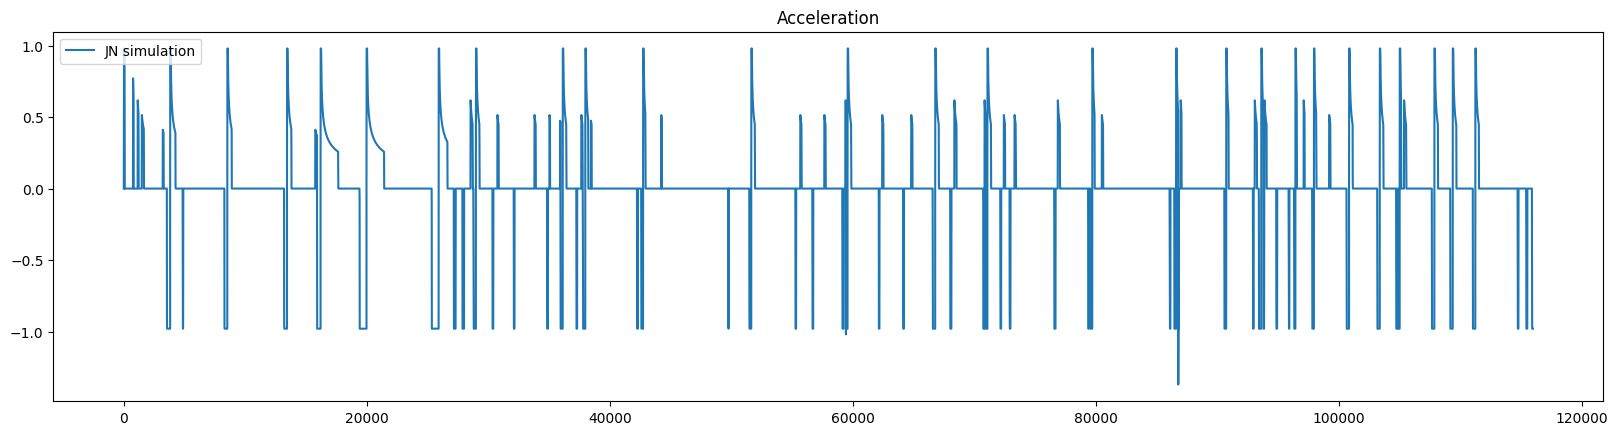

JN simulation final energy: 169.37162912867228
Norwegian simulation final energy: 135.61772263885865
DTW: 86344.02898256936


In [32]:
# Read and process
df_norway = pd.read_csv(DATA_PATH + "Opava-Olomouc/norway-sim/West_energy.csv", delimiter=",", header=[0,1])
df_norway.columns = [x[0] for x in df_norway.columns]
df_norway = df_norway.rename(columns={"Unnamed: 0_level_0": "distance"})

# Remove first few stations (Ostrava-Opava)
df_norway = df_norway[df_norway["distance"] >= 36000]
df_norway.reset_index(inplace=True, drop=True)

# Reset variables
for k in df_norway.keys():
    offset_value = df_norway[k].iloc[0]
    df_norway[k] = df_norway[k] - offset_value

compare_data_2sim(
    df_norway,
    DATA_PATH + "Opava-Olomouc/norway-sim/opava-olomouc.geojson",
    116.193, DATA_PATH + "Opava-Olomouc/velocity-data/310.json"
)

### 🚧 Ladění algoritmu

[0, 410, 849, 1398, 1688, 2030, 2597, 2935, 3713, 3903, 4398, 5363, 6100, 6730, 7120, 7968, 8656, 9047, 9337, 9602, 9772, 10045, 10261, 10414, 10726, 10907, 11123, 11641]


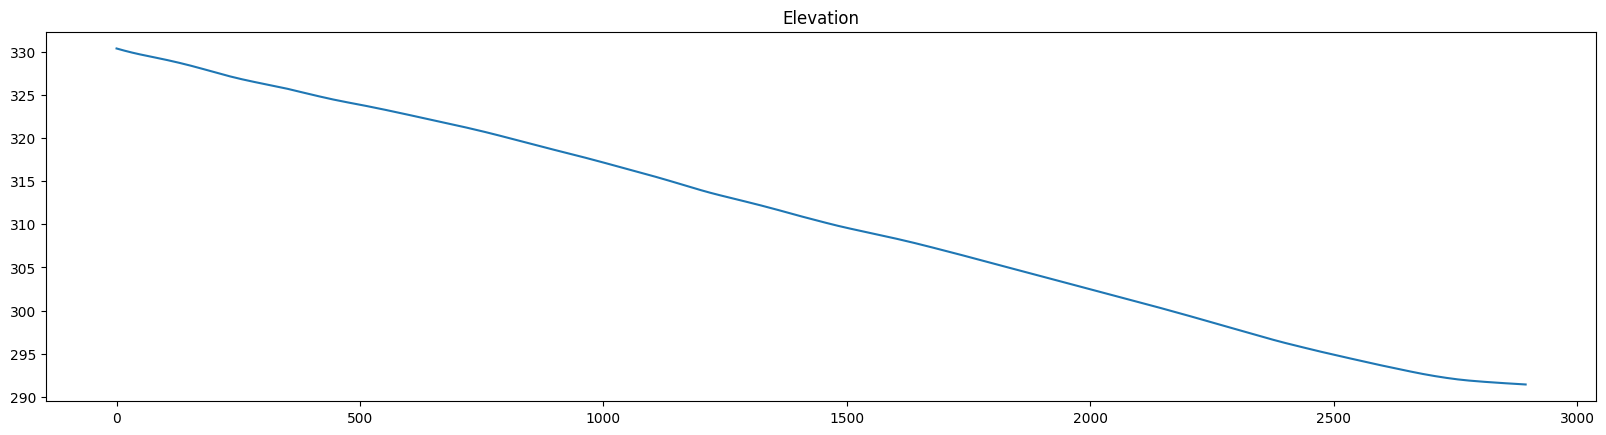

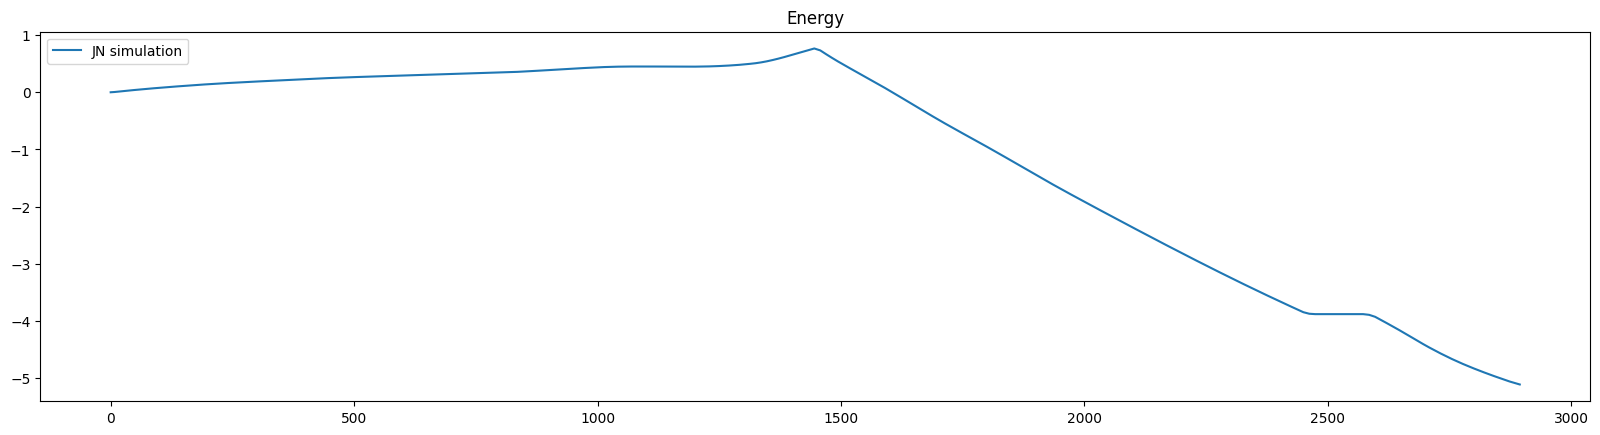

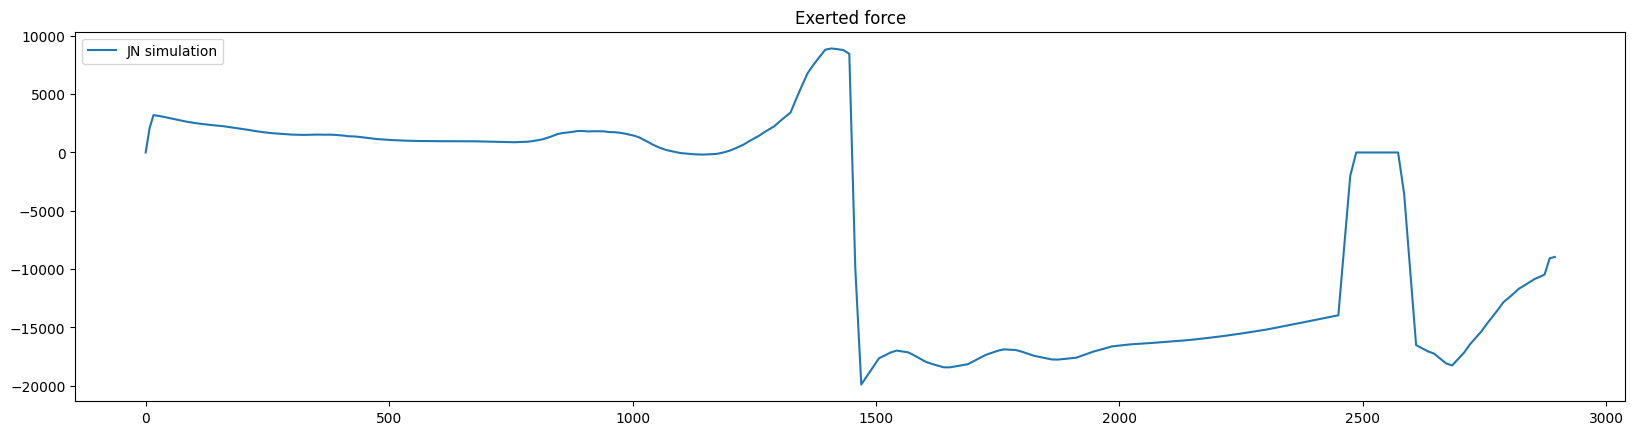

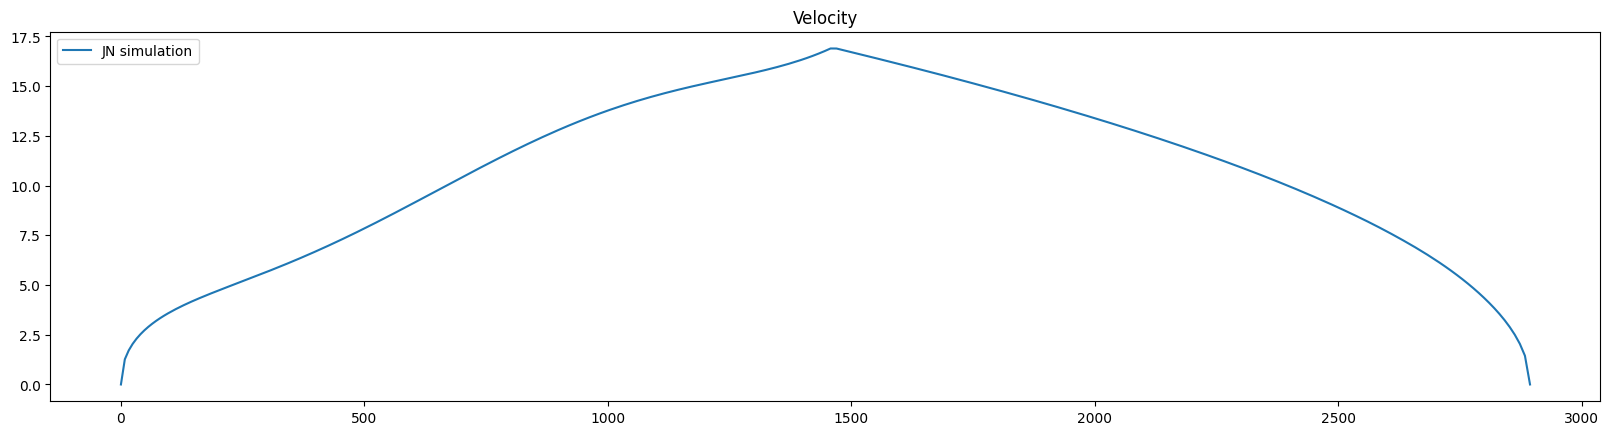

JN simulation final energy: -5.1136327573608815


In [33]:
importlib.reload(tconsumption)

# Calculated data
c = tconsumption.Consumption()
c.variable_params.update({
    "Elevation smoothing": 100,
    "Curve smoothing": 10,
    "Curve A": 999,
    "Curve B": 100,
    "Running a": 2,
    "Running b": 0.054,
    "Running c": 0.00034,
    "Recuperation coefficient": 1,
    "Comfortable acceleration": 0.1
})
c.load_from_file(DATA_PATH + "Opava-Olomouc/norway-sim/opava-olomouc.geojson")
# c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"]) # TODO: Add limits

# Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
c.params["power_limit"] = 480*1000
c.params["mass_locomotive"] = 56000
c.params["mass_wagon"] = 0

# Picking a slice
print(c.stations)
from_station = 20
to_station = 21

start_idx = c.stations[from_station]
end_idx = c.stations[to_station]

c.points = c.points[start_idx:end_idx]
c.stations = c.stations[from_station:to_station+1]
c.stations = [x-c.stations[0] for x in c.stations]
c.max_velocities_in_mps = c.max_velocities_in_mps[start_idx:end_idx]
c.series["elevation_values"] = c.series["elevation_values"][start_idx:end_idx]

# Running the simulation
c.run()

# Plotting
render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
render_plot(
    "Energy",
    c.series["dist_values"],
    [energy_calculated],
    ["JN simulation"],
    ["solid"]
)
render_plot(
    "Exerted force",
    c.series["dist_values"],
    [c.series["exerted_force_values"]],
    ["JN simulation"],
    ["solid", "solid"]
)

render_plot(
    "Velocity",
    c.series["dist_values"],
    [c.series["velocity_values"]],
    ["JN simulation", "Norwegian simulation"],
    ["solid", "solid"]
)

print(f"JN simulation final energy: {energy_calculated[-1]}")

# dtw = fastdtw(energy_calculated, HERE)[0]
# print("DTW:", dtw)

### 📈 Hledání funkce omezující "kroutící moment"

In [34]:
def draw_init_velocity_delta(df_measured, geojson_path, filter_window, fit_degree, variable_params, interest_range=None):
    importlib.reload(tconsumption)

    c = run_simulation(df_measured, geojson_path, variable_params, diesel_train_params)

    if interest_range is None:
        interest_range = (0, len(c.series["velocity_values"]))

    # Get deltas
    velocity_deltas = []
    for i in range(len(c.series["velocity_values"])):
        delta = c.series["velocity_values"][i] - df_measured["gps_speed"].iloc[i]
        velocity_deltas.append(delta)
        # if interest_range is None and delta <= 0 and i >= 100:
        #     interest_range = (0, i+1)
        # print(delta)
    print(interest_range)
    # interest_range = (0, len(velocity_deltas)) # debug

    interest_dists = c.series["dist_values"][interest_range[0]:interest_range[1]]
    interest_deltas = velocity_deltas[interest_range[0]:interest_range[1]]
    interest_sim_velocity = c.series["velocity_values"][interest_range[0]:interest_range[1]]
    interest_measured_velocity = df_measured["gps_speed"][interest_range[0]:interest_range[1]]
    interest_max_velocity = c.max_velocities_in_mps[interest_range[0]:interest_range[1]]

    # render_plot(
    #     "Velocity delta (full)",
    #     c.series["dist_values"],
    #     [velocity_deltas],
    #     ["Delta (actual)"],
    #     ["solid"],
    #     show_hline=True
    # )

    render_plot(
        "Velocity (full)",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    render_plot(
        "Velocity (interest)",
        interest_dists,
        [interest_sim_velocity, interest_measured_velocity, interest_max_velocity],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    # Fitting a polynomial
    poly = np.poly1d(np.polyfit(interest_dists, interest_deltas, fit_degree))
    # print("polynomial:", poly)

    render_plot(
        "Velocity delta (interest)",
        interest_dists,
        [interest_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    # Savgol Filter
    filtered_deltas = savgol_filter(interest_deltas, filter_window, 0, mode="nearest")

    # Fitting a polynomial (to Savgol)
    poly = np.poly1d(np.polyfit(interest_dists, filtered_deltas, fit_degree))
    # print("polynomial:", poly)

    render_plot(
        "Velocity delta (interest, filtered)",
        interest_dists,
        [filtered_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    # # Fitting a polynomial (to velocity x velocity)
    # poly = np.poly1d(np.polyfit(interest_sim_velocity, filtered_deltas, fit_degree))
    render_plot(
        "Velocity x velocity",
        interest_sim_velocity,
        [filtered_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    return {
        "deltas": interest_deltas,
        "dists": interest_dists,
        "poly": poly
    }

In [35]:
all_poly_graphs = []

#### Opava západ ➡️ Krnov-Cvilín

(0, 200)


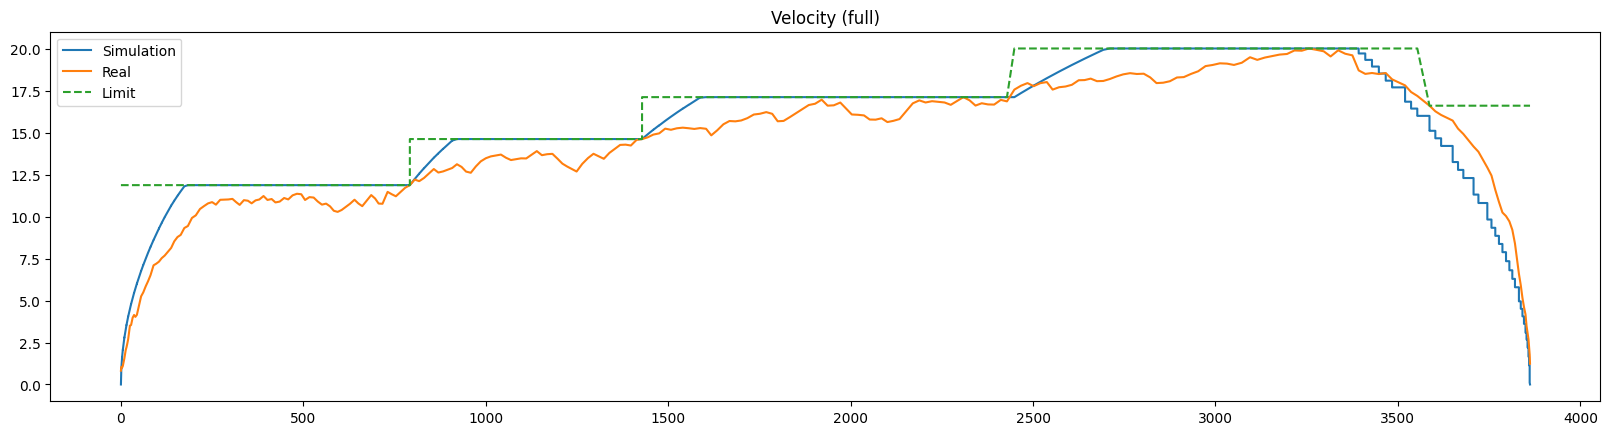

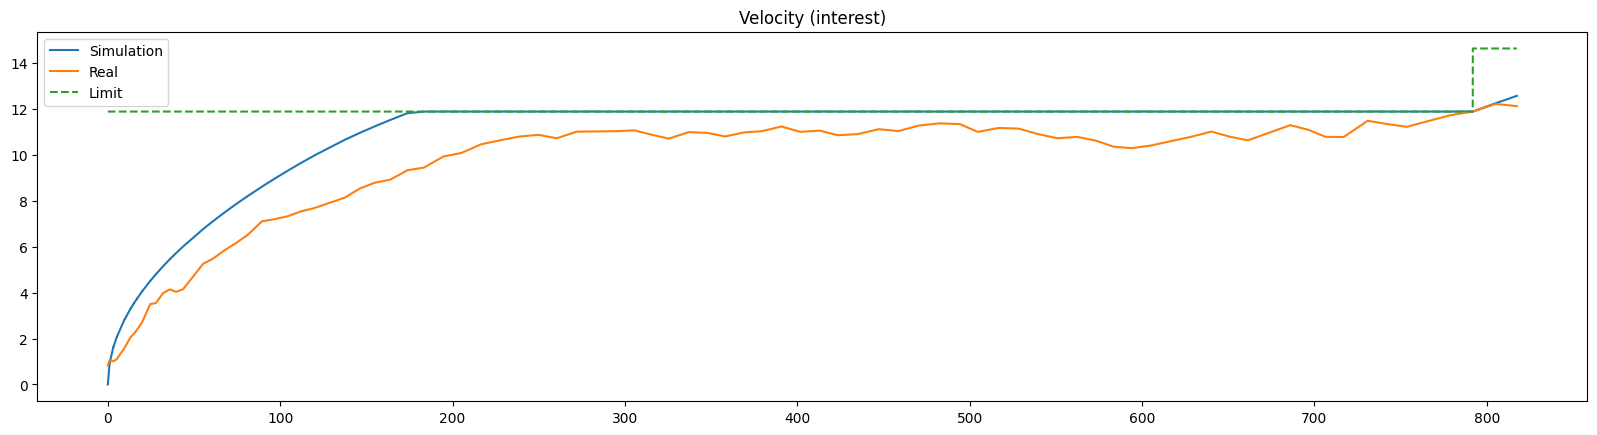

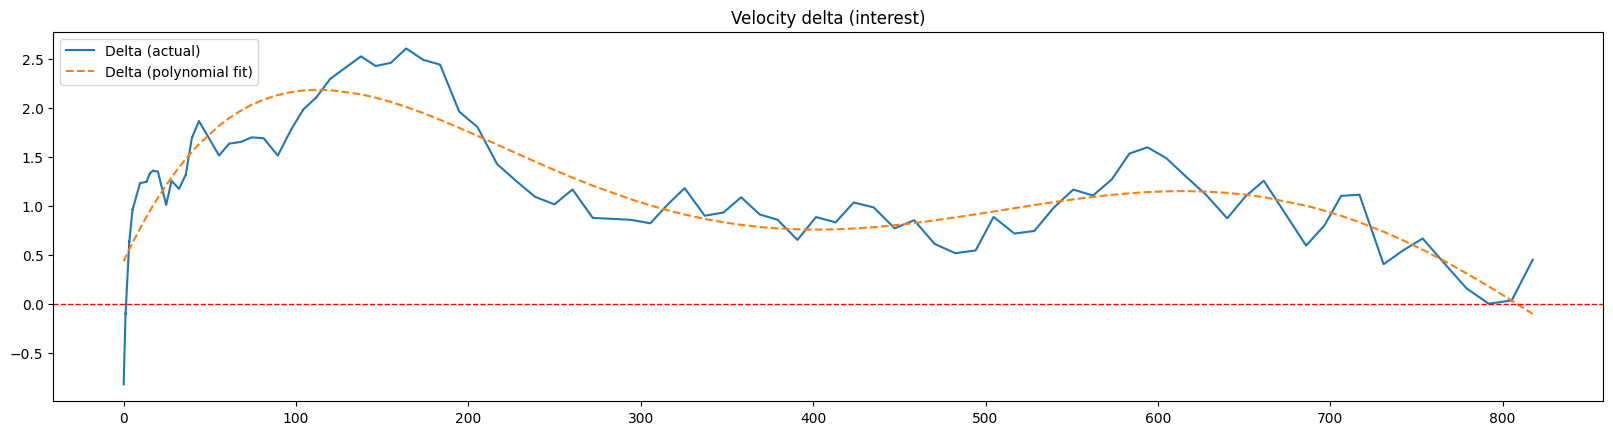

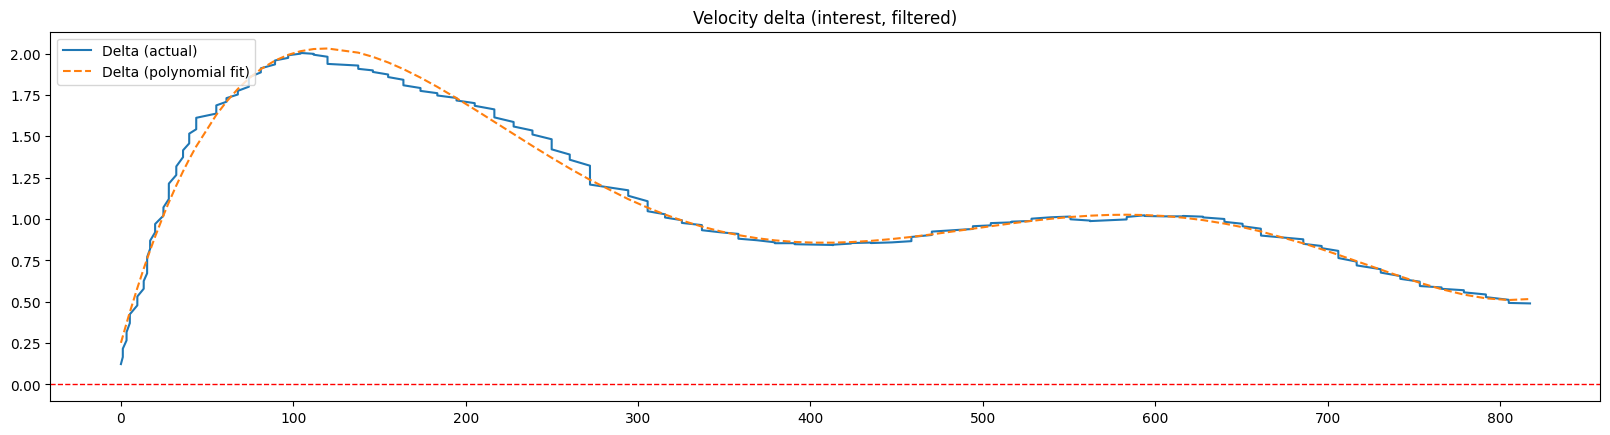

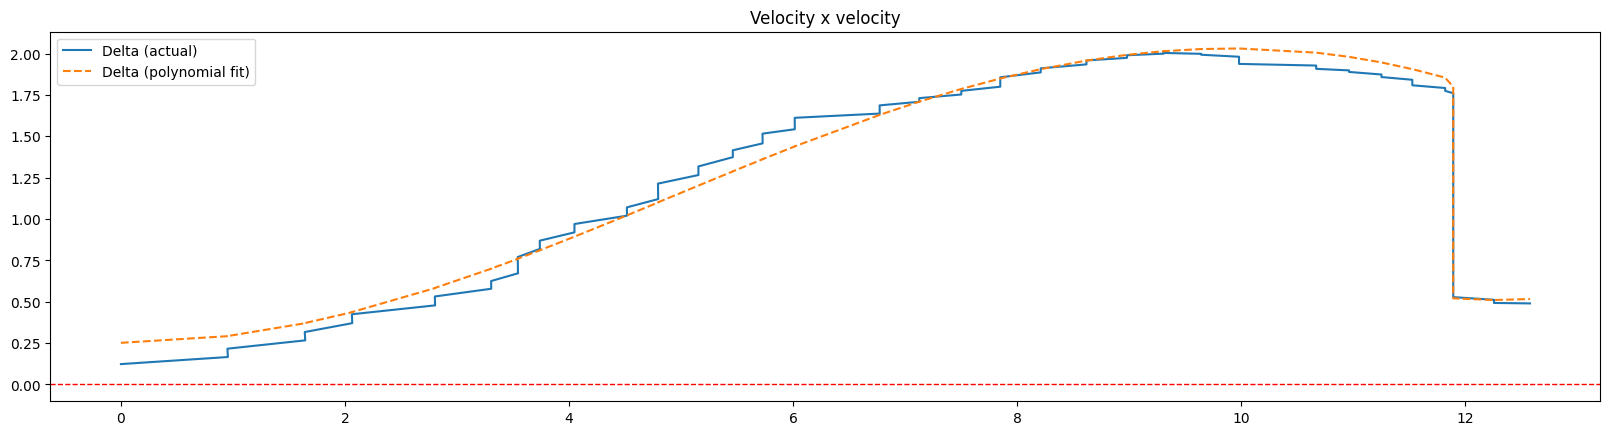

In [36]:
output = draw_init_velocity_delta(
    processed_sections[0]["df"], processed_sections[0]["geojson"],
    filter_window=50, fit_degree=5,
    variable_params=diesel_params_no_comp,
    interest_range=(0, 200)
)
all_poly_graphs.append(output)

#### Krnov-Cvilín ➡️ Krnov

(0, 238)


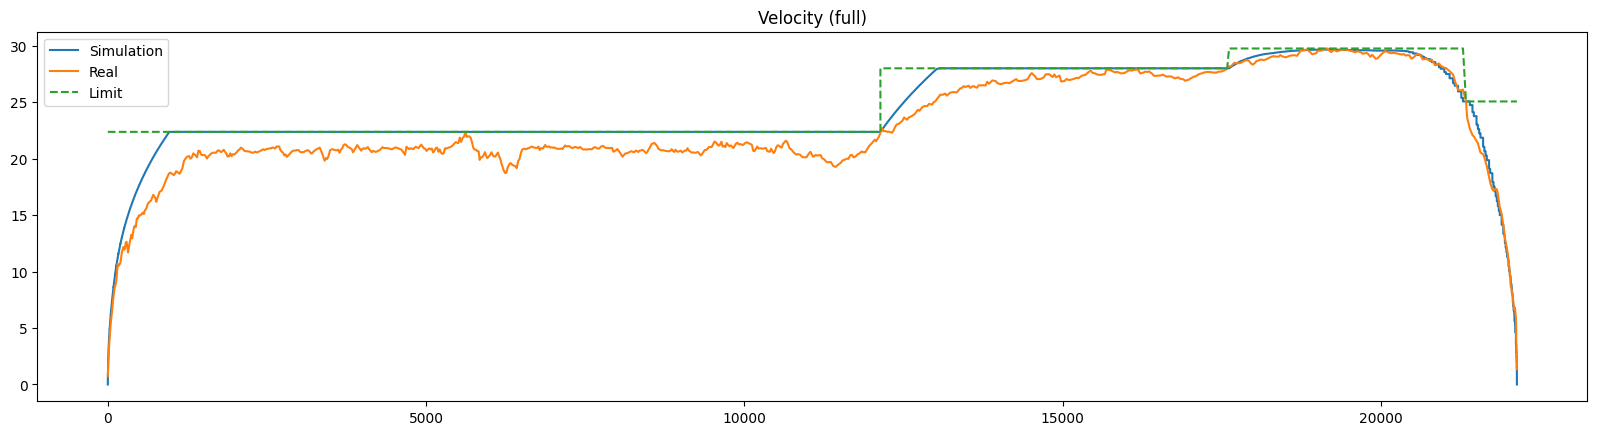

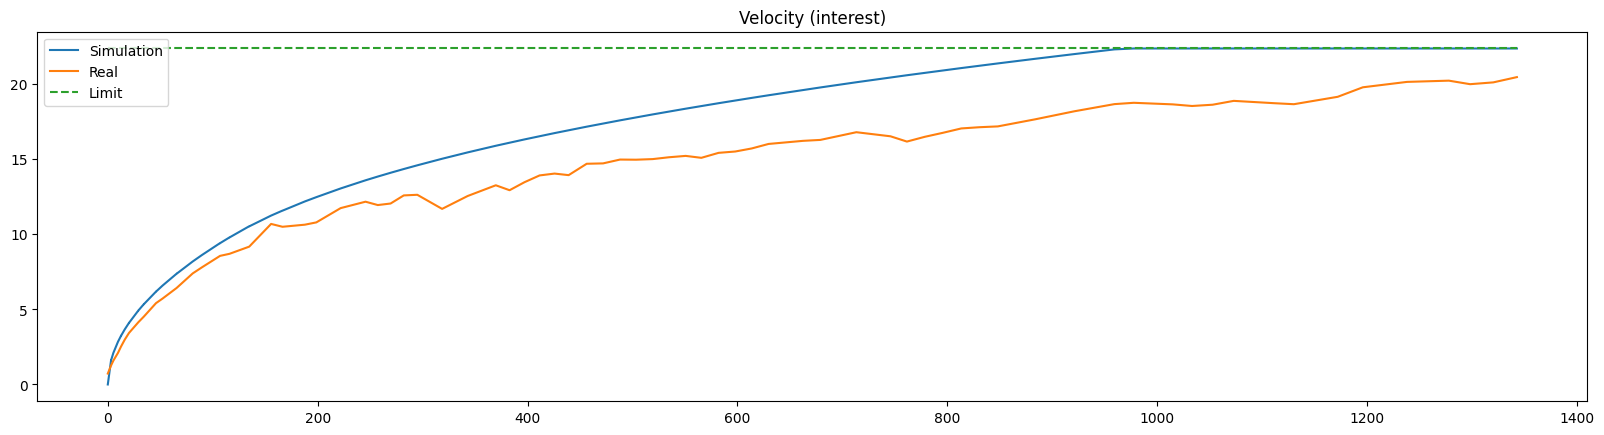

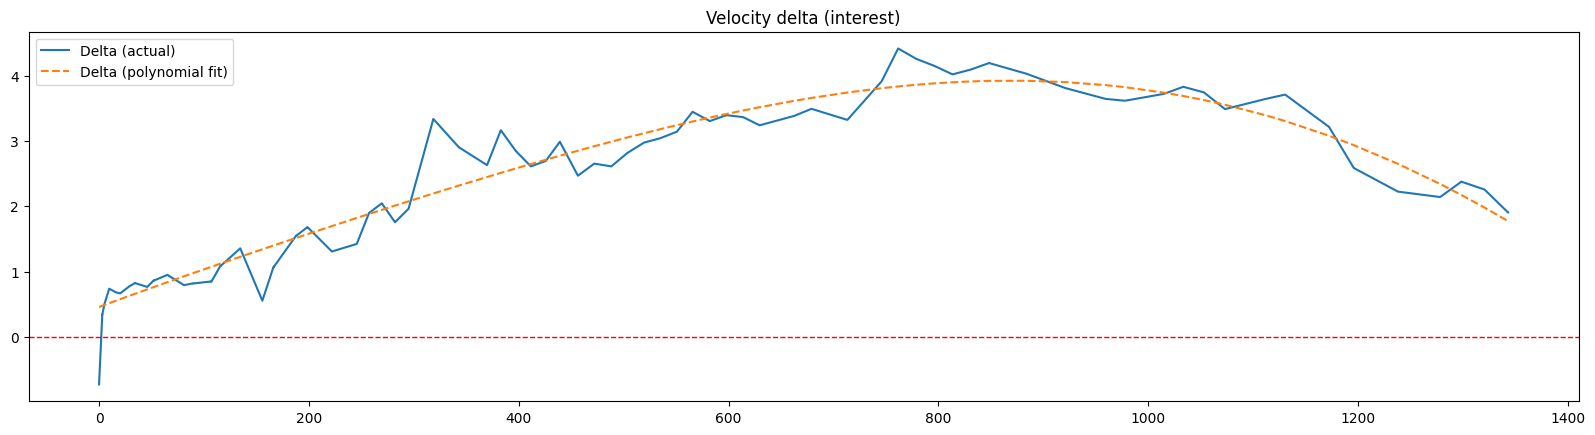

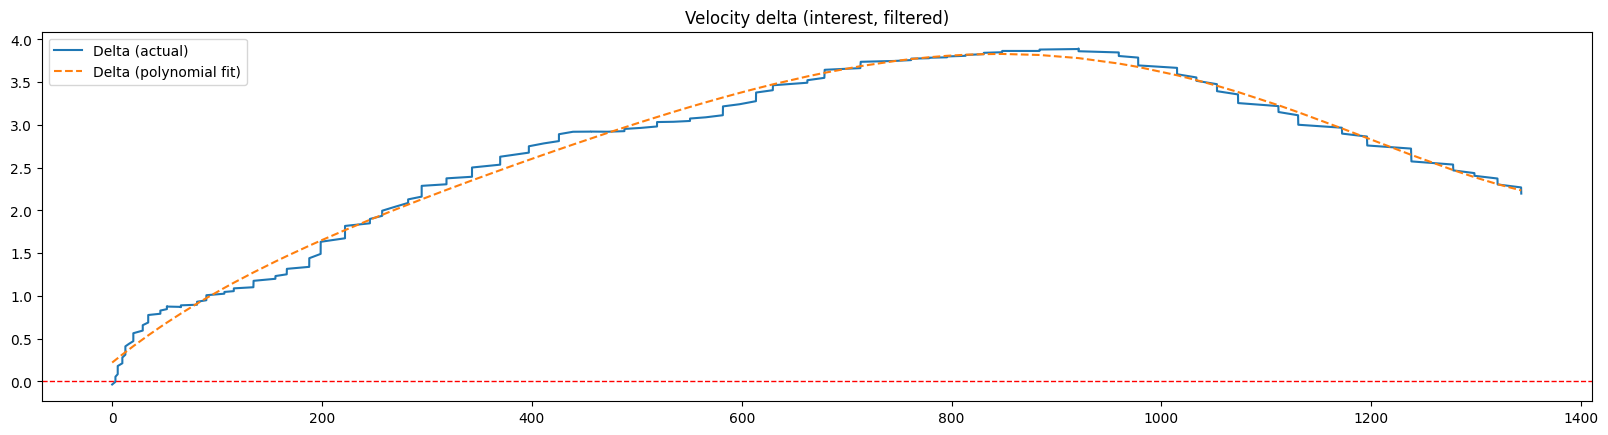

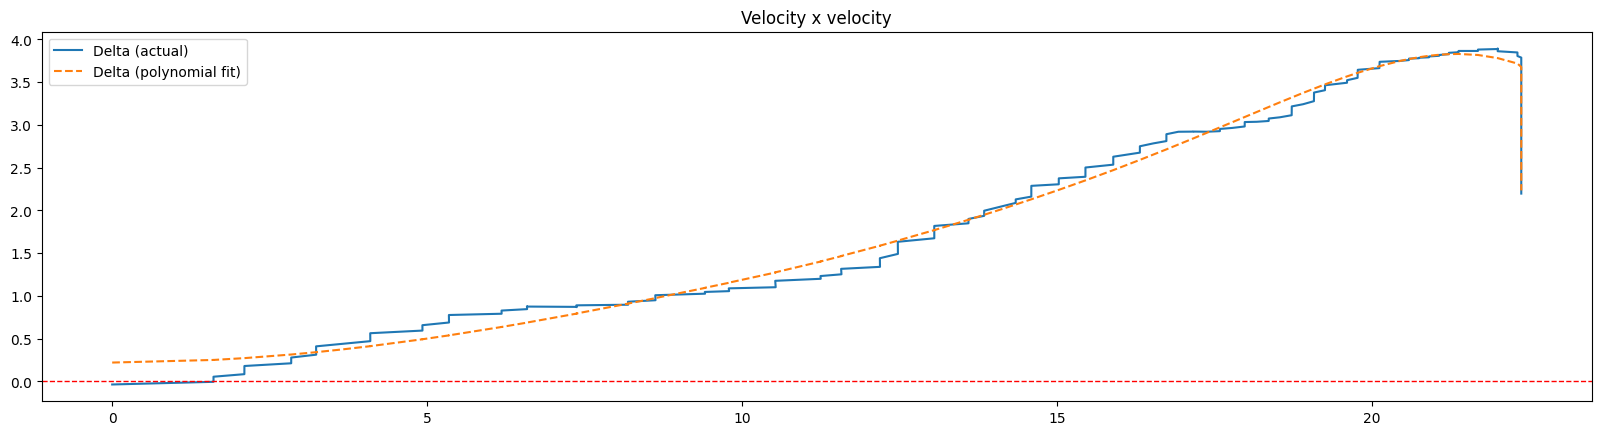

In [37]:
output = draw_init_velocity_delta(
    processed_sections[1]["df"], processed_sections[1]["geojson"],
    filter_window=50, fit_degree=5,
    variable_params=diesel_params_no_comp,
    interest_range=(0, 238)
)
all_poly_graphs.append(output)

#### Krnov ➡️ Milotice n. Opavou

(0, 255)


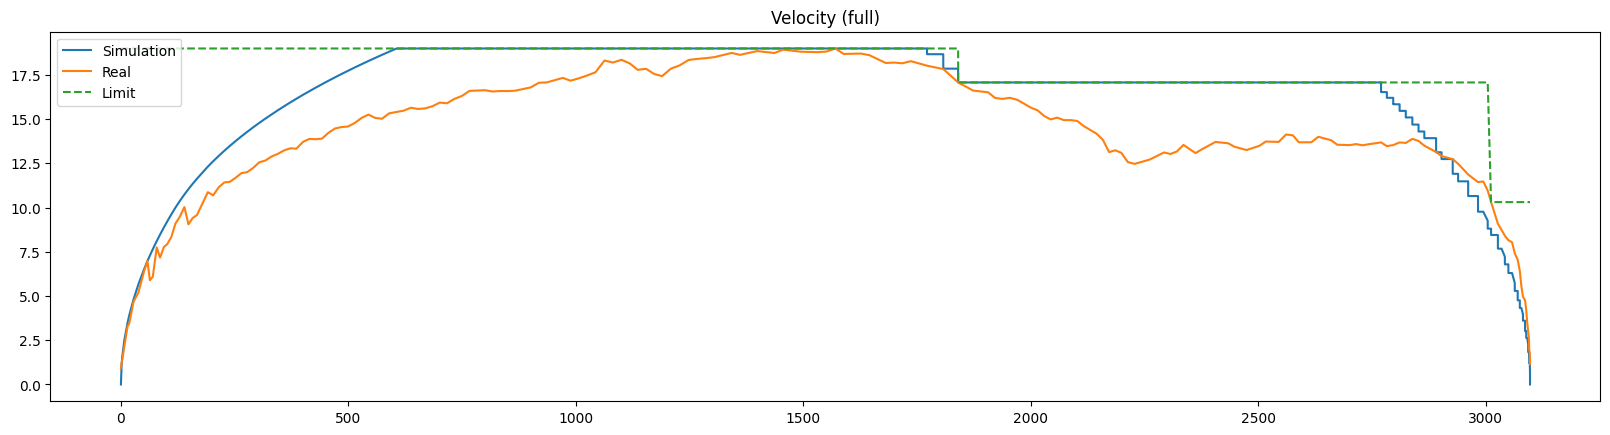

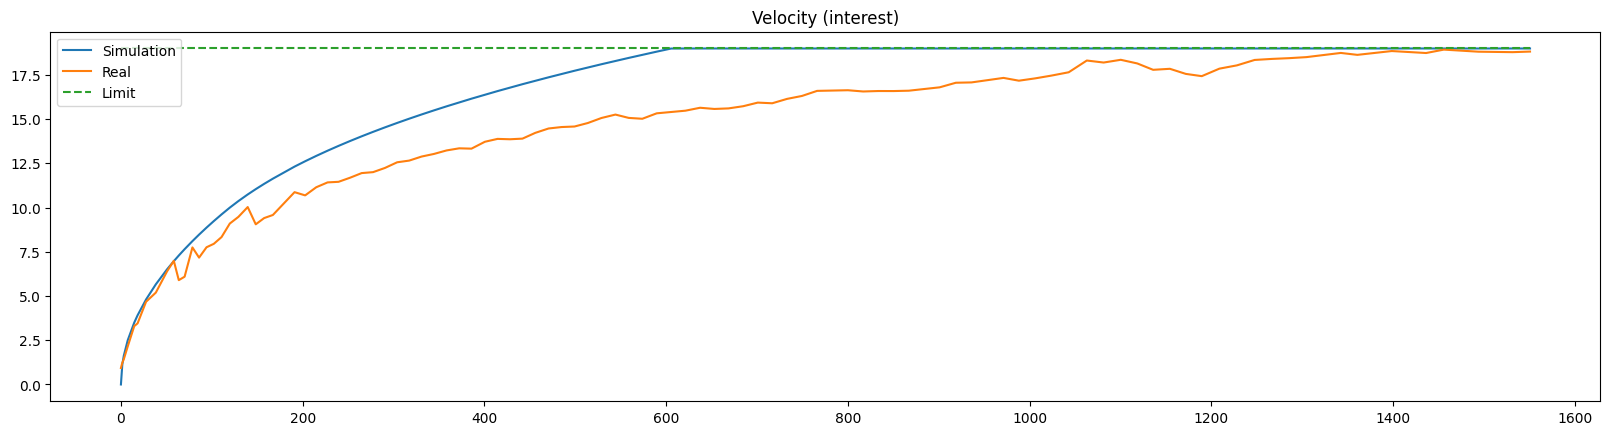

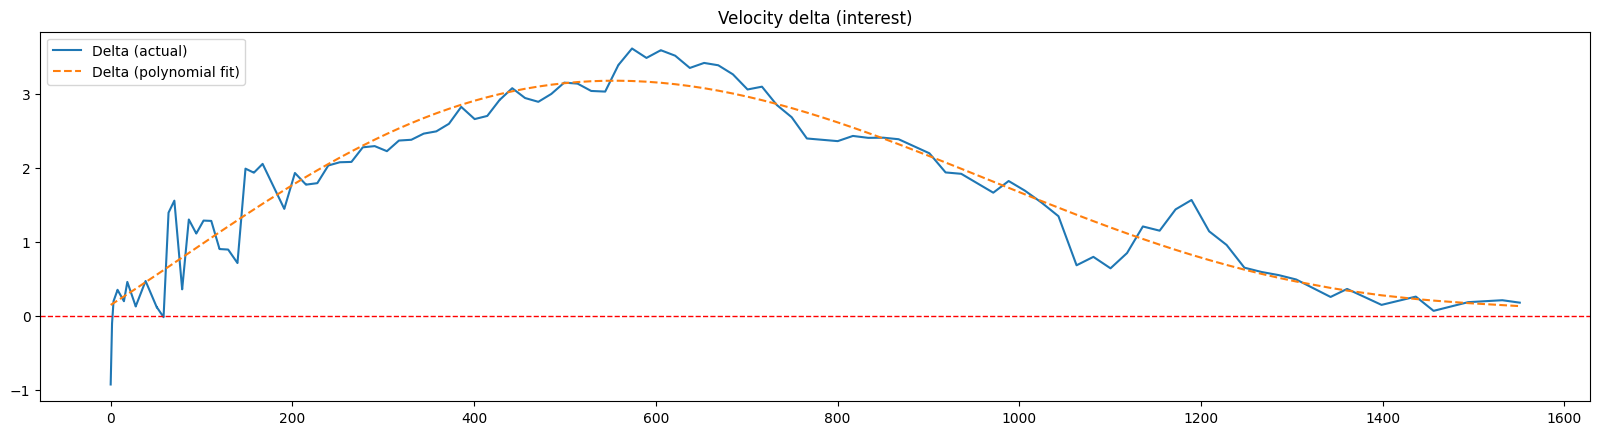

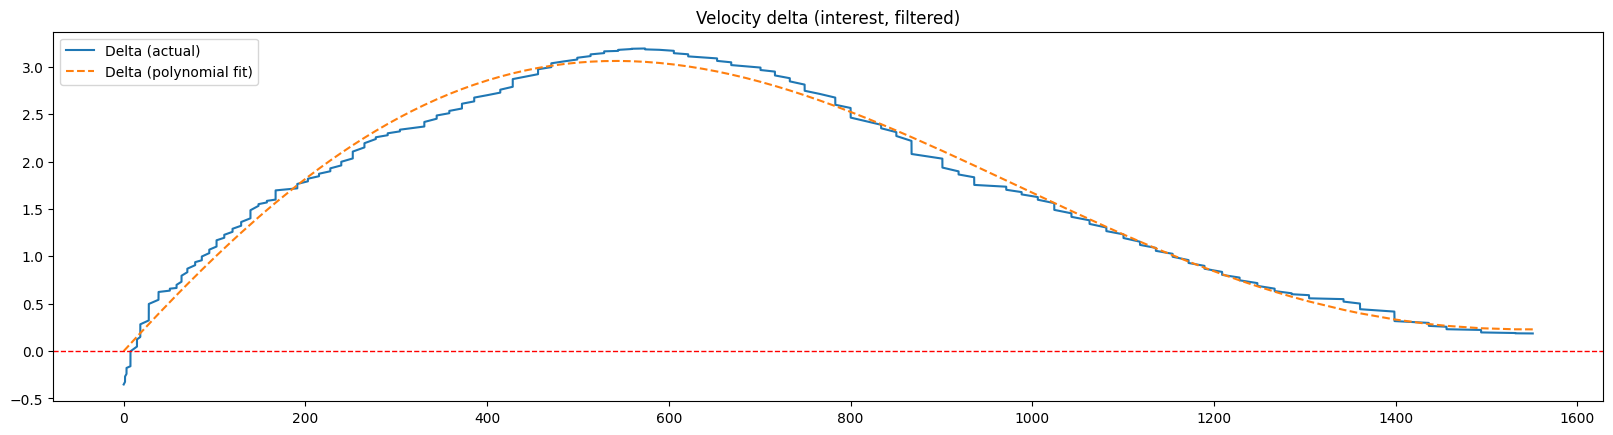

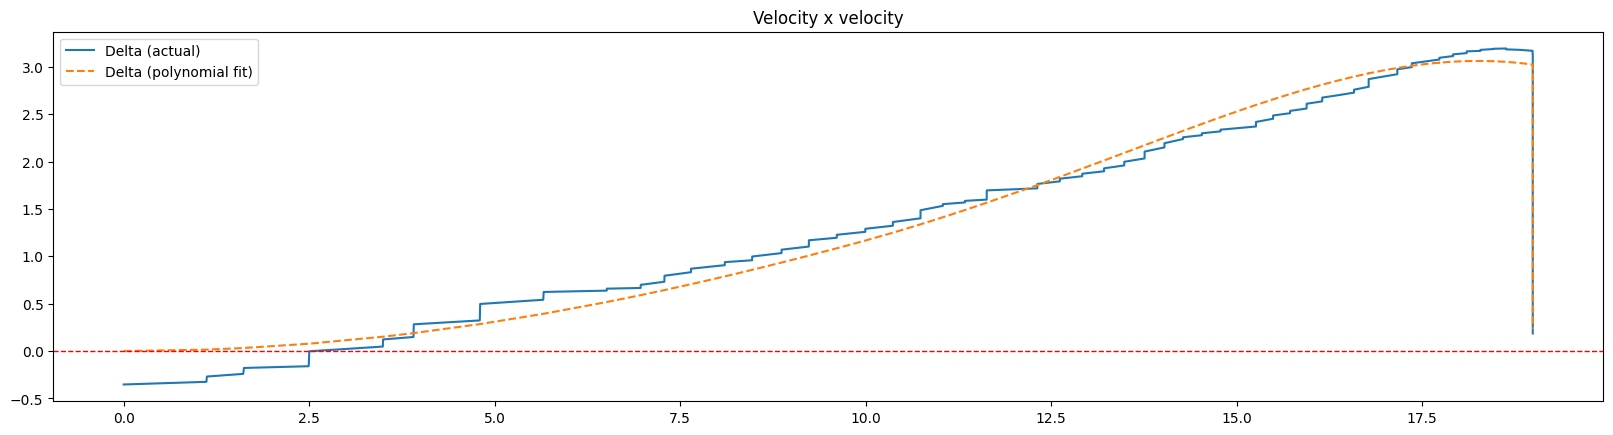

In [38]:
output = draw_init_velocity_delta(
    processed_sections[2]["df"], processed_sections[2]["geojson"],
    filter_window=50, fit_degree=5,
    variable_params=diesel_params_no_comp,
    interest_range=(0, 255)
)
all_poly_graphs.append(output)

#### Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí

(0, 105)


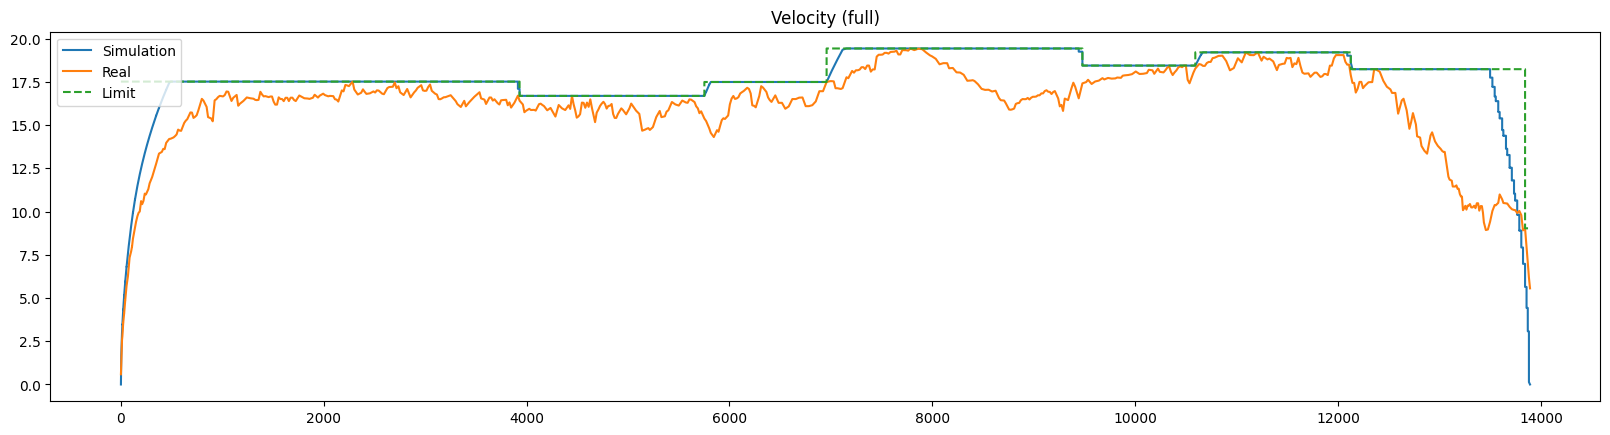

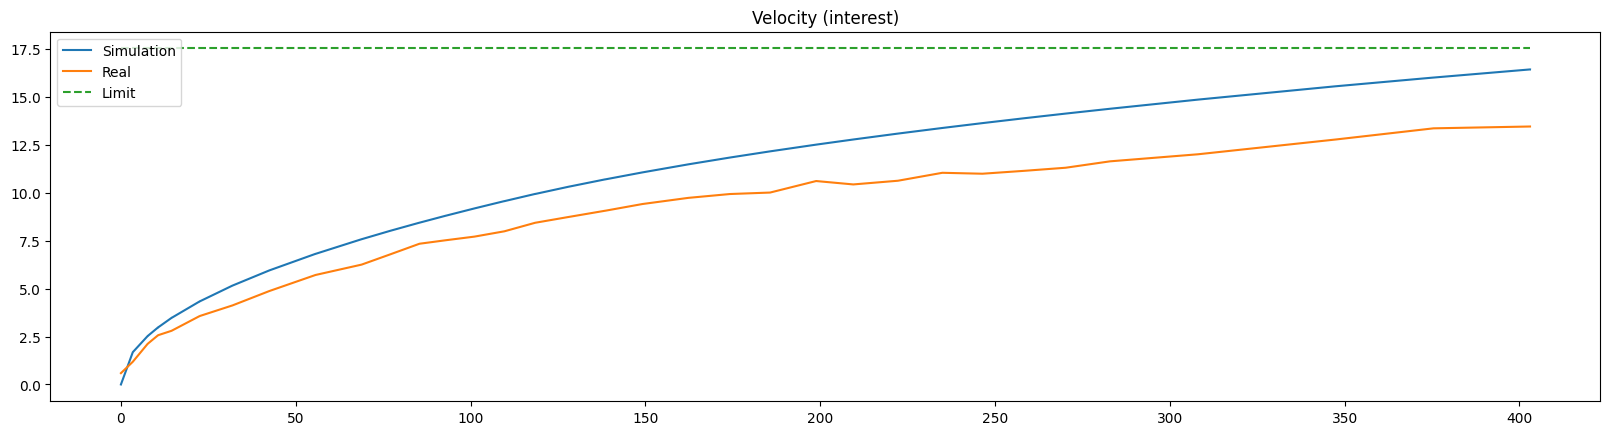

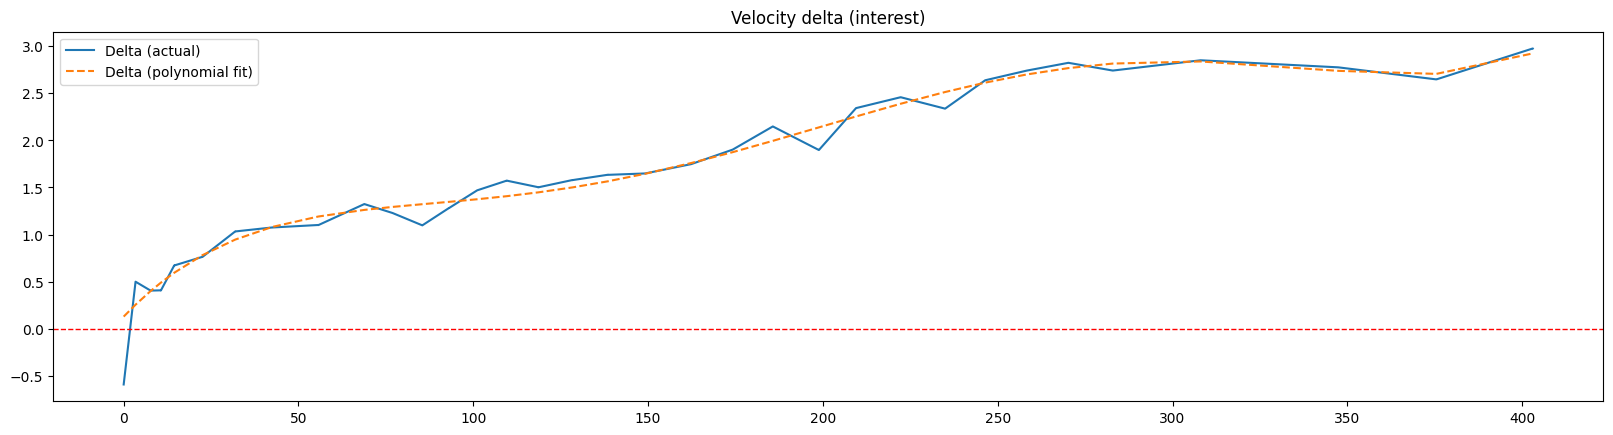

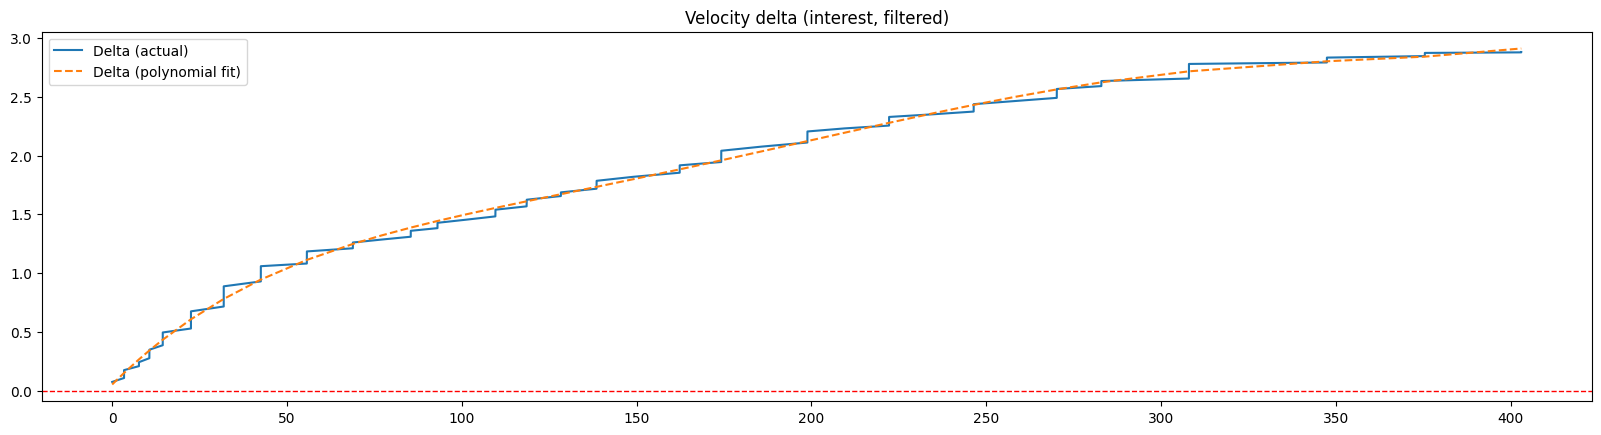

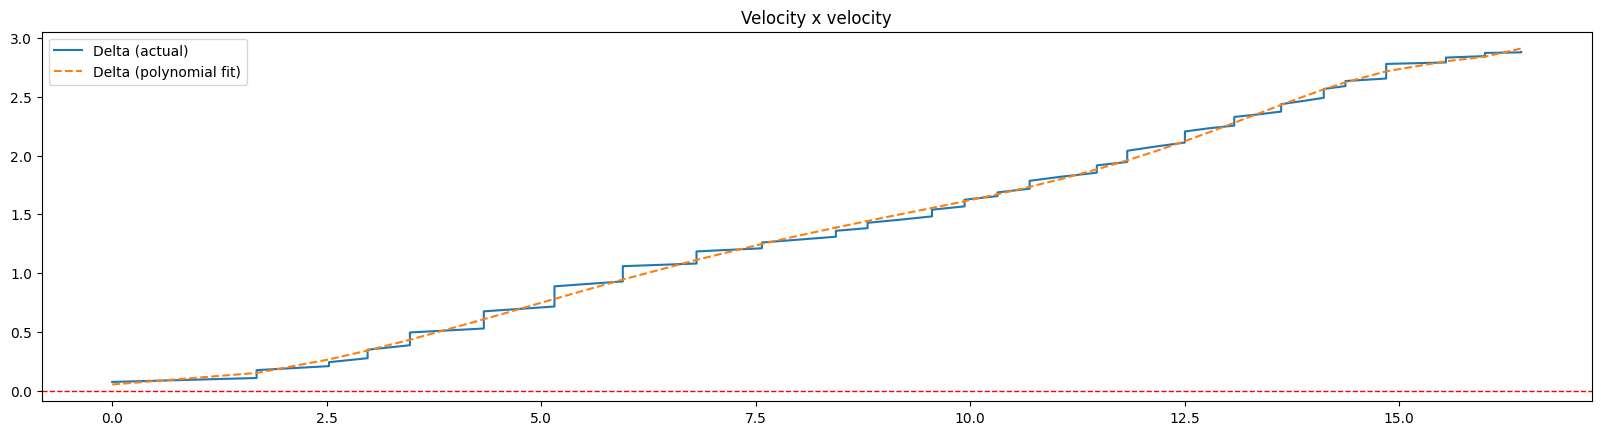

In [39]:
output = draw_init_velocity_delta(
    processed_sections[3]["df"], processed_sections[3]["geojson"],
    filter_window=50, fit_degree=5,
    variable_params=diesel_params_no_comp,
    interest_range=(0, 105)
)
all_poly_graphs.append(output)

#### Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí

(0, 330)


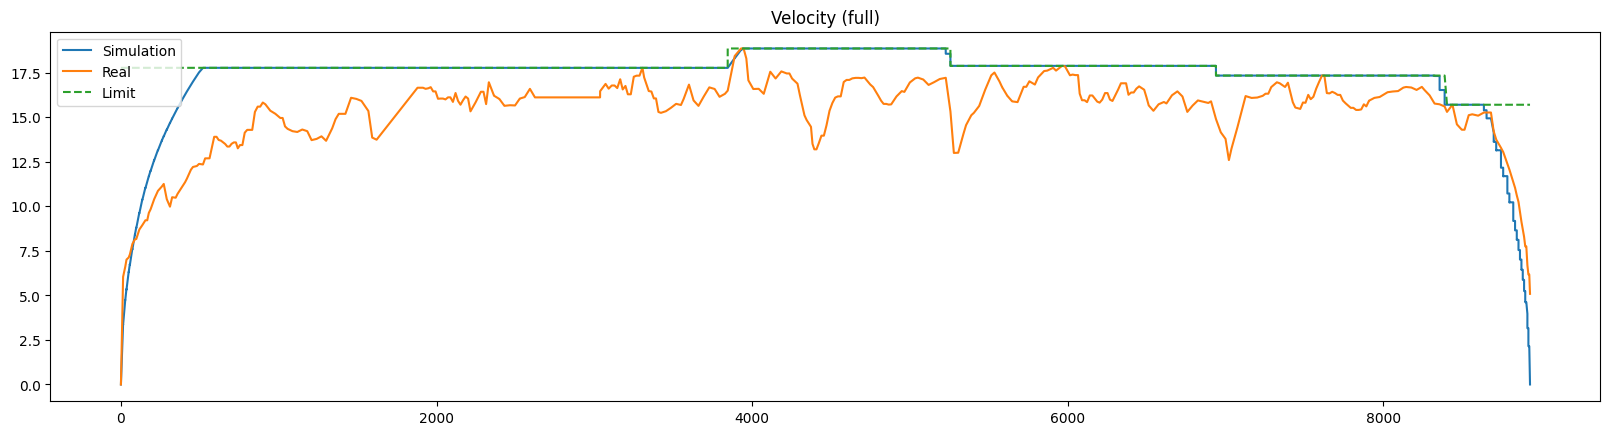

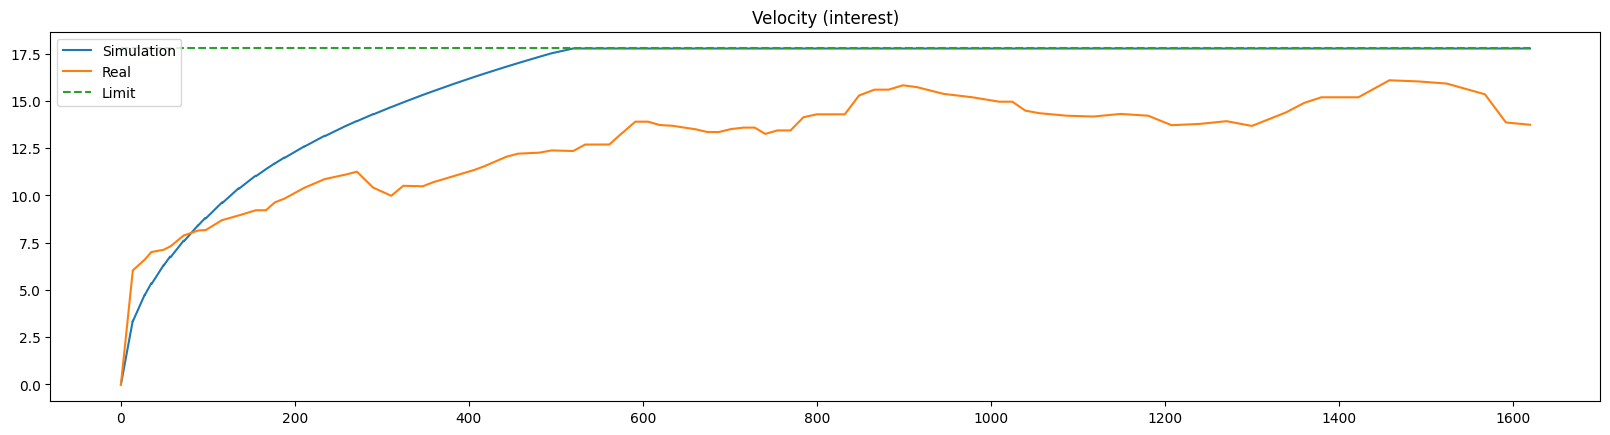

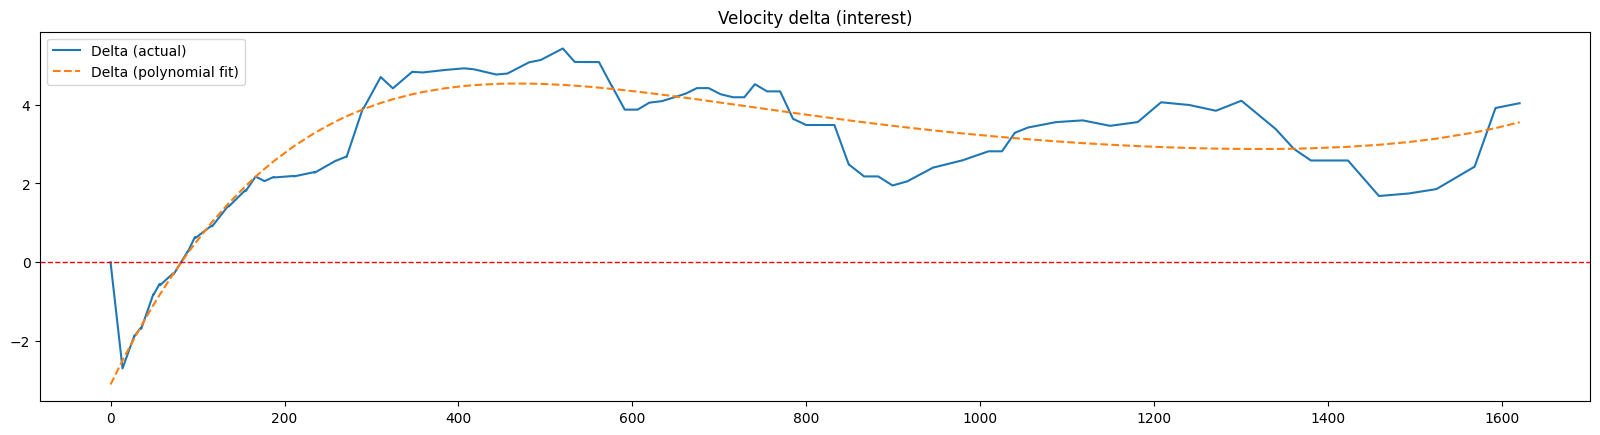

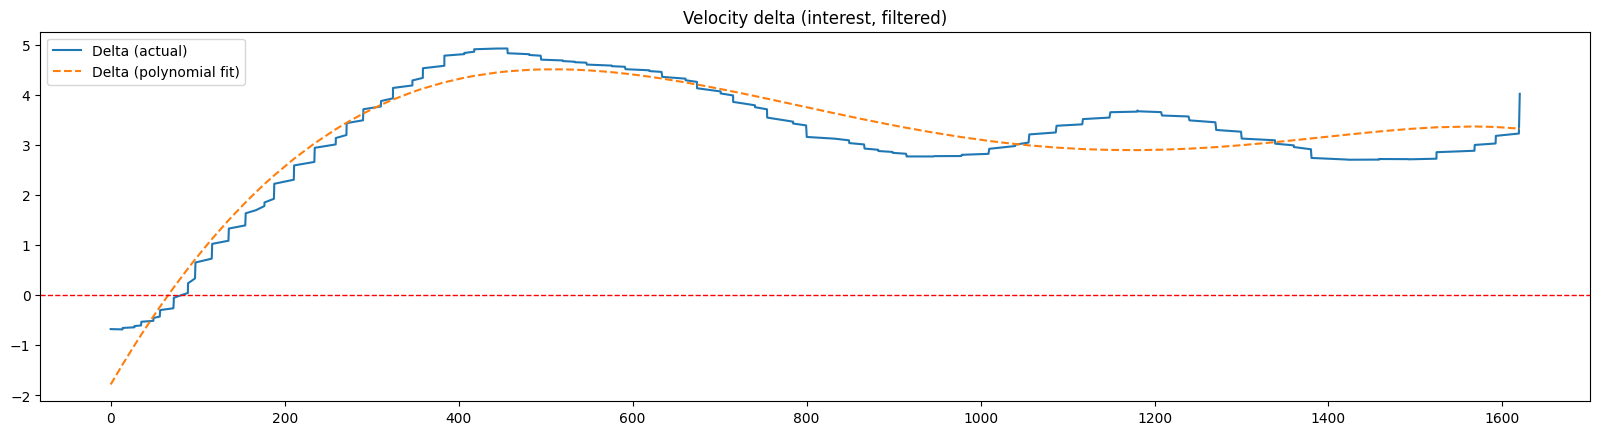

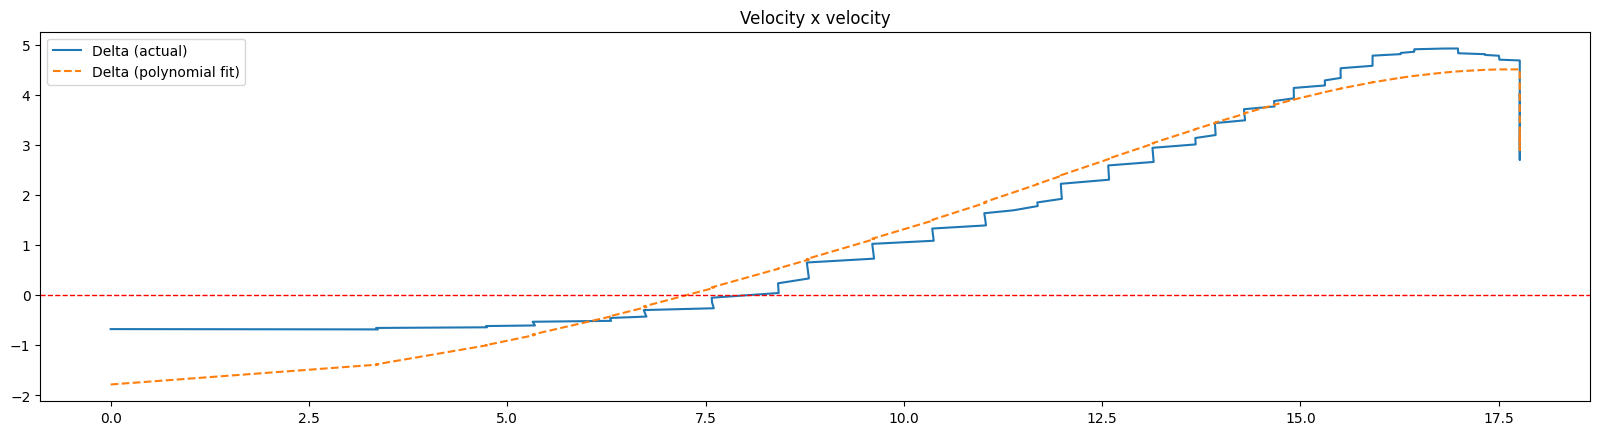

In [40]:
output = draw_init_velocity_delta(
    processed_sections[4]["df"], processed_sections[4]["geojson"],
    filter_window=50, fit_degree=5,
    variable_params=diesel_params_no_comp,
    interest_range=(0, 330)
)
all_poly_graphs.append(output)

#### Sloučení do jednoho grafu

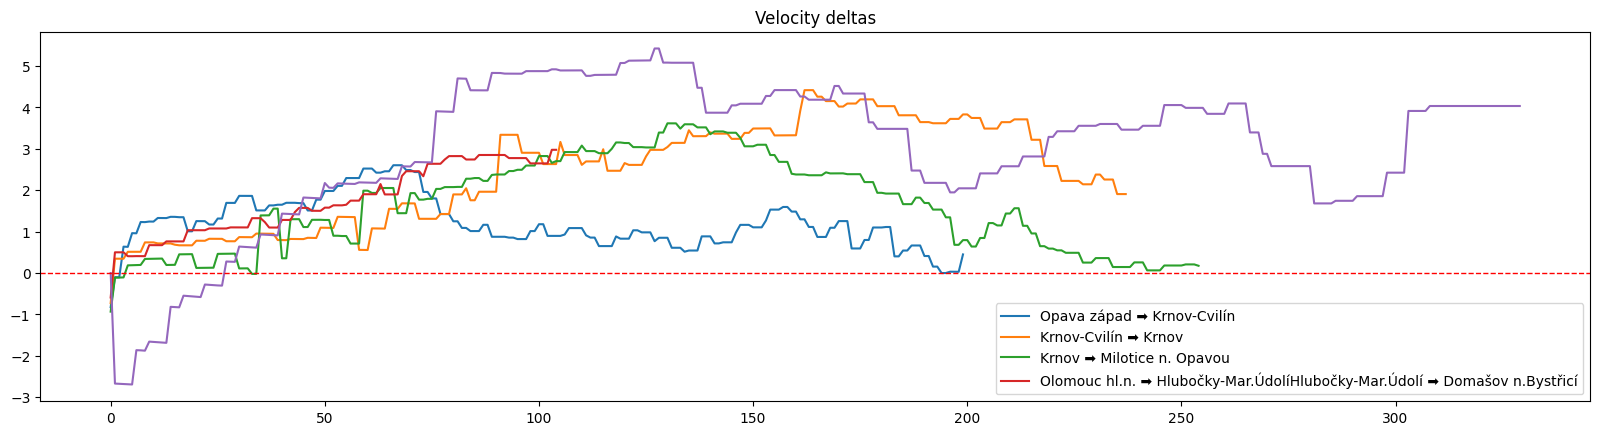

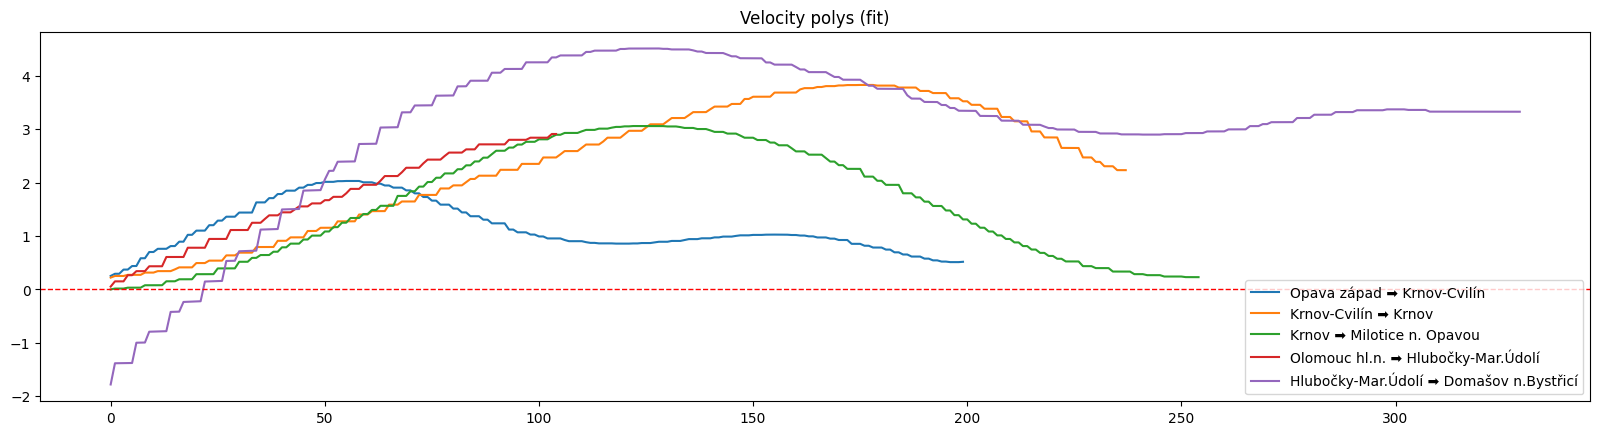

In [41]:
all_velocity_deltas = [x["deltas"] for x in all_poly_graphs]
all_polys = [list(x["poly"](x["dists"])) for x in all_poly_graphs]

max_len = max([len(x) for x in all_velocity_deltas])
for i,x in enumerate(all_velocity_deltas):
    if len(x) < max_len:
        x += [None] * (max_len-len(x))
for i,x in enumerate(all_polys):
    if len(x) < max_len:
        x += [None] * (max_len-len(x))

render_plot(
    "Velocity deltas",
    list(range(0, max_len)),
    all_velocity_deltas,
    [
        "Opava západ ➡️ Krnov-Cvilín",
        "Krnov-Cvilín ➡️ Krnov",
        "Krnov ➡️ Milotice n. Opavou",
        "Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí"
        "Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí"
    ],
    ["solid"]*100,
    show_hline=True,
    legend_loc="lower right"
)

render_plot(
    "Velocity polys (fit)",
    list(range(0, max_len)),
    all_polys,
    [
        "Opava západ ➡️ Krnov-Cvilín",
        "Krnov-Cvilín ➡️ Krnov",
        "Krnov ➡️ Milotice n. Opavou",
        "Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí",
        "Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí"
    ],
    ["solid"]*100,
    show_hline=True,
    legend_loc="lower right"
)

#### Vybraný polynom

polynomial:             5             4             3             2
-2.988e-15 x + 1.292e-11 x - 1.426e-08 x - 4.451e-06 x + 0.01045 x - 0.000691
polynomial as list: [-2.987810697921493e-15, 1.291565644145985e-11, -1.4259285056473806e-08, -4.450719838611429e-06, 0.010453939950081531, -0.0006909862996970009]
values @ 200: 1.8177028806033624
values: 1000 1000


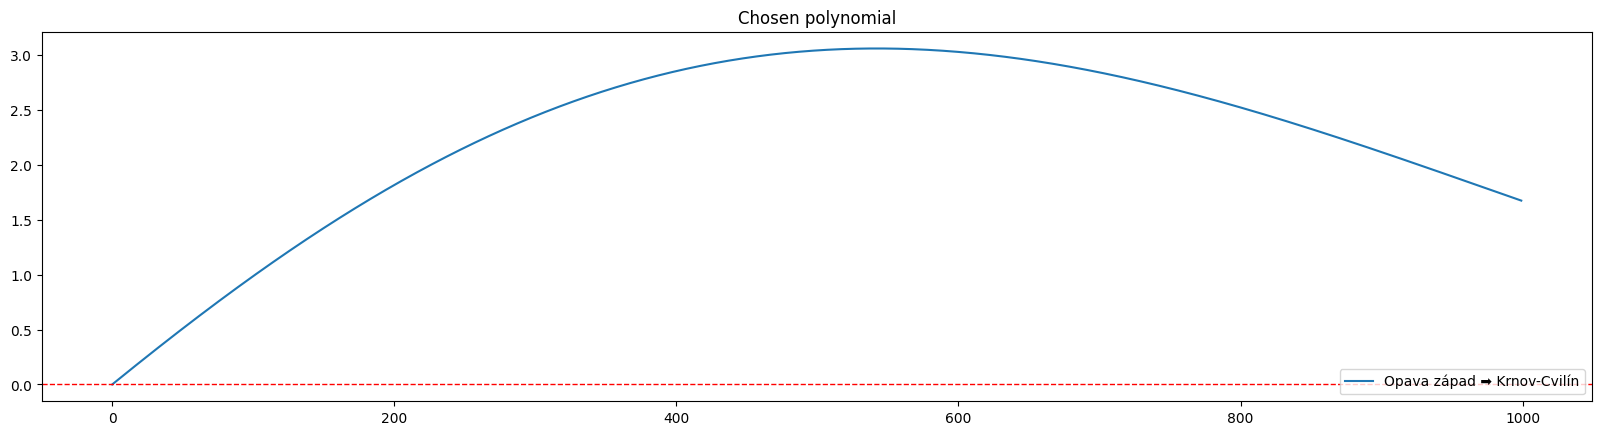

In [42]:
golden_poly = all_poly_graphs[2]["poly"]
print("polynomial:", golden_poly)
print("polynomial as list:", list(golden_poly))
print("values @ 200:", golden_poly(200))

x_len = 1000
x = list(range(0, x_len))
print("values:", len(golden_poly(x)), len(x))
render_plot(
    "Chosen polynomial",
    x,
    [golden_poly(x)],
    ["Opava západ ➡️ Krnov-Cvilín"],
    ["solid"],
    show_hline=True,
    legend_loc="lower right"
)

### 🛤️ Zpracované úseky (Svinov-Štítina)

#### 🗺️ Mapa

In [43]:
# GPS info
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=((df3.iloc[0]['gps_latitude']+df3.iloc[-1]['gps_latitude'])/2, (df3.iloc[0]['gps_longitude']+df3.iloc[-1]['gps_longitude'])/2),
    zoom=12
)
line = Polyline(
    locations=df3[["gps_latitude", "gps_longitude"]].values.tolist(),
    color="green",
    fill=False
)
m.add_layer(line)
m

Map(center=[49.86771005, 18.1087424], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

7
{'station_start': 'Ostrava-Svinov', 'start': 266, 'station_end': 'Ostrava-Třebovice', 'end': 426}


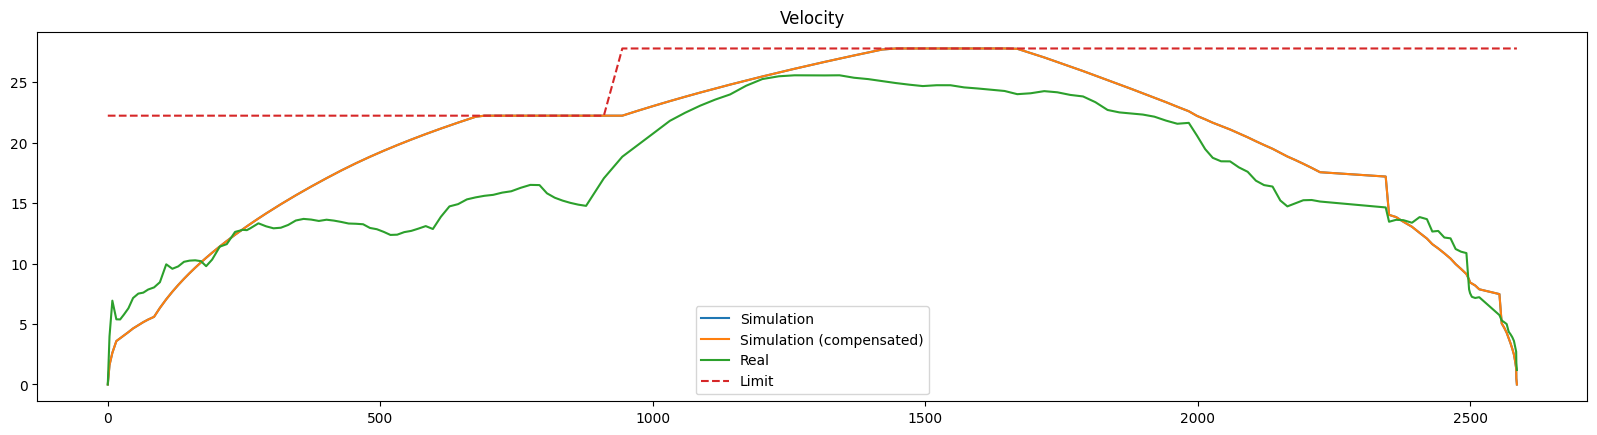

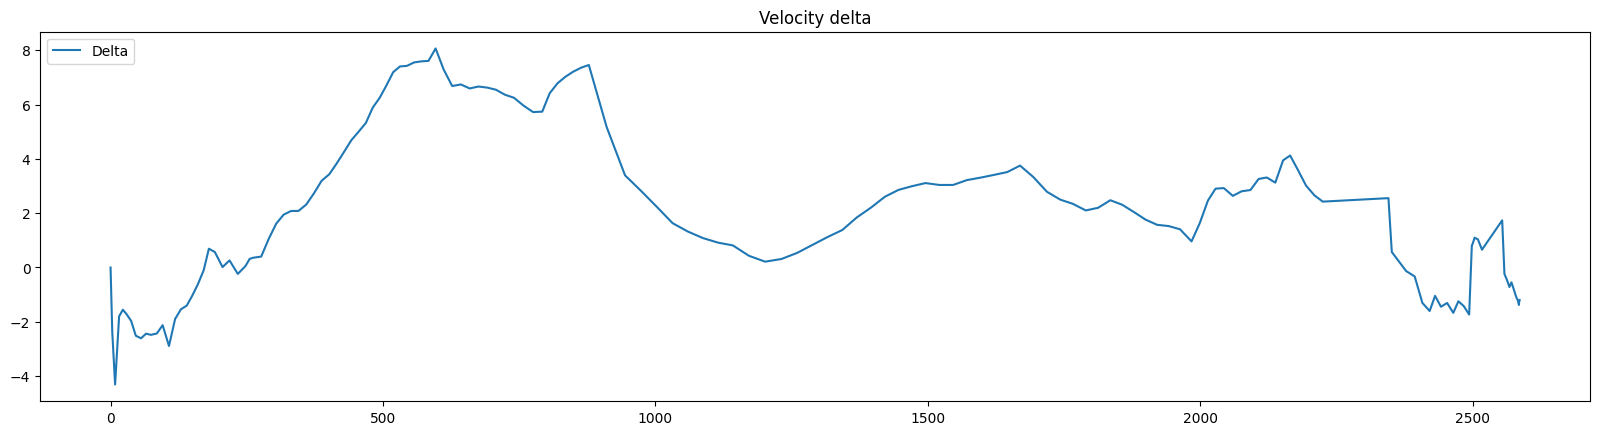

DTW: 103.5875457661432
{'station_start': 'Ostrava-Třebovice', 'start': 709, 'station_end': 'Děhylov', 'end': 940}


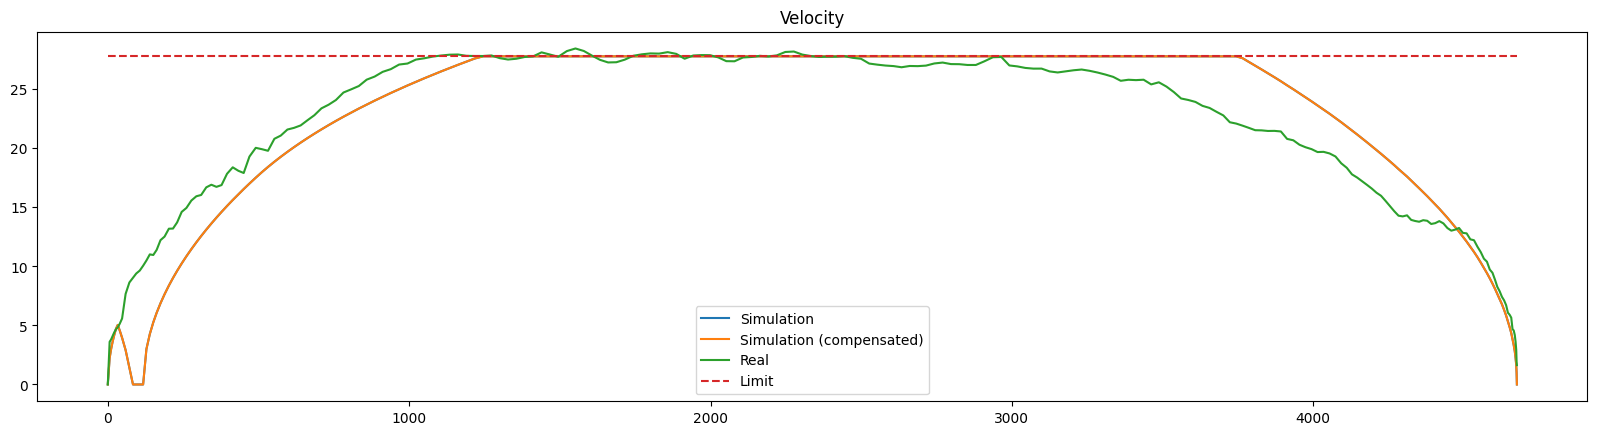

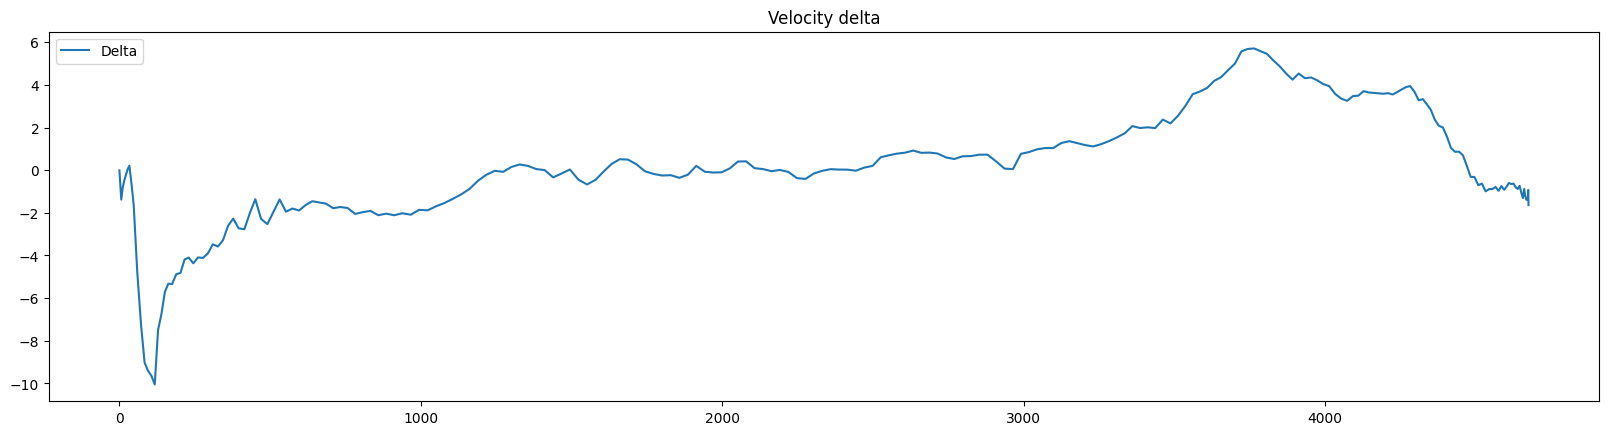

DTW: 63.13627884885784
{'station_start': 'Děhylov', 'start': 974, 'station_end': 'Jilešovice', 'end': 1138}


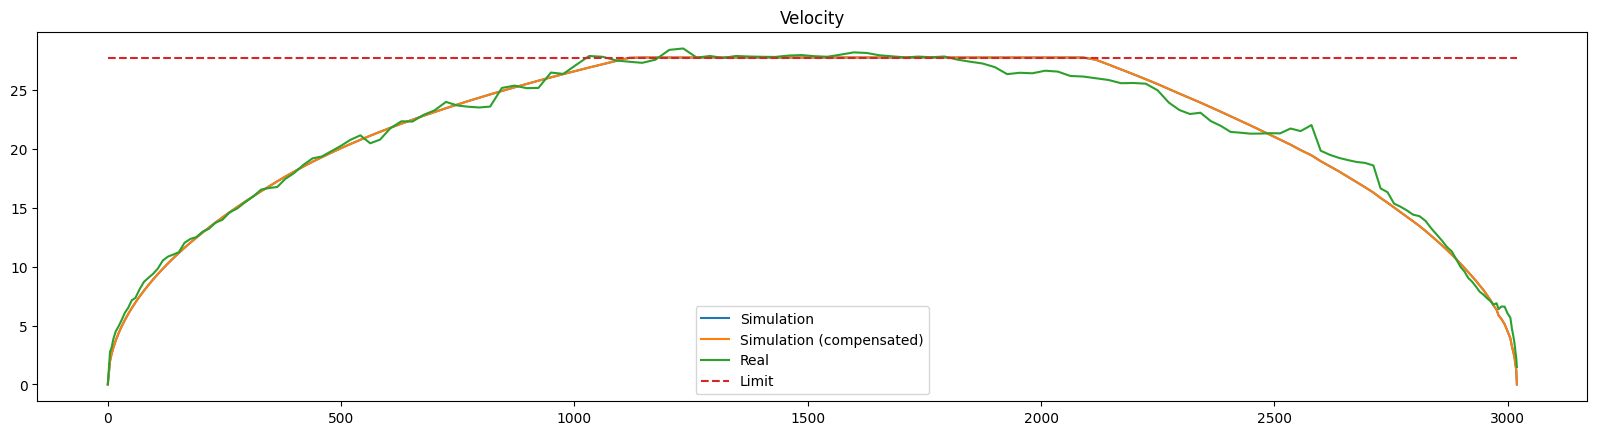

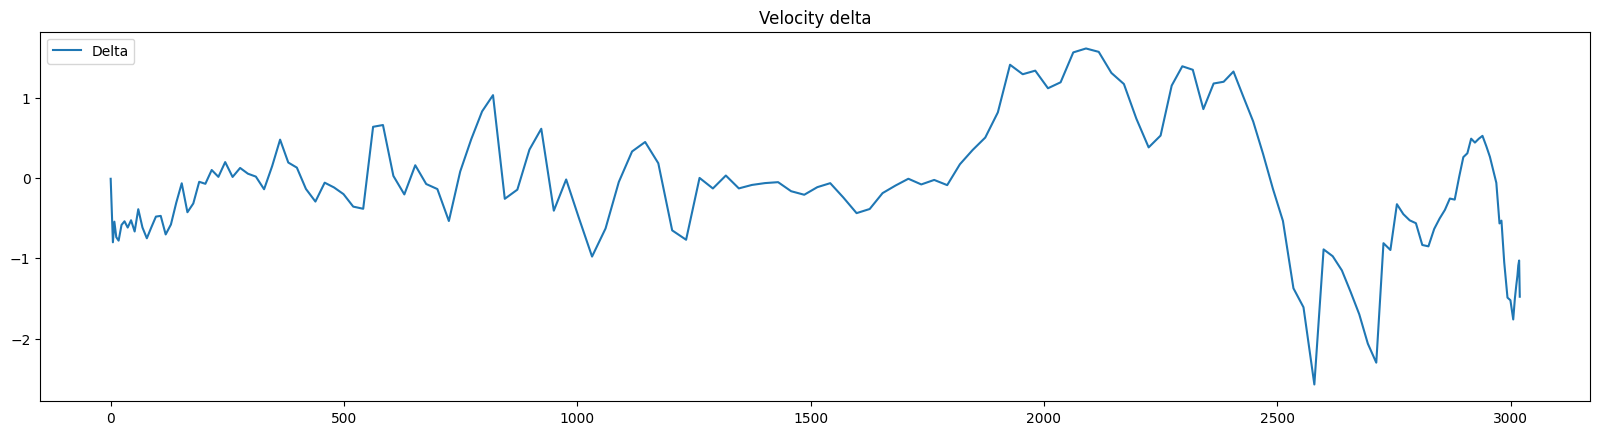

DTW: 35.081053813950454
{'station_start': 'Jilešovice', 'start': 1168, 'station_end': 'Háj ve Slezsku', 'end': 1352}


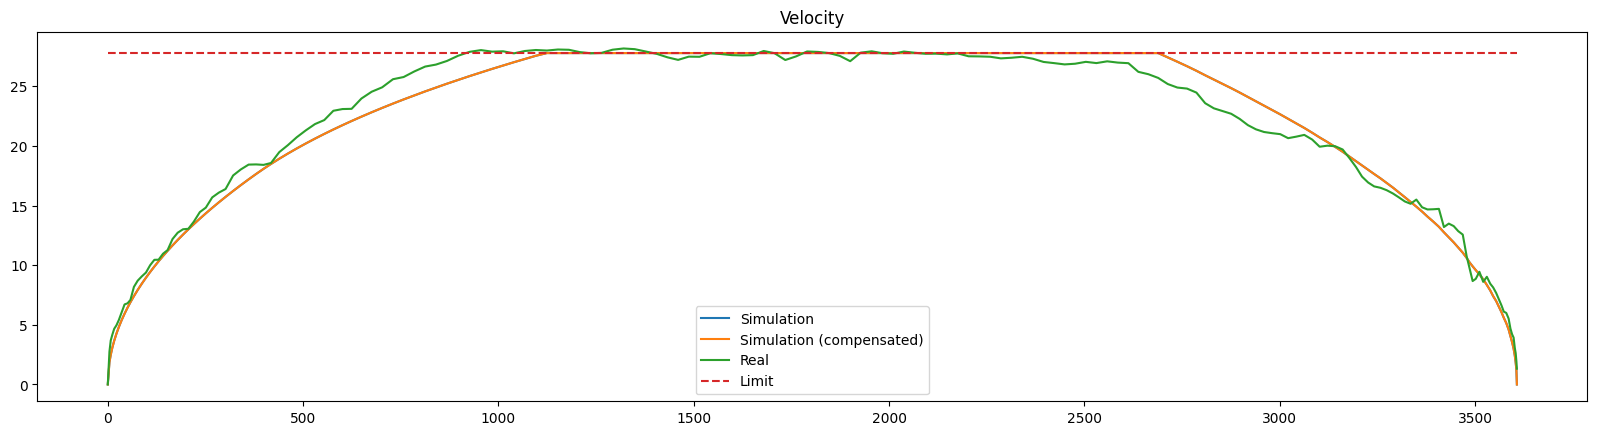

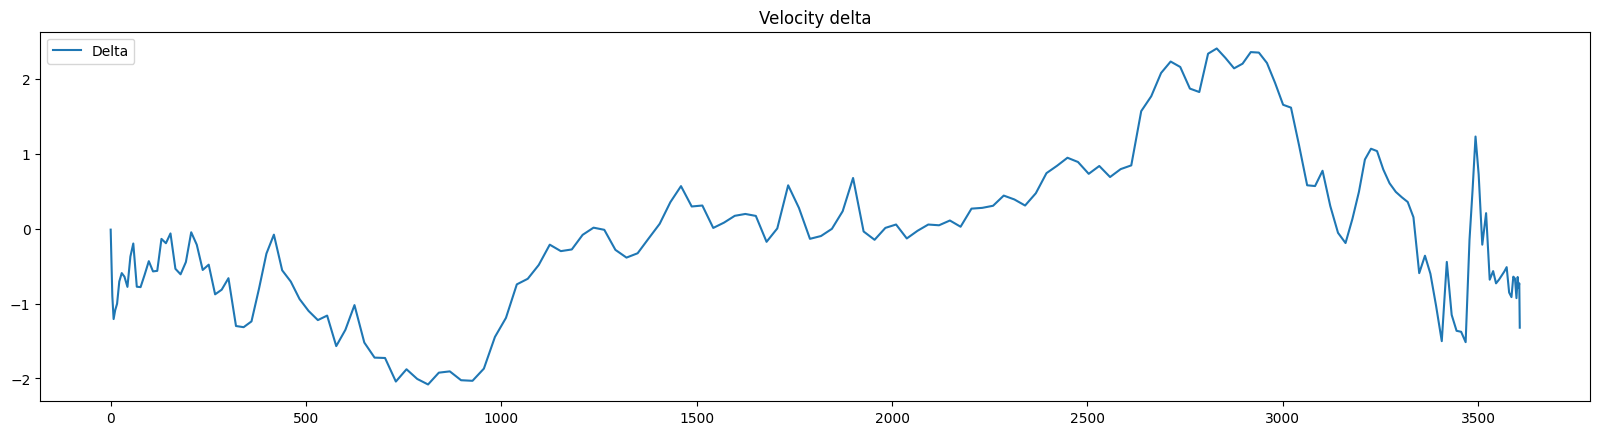

DTW: 35.3786688143249
{'station_start': 'Háj ve Slezsku', 'start': 1385, 'station_end': 'Lhota u Opavy', 'end': 1573}


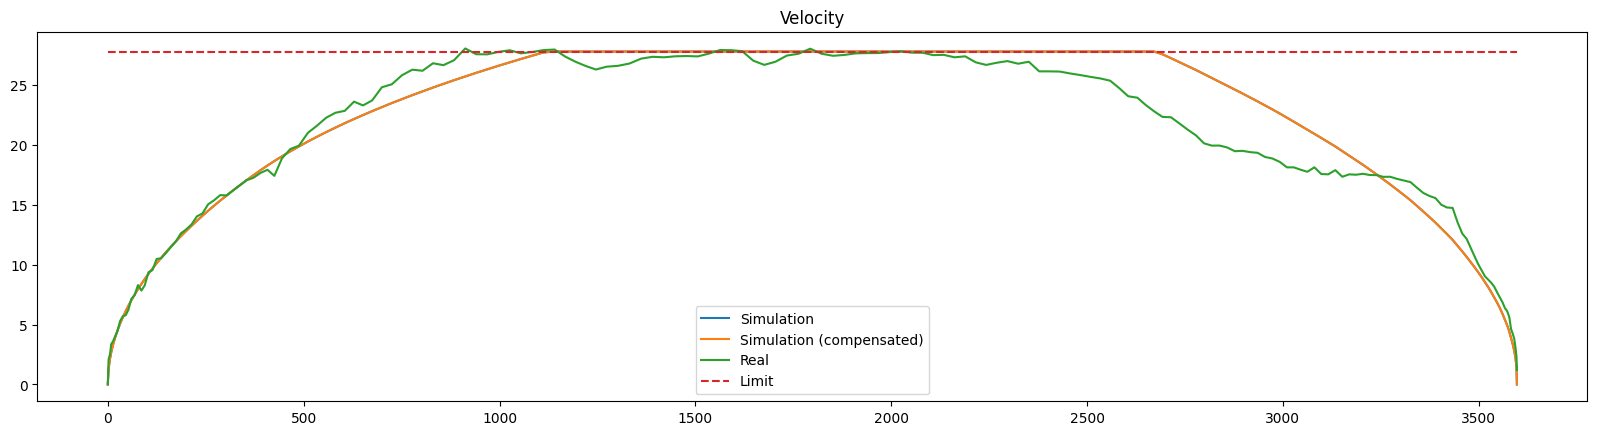

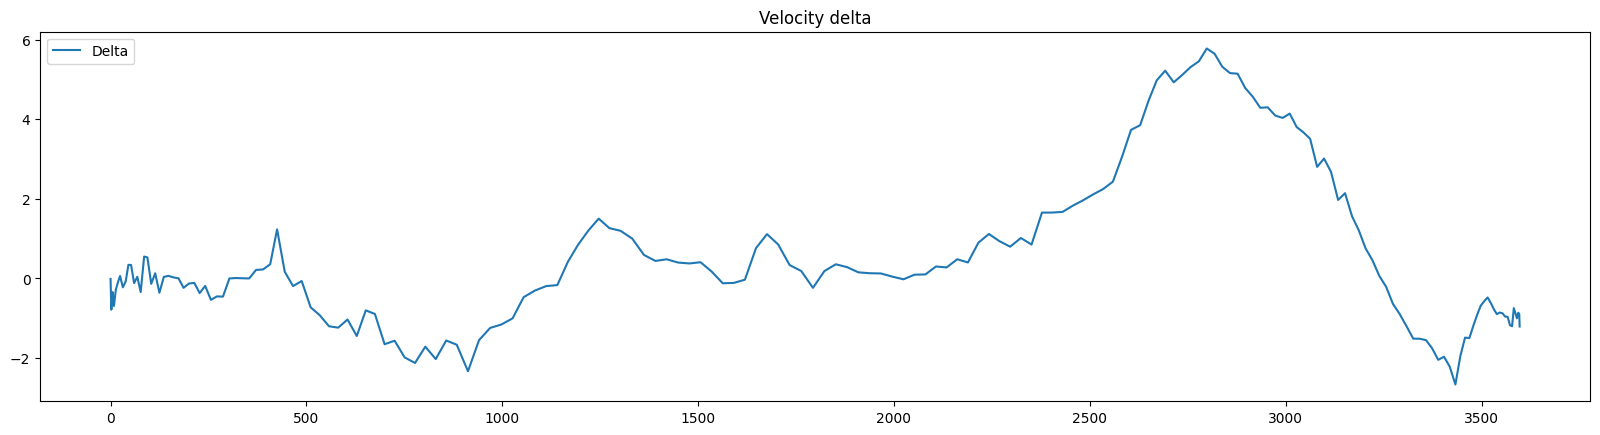

DTW: 44.07073502793759
{'station_start': 'Lhota u Opavy', 'start': 1609, 'station_end': 'Mokré Lazce', 'end': 1703}


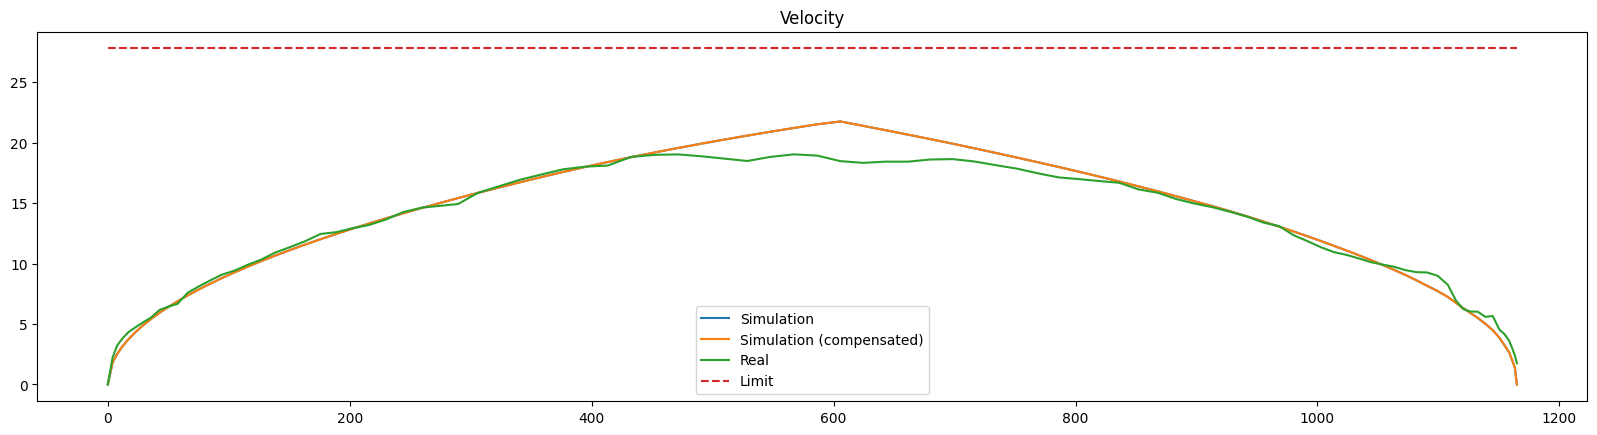

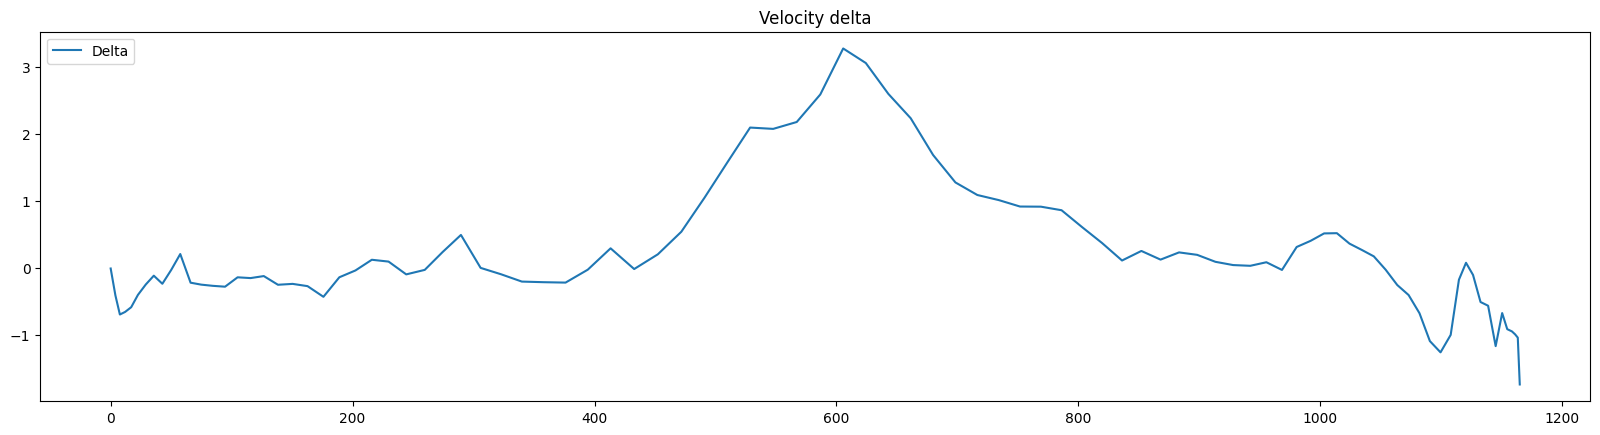

DTW: 40.50493052912503
{'station_start': 'Mokré Lazce', 'start': 1737, 'station_end': 'Štítina', 'end': 1862}


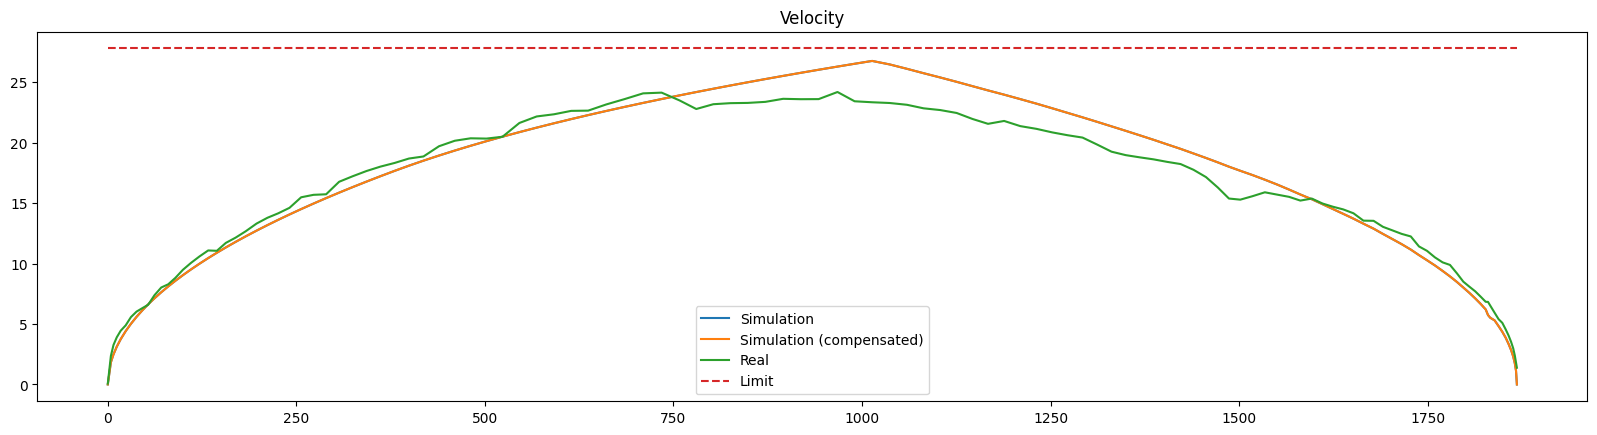

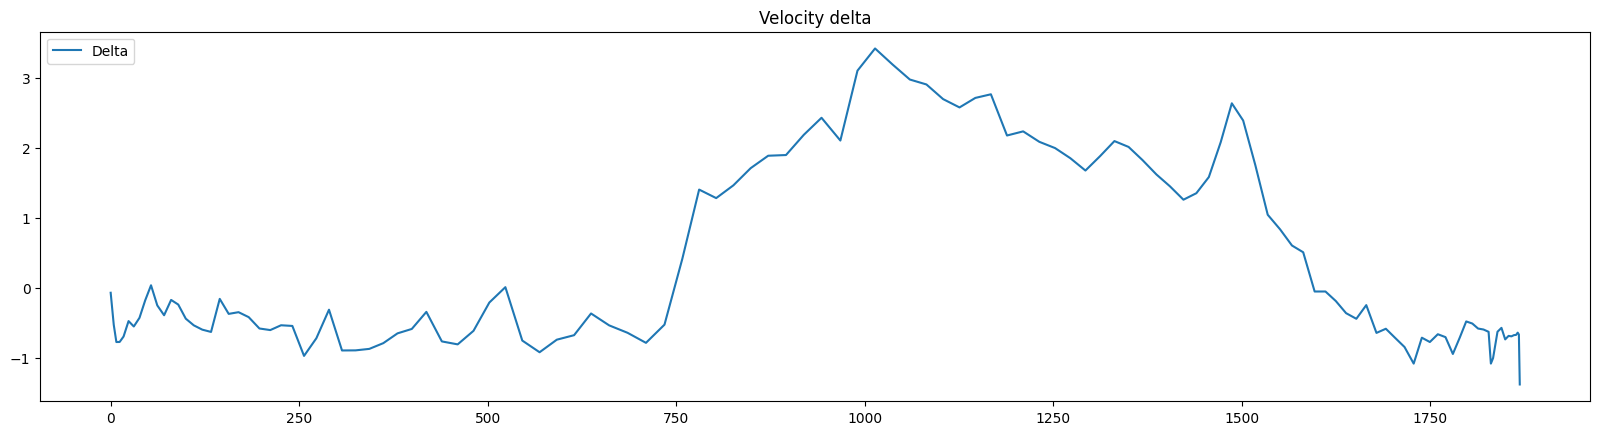

DTW: 45.32728639716035


Map(center=[49.86771005, 18.1087424], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_titl…

In [67]:
station_ranges = get_station_ranges(df3, [
    "Ostrava-Svinov",
    "Ostrava-Třebovice",
    "Děhylov",
    "Jilešovice",
    "Háj ve Slezsku",
    "Lhota u Opavy",
    "Mokré Lazce",
    "Štítina"
], 80)
print(len(station_ranges))

compare_station_ranges(
    df3, station_ranges, "Svinov-Štítina/auto/370",
    electro_params, electro_params, electro_train_params, False)